In [ ]:
!pip install yfinance --upgrade
!pip install stockstats --upgrade

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from stockstats import StockDataFrame as sdf

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from keras import models, layers, applications, optimizers, regularizers, constraints
from keras.initializers import glorot_normal
from keras.utils import np_utils
from keras.models import Sequential,Model
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
def is_third_friday(s):
    d = datetime.strptime(s, '%Y-%m-%d')
    return d.weekday() == 4 and 15 <= d.day <= 21

In [3]:
def is_leap(year):
    return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)

In [4]:
tic = 'AAPL'
stock = yf.Ticker(tic)
stock_df = yf.download(tic, start='1999-08-11', end='2021-07-24')
data_df = pd.DataFrame().append(stock_df)
    
# reset the index, we want to use numbers as index instead of dates
data_df = data_df.reset_index()

# convert the column names to standardized names
data_df.columns = ["date", "open", "high", "low", "close", "adjcp", "volume"]

[*********************100%***********************]  1 of 1 completed


In [5]:
# use adjusted close price instead of close price
data_df["close"] = data_df["adjcp"]
data_df = data_df.drop("adjcp", 1)

# convert date to standard string format, easy to filter
data_df["year"] = data_df.date.dt.year
data_df["dayofyear"] = data_df.date.dt.dayofyear
data_df["dayofweek"] = data_df.date.dt.dayofweek + 1
data_df["date"] = data_df.date.apply(lambda x: x.strftime("%Y-%m-%d"))

#for date normalization
data_df['dayofyear_sin'] = 0.01
data_df['dayofyear_cos'] = 0.01
data_df['dayofweek_sin'] = 0.01
data_df['dayofweek_cos'] = 0.01

# drop missing data
data_df = data_df.dropna()
data_df = data_df.sort_values(by=['date']).reset_index(drop=True)
stock = sdf.retype(data_df.copy())

In [6]:
for ind in ['atr', 'close_20_ema', 'close_50_ema', 'close_100_ema', 'macd', 'rsi_14']:
    temp_ind = pd.DataFrame(stock[ind])
    #data_df[ind] = temp_ind
    
    data_df = data_df.merge(temp_ind,on='date',how='left')

#data_df
data_df = data_df.sort_values(by=['date'])

#take slice of 100 onwards
data_df = data_df[100:]

#add new attributes
data_df['floor_held'] = 0
data_df['option_expiry'] = '2999-12-31'

data_df

,date,open,high,low,close,volume,year,dayofyear,dayofweek,dayofyear_sin,...,dayofweek_sin,dayofweek_cos,atr,close_20_ema,close_50_ema,close_100_ema,macd,rsi_14,floor_held,option_expiry
100,2000-01-03,0.936384,1.004464,0.907924,0.859423,535796800,2000,3,1,0.01,...,0.01,0.01,0.151724,0.778384,0.730817,0.684379,0.017626,64.525754,0,2999-12-31
101,2000-01-04,0.966518,0.987723,0.903460,0.786965,512377600,2000,4,2,0.01,...,0.01,0.01,0.150050,0.779201,0.733056,0.686714,0.016298,52.466556,0,2999-12-31
102,2000-01-05,0.926339,0.987165,0.919643,0.798481,778321600,2000,5,3,0.01,...,0.01,0.01,0.153634,0.781038,0.735664,0.689251,0.015989,53.939909,0,2999-12-31
103,2000-01-06,0.947545,0.955357,0.848214,0.729382,767972800,2000,6,4,0.01,...,0.01,0.01,0.153866,0.776118,0.735414,0.690159,0.010055,44.938924,0,2999-12-31
104,2000-01-07,0.861607,0.901786,0.852679,0.763932,460734400,2000,7,5,0.01,...,0.01,0.01,0.155190,0.774957,0.736549,0.691824,0.008046,49.478485,0,2999-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5519,2021-07-19,143.750000,144.070007,141.669998,142.449997,121434600,2021,200,1,0.01,...,0.01,0.01,2.839940,140.807067,135.189539,131.327666,4.277050,58.198457,0,2999-12-31
5520,2021-07-20,143.460007,147.100006,142.960007,146.149994,96350000,2021,201,2,0.01,...,0.01,0.01,2.969231,141.315917,135.619360,131.621177,4.175154,64.358125,0,2999-12-31
5521,2021-07-21,145.529999,146.130005,144.630005,145.399994,74993500,2021,202,3,0.01,...,0.01,0.01,2.865714,141.704877,136.002915,131.894025,3.987912,62.352438,0,2999-12-31
5522,2021-07-22,145.940002,148.199997,145.809998,146.800003,77338200,2021,203,4,0.01,...,0.01,0.01,2.861020,142.190127,136.426330,132.189193,3.907448,64.571968,0,2999-12-31


In [7]:
data_df.dtypes

date              object
open             float64
high             float64
low              float64
close            float64
volume             int64
year               int64
dayofyear          int64
dayofweek          int64
dayofyear_sin    float64
dayofyear_cos    float64
dayofweek_sin    float64
dayofweek_cos    float64
atr              float64
close_20_ema     float64
close_50_ema     float64
close_100_ema    float64
macd             float64
rsi_14           float64
floor_held         int64
option_expiry     object
dtype: object

In [8]:
floor_threshold = 0.95
min_days_to_exp = 14

#loop through each row in the data set
#for idx, row in df[df['Date'] >= '2017-08-22'].iterrows():
for i1, d1 in data_df.iterrows():
    day1 = d1['date']
    day1_dt = datetime.strptime(day1, '%Y-%m-%d')
    price1 = d1['close']
    
    price_floor = floor_threshold*price1
    floor_held = 1
    
    data_df.loc[i1, 'dayofyear_sin'] = np.sin(2*np.pi*float(d1['dayofyear'])/(366 if is_leap(d1['year']) else 365))
    data_df.loc[i1, 'dayofyear_cos'] = np.cos(2*np.pi*float(d1['dayofyear'])/(366 if is_leap(d1['year']) else 365))
    data_df.loc[i1, 'dayofweek_sin'] = np.sin(2*np.pi*float(d1['dayofweek'])/5)
    data_df.loc[i1, 'dayofweek_cos'] = np.cos(2*np.pi*float(d1['dayofweek'])/5)    
    
    for i2, d2 in data_df[data_df['date'] >= day1].iterrows():
        day2 = d2['date']
        day2_dt = datetime.strptime(day2, '%Y-%m-%d')
        price2 = d2['close']
        
        datediff = abs((day2_dt - day1_dt).days)
        
        if price2 < price_floor:
            #print(day1, day2, price_floor, price2)
            floor_held = 0
        
        #if is_third_friday(day2) and datediff > min_days_to_exp:
        if datediff > min_days_to_exp:
            data_df.loc[i1, 'option_expiry'] = day2
            break
            
    data_df.loc[i1,'floor_held'] = floor_held
    
data_df

,date,open,high,low,close,volume,year,dayofyear,dayofweek,dayofyear_sin,...,dayofweek_sin,dayofweek_cos,atr,close_20_ema,close_50_ema,close_100_ema,macd,rsi_14,floor_held,option_expiry
100,2000-01-03,0.936384,1.004464,0.907924,0.859423,535796800,2000,3,1,0.051479,...,9.510565e-01,0.309017,0.151724,0.778384,0.730817,0.684379,0.017626,64.525754,0,2000-01-18
101,2000-01-04,0.966518,0.987723,0.903460,0.786965,512377600,2000,4,2,0.068615,...,5.877853e-01,-0.809017,0.150050,0.779201,0.733056,0.686714,0.016298,52.466556,0,2000-01-19
102,2000-01-05,0.926339,0.987165,0.919643,0.798481,778321600,2000,5,3,0.085731,...,-5.877853e-01,-0.809017,0.153634,0.781038,0.735664,0.689251,0.015989,53.939909,0,2000-01-20
103,2000-01-06,0.947545,0.955357,0.848214,0.729382,767972800,2000,6,4,0.102821,...,-9.510565e-01,0.309017,0.153866,0.776118,0.735414,0.690159,0.010055,44.938924,0,2000-01-21
104,2000-01-07,0.861607,0.901786,0.852679,0.763932,460734400,2000,7,5,0.119881,...,-2.449294e-16,1.000000,0.155190,0.774957,0.736549,0.691824,0.008046,49.478485,0,2000-01-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5519,2021-07-19,143.750000,144.070007,141.669998,142.449997,121434600,2021,200,1,-0.296713,...,9.510565e-01,0.309017,2.839940,140.807067,135.189539,131.327666,4.277050,58.198457,1,2999-12-31
5520,2021-07-20,143.460007,147.100006,142.960007,146.149994,96350000,2021,201,2,-0.313107,...,5.877853e-01,-0.809017,2.969231,141.315917,135.619360,131.621177,4.175154,64.358125,1,2999-12-31
5521,2021-07-21,145.529999,146.130005,144.630005,145.399994,74993500,2021,202,3,-0.329408,...,-5.877853e-01,-0.809017,2.865714,141.704877,136.002915,131.894025,3.987912,62.352438,1,2999-12-31
5522,2021-07-22,145.940002,148.199997,145.809998,146.800003,77338200,2021,203,4,-0.345612,...,-9.510565e-01,0.309017,2.861020,142.190127,136.426330,132.189193,3.907448,64.571968,1,2999-12-31


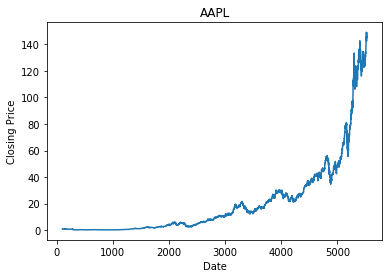

In [9]:
'''
plt.figure(1)
plt.xlabel("Date")
plt.ylabel("Support Held")
plt.title(tic)
plt.plot(data_df['floor_held'], 'o')
'''

plt.figure(0)
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title(tic)
plt.plot(data_df['close'])

In [10]:
#data_df.drop(labels=['date','year', 'dayofyear', 'dayofweek','option_expiry'], axis=1, inplace=True)
data_df_model = data_df[data_df['option_expiry'] != '2999-12-31']
excludeColumns = ['year','dayofyear', 'dayofweek','option_expiry']

#date & year aren't part of training, but are needed in the testing

data_df_train = data_df_model[data_df_model['year'] < 2020]
data_df_train = data_df_train.iloc[:,~data_df_train.columns.isin(excludeColumns)].copy()

data_df_test = data_df_model[data_df_model['year'] >= 2020]
data_df_test = data_df_test.iloc[:,~data_df_test.columns.isin(excludeColumns)].copy()
#data_df_model = data_df_model.iloc[:,~data_df_model.columns.isin(excludeColumns)].copy()

In [11]:
data_df_test

,date,open,high,low,close,volume,dayofyear_sin,dayofyear_cos,dayofweek_sin,dayofweek_cos,atr,close_20_ema,close_50_ema,close_100_ema,macd,rsi_14,floor_held
5131,2020-01-02,74.059998,75.150002,73.797501,74.207466,135480400,0.034328,0.999411,-9.510565e-01,0.309017,1.637659,69.532275,65.804904,61.333393,2.161275,84.607778,1
5132,2020-01-03,74.287498,75.144997,74.125000,73.486023,146322800,0.051479,0.998674,-2.449294e-16,1.000000,1.593540,69.908822,66.106124,61.574039,2.211049,77.733470,1
5133,2020-01-06,73.447502,74.989998,73.187500,74.071579,118387200,0.102821,0.994700,9.510565e-01,0.309017,1.608466,70.305275,66.418495,61.821515,2.271560,79.209943,1
5134,2020-01-07,74.959999,75.224998,74.370003,73.723213,108872000,0.119881,0.992788,5.877853e-01,-0.809017,1.575962,70.630793,66.704954,62.057192,2.265292,75.981933,1
5135,2020-01-08,74.290001,76.110001,74.290001,74.909149,132079200,0.136906,0.990584,-5.877853e-01,-0.809017,1.633879,71.038256,67.026687,62.311686,2.329170,79.103916,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5508,2021-07-01,136.600006,137.330002,135.759995,137.270004,52485800,0.008607,-0.999963,-9.510565e-01,0.309017,2.027511,132.195650,129.839312,128.017671,2.433499,70.991587,1
5509,2021-07-02,137.899994,140.000000,137.750000,139.960007,78852600,-0.008607,-0.999963,-2.449294e-16,1.000000,2.077689,132.935113,130.236202,128.254153,2.741608,75.604836,1
5510,2021-07-06,140.070007,143.149994,140.070007,142.020004,108181800,-0.077386,-0.997001,5.877853e-01,-0.809017,2.157139,133.800340,130.698312,128.526744,3.116090,78.433384,1
5511,2021-07-07,143.539993,144.889999,142.660004,144.570007,104911600,-0.094537,-0.995521,-5.877853e-01,-0.809017,2.208057,134.826023,131.242300,128.844432,3.577397,81.320613,1


In [12]:
ct = ColumnTransformer([
        ('Standard', StandardScaler(),
         ['open', 'high', 'low', 'close', 'volume','atr',
          'close_20_ema', 'close_50_ema', 'close_100_ema', 'macd', 'rsi_14'])],
        remainder='passthrough')

XY_train = ct.fit_transform(data_df_train)

X_train,X_val,Y_train,Y_val = train_test_split(XY_train[:, 0:-1],XY_train[:, -1], test_size = 0.2)

X_train2 = np.delete(X_train, -5, axis=1)
X_val2 = np.delete(X_val, -5, axis=1)

In [13]:
XY_test = ct.transform(data_df_test)
X_test = XY_test[:, 0:-1]
Y_test = XY_test[:, -1]
X_test2 = np.delete(X_test, -5, axis=1)
X_test2[0,:]

array([3.656526815053209, 3.6839725585693874, 3.6786131890436677,
       3.858880644178088, -0.8208757879518177, 0.3869524763132814,
       3.6136378324904745, 3.4425525045274052, 3.23979520947334,
       4.958443702048761, 2.2572335888269017, 0.034327600513243496,
       0.9994106342455052, -0.9510565162951536, 0.30901699437494723],
      dtype=object)

In [15]:
def generate_trade_plan(X, Y):
    consecutive_ups = 0
    consecutive_downs = 0
    trade_entry_days = []
    trade_exit_days = []
    trade_open = 0

    #inverse transform the stock price
    for i, p in enumerate(Y.tolist()):

        #day = round(np.arccos(X_test[i,-3])*365/(2*np.pi),0)
        #trade_date = datetime(2020, 1, 1) + timedelta(day - 1)
        trade_date = X[i,-5]

        if p[0] == 0:        
            consecutive_ups = 0
            consecutive_downs += 1
        else:
            consecutive_ups += 1
            consecutive_downs = 0

        if consecutive_ups >= 3 and trade_open == 0:
            trade_entry_days.append(trade_date)
            trade_open = 1

        if consecutive_downs > 1 and trade_open == 1:
            trade_exit_days.append(trade_date)
            trade_open = 0

    return trade_entry_days, trade_exit_days

In [16]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#is optimizer deterministic
accuracies = []
losses = []

for run in range(30):
    NN = Sequential()
    NN.add(layers.Dense(6, name = "hidden1", input_dim=X_train2.shape[1], activation='relu', 
                    kernel_initializer=glorot_normal(seed=run)))
    NN.add(layers.Dense(3, name = "hidden2", activation='relu', 
                    kernel_initializer=glorot_normal(seed=run)))
    NN.add(layers.Dense(1, name = "output", activation='sigmoid', kernel_initializer=glorot_normal(seed=run)))
    NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    AAPL_test = NN.fit(x=X_train2,y=Y_train, epochs=300, validation_data=(X_val2, Y_val), callbacks=[es], verbose=2)
    val_loss, val_acc = NN.evaluate(X_val2, Y_val)
    accuracies.append(val_acc)
    losses.append(val_loss)
    fname = "Nodes_run" + str(run) + "_weights.h5"
    NN.save_weights(fname)  

Train on 4024 samples, validate on 1007 samples
Epoch 1/300
 - 0s - loss: 0.6866 - accuracy: 0.6121 - val_loss: 0.6672 - val_accuracy: 0.7219
Epoch 2/300
 - 0s - loss: 0.6520 - accuracy: 0.7028 - val_loss: 0.6171 - val_accuracy: 0.7299
Epoch 3/300
 - 0s - loss: 0.6133 - accuracy: 0.7035 - val_loss: 0.5782 - val_accuracy: 0.7299
Epoch 4/300
 - 0s - loss: 0.6020 - accuracy: 0.7033 - val_loss: 0.5712 - val_accuracy: 0.7299
Epoch 5/300
 - 0s - loss: 0.5981 - accuracy: 0.7033 - val_loss: 0.5677 - val_accuracy: 0.7299
Epoch 6/300
 - 0s - loss: 0.5948 - accuracy: 0.7033 - val_loss: 0.5661 - val_accuracy: 0.7299
Epoch 7/300
 - 0s - loss: 0.5914 - accuracy: 0.7035 - val_loss: 0.5622 - val_accuracy: 0.7299
Epoch 8/300
 - 0s - loss: 0.5887 - accuracy: 0.7013 - val_loss: 0.5603 - val_accuracy: 0.7299
Epoch 9/300
 - 0s - loss: 0.5864 - accuracy: 0.7038 - val_loss: 0.5579 - val_accuracy: 0.7299
Epoch 10/300
 - 0s - loss: 0.5841 - accuracy: 0.7033 - val_loss: 0.5573 - val_accuracy: 0.7299
Epoch 11/30

Epoch 15/300
 - 0s - loss: 0.5752 - accuracy: 0.7060 - val_loss: 0.5600 - val_accuracy: 0.7279
Epoch 16/300
 - 0s - loss: 0.5746 - accuracy: 0.7055 - val_loss: 0.5577 - val_accuracy: 0.7279
Epoch 17/300
 - 0s - loss: 0.5746 - accuracy: 0.7065 - val_loss: 0.5560 - val_accuracy: 0.7309
Epoch 18/300
 - 0s - loss: 0.5736 - accuracy: 0.7065 - val_loss: 0.5602 - val_accuracy: 0.7299
Epoch 19/300
 - 0s - loss: 0.5734 - accuracy: 0.7058 - val_loss: 0.5578 - val_accuracy: 0.7299
Epoch 20/300
 - 0s - loss: 0.5730 - accuracy: 0.7075 - val_loss: 0.5552 - val_accuracy: 0.7319
Epoch 21/300
 - 0s - loss: 0.5727 - accuracy: 0.7063 - val_loss: 0.5553 - val_accuracy: 0.7289
Epoch 22/300
 - 0s - loss: 0.5726 - accuracy: 0.7065 - val_loss: 0.5547 - val_accuracy: 0.7309
Epoch 23/300
 - 0s - loss: 0.5718 - accuracy: 0.7080 - val_loss: 0.5530 - val_accuracy: 0.7329
Epoch 24/300
 - 0s - loss: 0.5721 - accuracy: 0.7073 - val_loss: 0.5572 - val_accuracy: 0.7339
Epoch 25/300
 - 0s - loss: 0.5716 - accuracy: 0.70

Epoch 39/300
 - 0s - loss: 0.5641 - accuracy: 0.7023 - val_loss: 0.5457 - val_accuracy: 0.7289
Epoch 40/300
 - 0s - loss: 0.5637 - accuracy: 0.7035 - val_loss: 0.5493 - val_accuracy: 0.7289
Epoch 41/300
 - 0s - loss: 0.5634 - accuracy: 0.7030 - val_loss: 0.5496 - val_accuracy: 0.7289
Epoch 42/300
 - 0s - loss: 0.5632 - accuracy: 0.7028 - val_loss: 0.5485 - val_accuracy: 0.7289
Epoch 43/300
 - 0s - loss: 0.5625 - accuracy: 0.7020 - val_loss: 0.5512 - val_accuracy: 0.7289
Epoch 44/300
 - 0s - loss: 0.5628 - accuracy: 0.7030 - val_loss: 0.5468 - val_accuracy: 0.7289
Epoch 45/300
 - 0s - loss: 0.5624 - accuracy: 0.7030 - val_loss: 0.5465 - val_accuracy: 0.7279
Epoch 46/300
 - 0s - loss: 0.5618 - accuracy: 0.7020 - val_loss: 0.5473 - val_accuracy: 0.7269
Epoch 47/300
 - 0s - loss: 0.5613 - accuracy: 0.7040 - val_loss: 0.5472 - val_accuracy: 0.7259
Epoch 48/300
 - 0s - loss: 0.5611 - accuracy: 0.7028 - val_loss: 0.5519 - val_accuracy: 0.7269
Epoch 49/300
 - 0s - loss: 0.5609 - accuracy: 0.70

Restoring model weights from the end of the best epoch
Epoch 00074: early stopping
1007/1007 [==============================] - 0s 17us/step
Train on 4024 samples, validate on 1007 samples
Epoch 1/300
 - 0s - loss: 0.6752 - accuracy: 0.6404 - val_loss: 0.6279 - val_accuracy: 0.7299
Epoch 2/300
 - 0s - loss: 0.6241 - accuracy: 0.7033 - val_loss: 0.5913 - val_accuracy: 0.7299
Epoch 3/300
 - 0s - loss: 0.6044 - accuracy: 0.7033 - val_loss: 0.5811 - val_accuracy: 0.7299
Epoch 4/300
 - 0s - loss: 0.5938 - accuracy: 0.7033 - val_loss: 0.5741 - val_accuracy: 0.7299
Epoch 5/300
 - 0s - loss: 0.5888 - accuracy: 0.7035 - val_loss: 0.5748 - val_accuracy: 0.7269
Epoch 6/300
 - 0s - loss: 0.5869 - accuracy: 0.7063 - val_loss: 0.5698 - val_accuracy: 0.7279
Epoch 7/300
 - 0s - loss: 0.5851 - accuracy: 0.7070 - val_loss: 0.5678 - val_accuracy: 0.7279
Epoch 8/300
 - 0s - loss: 0.5840 - accuracy: 0.7065 - val_loss: 0.5685 - val_accuracy: 0.7269
Epoch 9/300
 - 0s - loss: 0.5832 - accuracy: 0.7070 - val_l

Epoch 13/300
 - 0s - loss: 0.5747 - accuracy: 0.7068 - val_loss: 0.5623 - val_accuracy: 0.7170
Epoch 14/300
 - 0s - loss: 0.5743 - accuracy: 0.7075 - val_loss: 0.5606 - val_accuracy: 0.7210
Epoch 15/300
 - 0s - loss: 0.5732 - accuracy: 0.7040 - val_loss: 0.5615 - val_accuracy: 0.7219
Epoch 16/300
 - 0s - loss: 0.5728 - accuracy: 0.7083 - val_loss: 0.5614 - val_accuracy: 0.7249
Epoch 17/300
 - 0s - loss: 0.5720 - accuracy: 0.7100 - val_loss: 0.5590 - val_accuracy: 0.7150
Epoch 18/300
 - 0s - loss: 0.5716 - accuracy: 0.7043 - val_loss: 0.5594 - val_accuracy: 0.7249
Epoch 19/300
 - 0s - loss: 0.5712 - accuracy: 0.7063 - val_loss: 0.5582 - val_accuracy: 0.7249
Epoch 20/300
 - 0s - loss: 0.5708 - accuracy: 0.7090 - val_loss: 0.5575 - val_accuracy: 0.7180
Epoch 21/300
 - 0s - loss: 0.5698 - accuracy: 0.7040 - val_loss: 0.5563 - val_accuracy: 0.7160
Epoch 22/300
 - 0s - loss: 0.5705 - accuracy: 0.7070 - val_loss: 0.5605 - val_accuracy: 0.7130
Epoch 23/300
 - 0s - loss: 0.5687 - accuracy: 0.70

Epoch 16/300
 - 0s - loss: 0.5738 - accuracy: 0.7033 - val_loss: 0.5528 - val_accuracy: 0.7299
Epoch 17/300
 - 0s - loss: 0.5729 - accuracy: 0.7033 - val_loss: 0.5495 - val_accuracy: 0.7299
Epoch 18/300
 - 0s - loss: 0.5721 - accuracy: 0.7033 - val_loss: 0.5513 - val_accuracy: 0.7299
Epoch 19/300
 - 0s - loss: 0.5718 - accuracy: 0.7033 - val_loss: 0.5500 - val_accuracy: 0.7299
Epoch 20/300
 - 0s - loss: 0.5708 - accuracy: 0.7033 - val_loss: 0.5494 - val_accuracy: 0.7299
Epoch 21/300
 - 0s - loss: 0.5703 - accuracy: 0.7033 - val_loss: 0.5465 - val_accuracy: 0.7299
Epoch 22/300
 - 0s - loss: 0.5699 - accuracy: 0.7033 - val_loss: 0.5488 - val_accuracy: 0.7299
Epoch 23/300
 - 0s - loss: 0.5688 - accuracy: 0.7033 - val_loss: 0.5465 - val_accuracy: 0.7299
Epoch 24/300
 - 0s - loss: 0.5684 - accuracy: 0.7033 - val_loss: 0.5458 - val_accuracy: 0.7299
Epoch 25/300
 - 0s - loss: 0.5680 - accuracy: 0.7033 - val_loss: 0.5465 - val_accuracy: 0.7299
Epoch 26/300
 - 0s - loss: 0.5668 - accuracy: 0.70

Epoch 49/300
 - 0s - loss: 0.5836 - accuracy: 0.7095 - val_loss: 0.5660 - val_accuracy: 0.7279
Epoch 50/300
 - 0s - loss: 0.5829 - accuracy: 0.7100 - val_loss: 0.5652 - val_accuracy: 0.7289
Epoch 51/300
 - 0s - loss: 0.5828 - accuracy: 0.7097 - val_loss: 0.5649 - val_accuracy: 0.7289
Epoch 52/300
 - 0s - loss: 0.5827 - accuracy: 0.7100 - val_loss: 0.5656 - val_accuracy: 0.7279
Epoch 53/300
 - 0s - loss: 0.5823 - accuracy: 0.7115 - val_loss: 0.5646 - val_accuracy: 0.7289
Epoch 54/300
 - 0s - loss: 0.5822 - accuracy: 0.7102 - val_loss: 0.5651 - val_accuracy: 0.7289
Epoch 55/300
 - 0s - loss: 0.5820 - accuracy: 0.7115 - val_loss: 0.5651 - val_accuracy: 0.7289
Epoch 56/300
 - 0s - loss: 0.5819 - accuracy: 0.7102 - val_loss: 0.5644 - val_accuracy: 0.7289
Epoch 57/300
 - 0s - loss: 0.5816 - accuracy: 0.7132 - val_loss: 0.5643 - val_accuracy: 0.7309
Epoch 58/300
 - 0s - loss: 0.5813 - accuracy: 0.7120 - val_loss: 0.5637 - val_accuracy: 0.7309
Epoch 59/300
 - 0s - loss: 0.5813 - accuracy: 0.71

Epoch 18/300
 - 0s - loss: 0.5805 - accuracy: 0.7033 - val_loss: 0.5531 - val_accuracy: 0.7299
Epoch 19/300
 - 0s - loss: 0.5799 - accuracy: 0.7033 - val_loss: 0.5530 - val_accuracy: 0.7299
Epoch 20/300
 - 0s - loss: 0.5796 - accuracy: 0.7033 - val_loss: 0.5524 - val_accuracy: 0.7299
Epoch 21/300
 - 0s - loss: 0.5794 - accuracy: 0.7033 - val_loss: 0.5531 - val_accuracy: 0.7299
Epoch 22/300
 - 0s - loss: 0.5790 - accuracy: 0.7033 - val_loss: 0.5525 - val_accuracy: 0.7299
Epoch 23/300
 - 0s - loss: 0.5787 - accuracy: 0.7033 - val_loss: 0.5524 - val_accuracy: 0.7299
Epoch 24/300
 - 0s - loss: 0.5780 - accuracy: 0.7033 - val_loss: 0.5533 - val_accuracy: 0.7299
Epoch 25/300
 - 0s - loss: 0.5775 - accuracy: 0.7033 - val_loss: 0.5534 - val_accuracy: 0.7299
Epoch 26/300
 - 0s - loss: 0.5775 - accuracy: 0.7033 - val_loss: 0.5518 - val_accuracy: 0.7299
Epoch 27/300
 - 0s - loss: 0.5769 - accuracy: 0.7033 - val_loss: 0.5523 - val_accuracy: 0.7299
Epoch 28/300
 - 0s - loss: 0.5761 - accuracy: 0.70

Epoch 38/300
 - 0s - loss: 0.5676 - accuracy: 0.7033 - val_loss: 0.5448 - val_accuracy: 0.7299
Epoch 39/300
 - 0s - loss: 0.5670 - accuracy: 0.7033 - val_loss: 0.5506 - val_accuracy: 0.7299
Epoch 40/300
 - 0s - loss: 0.5669 - accuracy: 0.7033 - val_loss: 0.5452 - val_accuracy: 0.7299
Epoch 41/300
 - 0s - loss: 0.5668 - accuracy: 0.7033 - val_loss: 0.5482 - val_accuracy: 0.7299
Epoch 42/300
 - 0s - loss: 0.5663 - accuracy: 0.7033 - val_loss: 0.5467 - val_accuracy: 0.7299
Epoch 43/300
 - 0s - loss: 0.5665 - accuracy: 0.7033 - val_loss: 0.5458 - val_accuracy: 0.7299
Epoch 44/300
 - 0s - loss: 0.5658 - accuracy: 0.7033 - val_loss: 0.5459 - val_accuracy: 0.7299
Epoch 45/300
 - 0s - loss: 0.5658 - accuracy: 0.7033 - val_loss: 0.5461 - val_accuracy: 0.7299
Epoch 46/300
 - 0s - loss: 0.5659 - accuracy: 0.7033 - val_loss: 0.5457 - val_accuracy: 0.7299
Epoch 47/300
 - 0s - loss: 0.5656 - accuracy: 0.7033 - val_loss: 0.5443 - val_accuracy: 0.7299
Epoch 48/300
 - 0s - loss: 0.5653 - accuracy: 0.70

Epoch 54/300
 - 0s - loss: 0.5591 - accuracy: 0.7177 - val_loss: 0.5387 - val_accuracy: 0.7408
Epoch 55/300
 - 0s - loss: 0.5591 - accuracy: 0.7192 - val_loss: 0.5399 - val_accuracy: 0.7418
Epoch 56/300
 - 0s - loss: 0.5586 - accuracy: 0.7199 - val_loss: 0.5447 - val_accuracy: 0.7378
Epoch 57/300
 - 0s - loss: 0.5590 - accuracy: 0.7202 - val_loss: 0.5392 - val_accuracy: 0.7418
Epoch 58/300
 - 0s - loss: 0.5587 - accuracy: 0.7199 - val_loss: 0.5394 - val_accuracy: 0.7408
Epoch 59/300
 - 0s - loss: 0.5582 - accuracy: 0.7212 - val_loss: 0.5385 - val_accuracy: 0.7418
Epoch 60/300
 - 0s - loss: 0.5590 - accuracy: 0.7189 - val_loss: 0.5387 - val_accuracy: 0.7398
Epoch 61/300
 - 0s - loss: 0.5582 - accuracy: 0.7202 - val_loss: 0.5375 - val_accuracy: 0.7438
Epoch 62/300
 - 0s - loss: 0.5578 - accuracy: 0.7199 - val_loss: 0.5396 - val_accuracy: 0.7398
Epoch 63/300
 - 0s - loss: 0.5578 - accuracy: 0.7209 - val_loss: 0.5383 - val_accuracy: 0.7438
Epoch 64/300
 - 0s - loss: 0.5575 - accuracy: 0.71

Epoch 56/300
 - 0s - loss: 0.5594 - accuracy: 0.7142 - val_loss: 0.5468 - val_accuracy: 0.7229
Epoch 57/300
 - 0s - loss: 0.5590 - accuracy: 0.7152 - val_loss: 0.5469 - val_accuracy: 0.7210
Epoch 58/300
 - 0s - loss: 0.5585 - accuracy: 0.7137 - val_loss: 0.5467 - val_accuracy: 0.7210
Epoch 59/300
 - 0s - loss: 0.5581 - accuracy: 0.7160 - val_loss: 0.5487 - val_accuracy: 0.7110
Epoch 60/300
 - 0s - loss: 0.5581 - accuracy: 0.7147 - val_loss: 0.5485 - val_accuracy: 0.7160
Epoch 61/300
 - 0s - loss: 0.5581 - accuracy: 0.7137 - val_loss: 0.5474 - val_accuracy: 0.7130
Epoch 62/300
 - 0s - loss: 0.5578 - accuracy: 0.7142 - val_loss: 0.5447 - val_accuracy: 0.7229
Epoch 63/300
 - 0s - loss: 0.5577 - accuracy: 0.7137 - val_loss: 0.5470 - val_accuracy: 0.7190
Epoch 64/300
 - 0s - loss: 0.5574 - accuracy: 0.7125 - val_loss: 0.5456 - val_accuracy: 0.7269
Epoch 65/300
 - 0s - loss: 0.5575 - accuracy: 0.7120 - val_loss: 0.5453 - val_accuracy: 0.7239
Epoch 66/300
 - 0s - loss: 0.5568 - accuracy: 0.71

Epoch 28/300
 - 0s - loss: 0.5655 - accuracy: 0.7120 - val_loss: 0.5564 - val_accuracy: 0.7329
Epoch 29/300
 - 0s - loss: 0.5655 - accuracy: 0.7127 - val_loss: 0.5544 - val_accuracy: 0.7329
Epoch 30/300
 - 0s - loss: 0.5643 - accuracy: 0.7130 - val_loss: 0.5550 - val_accuracy: 0.7289
Epoch 31/300
 - 0s - loss: 0.5645 - accuracy: 0.7145 - val_loss: 0.5539 - val_accuracy: 0.7319
Epoch 32/300
 - 0s - loss: 0.5638 - accuracy: 0.7147 - val_loss: 0.5542 - val_accuracy: 0.7319
Epoch 33/300
 - 0s - loss: 0.5636 - accuracy: 0.7135 - val_loss: 0.5536 - val_accuracy: 0.7299
Epoch 34/300
 - 0s - loss: 0.5632 - accuracy: 0.7125 - val_loss: 0.5522 - val_accuracy: 0.7299
Epoch 35/300
 - 0s - loss: 0.5629 - accuracy: 0.7120 - val_loss: 0.5519 - val_accuracy: 0.7299
Epoch 36/300
 - 0s - loss: 0.5623 - accuracy: 0.7130 - val_loss: 0.5534 - val_accuracy: 0.7329
Epoch 37/300
 - 0s - loss: 0.5620 - accuracy: 0.7122 - val_loss: 0.5529 - val_accuracy: 0.7329
Epoch 38/300
 - 0s - loss: 0.5624 - accuracy: 0.71

Epoch 24/300
 - 0s - loss: 0.5692 - accuracy: 0.7107 - val_loss: 0.5513 - val_accuracy: 0.7239
Epoch 25/300
 - 0s - loss: 0.5688 - accuracy: 0.7107 - val_loss: 0.5513 - val_accuracy: 0.7239
Epoch 26/300
 - 0s - loss: 0.5685 - accuracy: 0.7102 - val_loss: 0.5508 - val_accuracy: 0.7259
Epoch 27/300
 - 0s - loss: 0.5679 - accuracy: 0.7117 - val_loss: 0.5511 - val_accuracy: 0.7259
Epoch 28/300
 - 0s - loss: 0.5681 - accuracy: 0.7102 - val_loss: 0.5552 - val_accuracy: 0.7269
Epoch 29/300
 - 0s - loss: 0.5673 - accuracy: 0.7112 - val_loss: 0.5551 - val_accuracy: 0.7269
Epoch 30/300
 - 0s - loss: 0.5670 - accuracy: 0.7107 - val_loss: 0.5510 - val_accuracy: 0.7249
Epoch 31/300
 - 0s - loss: 0.5667 - accuracy: 0.7097 - val_loss: 0.5506 - val_accuracy: 0.7279
Epoch 32/300
 - 0s - loss: 0.5670 - accuracy: 0.7100 - val_loss: 0.5536 - val_accuracy: 0.7249
Epoch 33/300
 - 0s - loss: 0.5661 - accuracy: 0.7107 - val_loss: 0.5504 - val_accuracy: 0.7259
Epoch 34/300
 - 0s - loss: 0.5662 - accuracy: 0.71

Epoch 59/300
 - 0s - loss: 0.5630 - accuracy: 0.7219 - val_loss: 0.5299 - val_accuracy: 0.7577
Epoch 60/300
 - 0s - loss: 0.5628 - accuracy: 0.7229 - val_loss: 0.5293 - val_accuracy: 0.7527
Epoch 61/300
 - 0s - loss: 0.5624 - accuracy: 0.7242 - val_loss: 0.5297 - val_accuracy: 0.7597
Epoch 62/300
 - 0s - loss: 0.5626 - accuracy: 0.7204 - val_loss: 0.5283 - val_accuracy: 0.7547
Epoch 63/300
 - 0s - loss: 0.5622 - accuracy: 0.7224 - val_loss: 0.5284 - val_accuracy: 0.7517
Epoch 64/300
 - 0s - loss: 0.5619 - accuracy: 0.7222 - val_loss: 0.5284 - val_accuracy: 0.7607
Epoch 65/300
 - 0s - loss: 0.5620 - accuracy: 0.7229 - val_loss: 0.5278 - val_accuracy: 0.7597
Epoch 66/300
 - 0s - loss: 0.5616 - accuracy: 0.7219 - val_loss: 0.5281 - val_accuracy: 0.7597
Epoch 67/300
 - 0s - loss: 0.5616 - accuracy: 0.7207 - val_loss: 0.5276 - val_accuracy: 0.7537
Epoch 68/300
 - 0s - loss: 0.5615 - accuracy: 0.7217 - val_loss: 0.5275 - val_accuracy: 0.7547
Epoch 69/300
 - 0s - loss: 0.5613 - accuracy: 0.72

Epoch 57/300
 - 0s - loss: 0.5678 - accuracy: 0.7115 - val_loss: 0.5520 - val_accuracy: 0.7309
Epoch 58/300
 - 0s - loss: 0.5674 - accuracy: 0.7095 - val_loss: 0.5510 - val_accuracy: 0.7299
Epoch 59/300
 - 0s - loss: 0.5674 - accuracy: 0.7100 - val_loss: 0.5540 - val_accuracy: 0.7259
Epoch 60/300
 - 0s - loss: 0.5670 - accuracy: 0.7125 - val_loss: 0.5522 - val_accuracy: 0.7269
Epoch 61/300
 - 0s - loss: 0.5667 - accuracy: 0.7125 - val_loss: 0.5531 - val_accuracy: 0.7239
Epoch 62/300
 - 0s - loss: 0.5667 - accuracy: 0.7132 - val_loss: 0.5513 - val_accuracy: 0.7249
Epoch 63/300
 - 0s - loss: 0.5662 - accuracy: 0.7130 - val_loss: 0.5536 - val_accuracy: 0.7259
Epoch 64/300
 - 0s - loss: 0.5658 - accuracy: 0.7125 - val_loss: 0.5526 - val_accuracy: 0.7279
Epoch 65/300
 - 0s - loss: 0.5654 - accuracy: 0.7169 - val_loss: 0.5495 - val_accuracy: 0.7289
Epoch 66/300
 - 0s - loss: 0.5659 - accuracy: 0.7130 - val_loss: 0.5517 - val_accuracy: 0.7279
Epoch 67/300
 - 0s - loss: 0.5653 - accuracy: 0.71

Epoch 4/300
 - 0s - loss: 0.5970 - accuracy: 0.7033 - val_loss: 0.5661 - val_accuracy: 0.7299
Epoch 5/300
 - 0s - loss: 0.5935 - accuracy: 0.7033 - val_loss: 0.5607 - val_accuracy: 0.7299
Epoch 6/300
 - 0s - loss: 0.5901 - accuracy: 0.7033 - val_loss: 0.5591 - val_accuracy: 0.7299
Epoch 7/300
 - 0s - loss: 0.5881 - accuracy: 0.7033 - val_loss: 0.5568 - val_accuracy: 0.7299
Epoch 8/300
 - 0s - loss: 0.5867 - accuracy: 0.7033 - val_loss: 0.5552 - val_accuracy: 0.7299
Epoch 9/300
 - 0s - loss: 0.5850 - accuracy: 0.7033 - val_loss: 0.5548 - val_accuracy: 0.7299
Epoch 10/300
 - 0s - loss: 0.5836 - accuracy: 0.7033 - val_loss: 0.5548 - val_accuracy: 0.7299
Epoch 11/300
 - 0s - loss: 0.5825 - accuracy: 0.7033 - val_loss: 0.5528 - val_accuracy: 0.7299
Epoch 12/300
 - 0s - loss: 0.5818 - accuracy: 0.7033 - val_loss: 0.5526 - val_accuracy: 0.7299
Epoch 13/300
 - 0s - loss: 0.5808 - accuracy: 0.7033 - val_loss: 0.5527 - val_accuracy: 0.7299
Epoch 14/300
 - 0s - loss: 0.5801 - accuracy: 0.7033 - v

Epoch 30/300
 - 0s - loss: 0.5682 - accuracy: 0.7060 - val_loss: 0.5507 - val_accuracy: 0.7279
Epoch 31/300
 - 0s - loss: 0.5677 - accuracy: 0.7065 - val_loss: 0.5521 - val_accuracy: 0.7269
Epoch 32/300
 - 0s - loss: 0.5670 - accuracy: 0.7068 - val_loss: 0.5493 - val_accuracy: 0.7299
Epoch 33/300
 - 0s - loss: 0.5663 - accuracy: 0.7070 - val_loss: 0.5488 - val_accuracy: 0.7289
Epoch 34/300
 - 0s - loss: 0.5656 - accuracy: 0.7073 - val_loss: 0.5567 - val_accuracy: 0.7279
Epoch 35/300
 - 0s - loss: 0.5655 - accuracy: 0.7075 - val_loss: 0.5502 - val_accuracy: 0.7289
Epoch 36/300
 - 0s - loss: 0.5650 - accuracy: 0.7080 - val_loss: 0.5484 - val_accuracy: 0.7299
Epoch 37/300
 - 0s - loss: 0.5643 - accuracy: 0.7063 - val_loss: 0.5553 - val_accuracy: 0.7309
Epoch 38/300
 - 0s - loss: 0.5651 - accuracy: 0.7075 - val_loss: 0.5517 - val_accuracy: 0.7309
Epoch 39/300
 - 0s - loss: 0.5645 - accuracy: 0.7065 - val_loss: 0.5498 - val_accuracy: 0.7309
Epoch 40/300
 - 0s - loss: 0.5636 - accuracy: 0.70

Epoch 60/300
 - 0s - loss: 0.5625 - accuracy: 0.7117 - val_loss: 0.5418 - val_accuracy: 0.7319
Epoch 61/300
 - 0s - loss: 0.5628 - accuracy: 0.7127 - val_loss: 0.5424 - val_accuracy: 0.7339
Epoch 62/300
 - 0s - loss: 0.5623 - accuracy: 0.7150 - val_loss: 0.5420 - val_accuracy: 0.7329
Epoch 63/300
 - 0s - loss: 0.5615 - accuracy: 0.7127 - val_loss: 0.5407 - val_accuracy: 0.7329
Epoch 64/300
 - 0s - loss: 0.5617 - accuracy: 0.7112 - val_loss: 0.5420 - val_accuracy: 0.7349
Epoch 65/300
 - 0s - loss: 0.5613 - accuracy: 0.7125 - val_loss: 0.5412 - val_accuracy: 0.7279
Epoch 66/300
 - 0s - loss: 0.5613 - accuracy: 0.7137 - val_loss: 0.5424 - val_accuracy: 0.7289
Epoch 67/300
 - 0s - loss: 0.5612 - accuracy: 0.7130 - val_loss: 0.5445 - val_accuracy: 0.7279
Epoch 68/300
 - 0s - loss: 0.5606 - accuracy: 0.7152 - val_loss: 0.5411 - val_accuracy: 0.7319
Epoch 69/300
 - 0s - loss: 0.5602 - accuracy: 0.7145 - val_loss: 0.5417 - val_accuracy: 0.7339
Epoch 70/300
 - 0s - loss: 0.5608 - accuracy: 0.71

Epoch 62/300
 - 0s - loss: 0.5490 - accuracy: 0.7169 - val_loss: 0.5400 - val_accuracy: 0.7378
Epoch 63/300
 - 0s - loss: 0.5486 - accuracy: 0.7150 - val_loss: 0.5428 - val_accuracy: 0.7319
Epoch 64/300
 - 0s - loss: 0.5484 - accuracy: 0.7165 - val_loss: 0.5400 - val_accuracy: 0.7408
Epoch 65/300
 - 0s - loss: 0.5482 - accuracy: 0.7174 - val_loss: 0.5422 - val_accuracy: 0.7368
Epoch 66/300
 - 0s - loss: 0.5476 - accuracy: 0.7182 - val_loss: 0.5406 - val_accuracy: 0.7398
Epoch 67/300
 - 0s - loss: 0.5482 - accuracy: 0.7160 - val_loss: 0.5433 - val_accuracy: 0.7319
Epoch 68/300
 - 0s - loss: 0.5473 - accuracy: 0.7162 - val_loss: 0.5422 - val_accuracy: 0.7378
Restoring model weights from the end of the best epoch
Epoch 00068: early stopping
1007/1007 [==============================] - 0s 16us/step
Train on 4024 samples, validate on 1007 samples
Epoch 1/300
 - 0s - loss: 0.6292 - accuracy: 0.7035 - val_loss: 0.5860 - val_accuracy: 0.7299
Epoch 2/300
 - 0s - loss: 0.6060 - accuracy: 0.7033 

Epoch 3/300
 - 0s - loss: 0.5995 - accuracy: 0.7015 - val_loss: 0.5700 - val_accuracy: 0.7269
Epoch 4/300
 - 0s - loss: 0.5938 - accuracy: 0.7028 - val_loss: 0.5623 - val_accuracy: 0.7299
Epoch 5/300
 - 0s - loss: 0.5892 - accuracy: 0.7030 - val_loss: 0.5583 - val_accuracy: 0.7299
Epoch 6/300
 - 0s - loss: 0.5857 - accuracy: 0.7033 - val_loss: 0.5542 - val_accuracy: 0.7299
Epoch 7/300
 - 0s - loss: 0.5837 - accuracy: 0.7033 - val_loss: 0.5552 - val_accuracy: 0.7299
Epoch 8/300
 - 0s - loss: 0.5812 - accuracy: 0.7033 - val_loss: 0.5535 - val_accuracy: 0.7299
Epoch 9/300
 - 0s - loss: 0.5800 - accuracy: 0.7033 - val_loss: 0.5520 - val_accuracy: 0.7299
Epoch 10/300
 - 0s - loss: 0.5782 - accuracy: 0.7033 - val_loss: 0.5544 - val_accuracy: 0.7309
Epoch 11/300
 - 0s - loss: 0.5772 - accuracy: 0.7033 - val_loss: 0.5519 - val_accuracy: 0.7299
Epoch 12/300
 - 0s - loss: 0.5751 - accuracy: 0.7038 - val_loss: 0.5481 - val_accuracy: 0.7299
Epoch 13/300
 - 0s - loss: 0.5754 - accuracy: 0.7033 - va

Epoch 32/300
 - 0s - loss: 0.5697 - accuracy: 0.7142 - val_loss: 0.5564 - val_accuracy: 0.7259
Epoch 33/300
 - 0s - loss: 0.5694 - accuracy: 0.7125 - val_loss: 0.5556 - val_accuracy: 0.7279
Epoch 34/300
 - 0s - loss: 0.5688 - accuracy: 0.7132 - val_loss: 0.5535 - val_accuracy: 0.7259
Epoch 35/300
 - 0s - loss: 0.5683 - accuracy: 0.7137 - val_loss: 0.5551 - val_accuracy: 0.7279
Epoch 36/300
 - 0s - loss: 0.5679 - accuracy: 0.7137 - val_loss: 0.5531 - val_accuracy: 0.7269
Epoch 37/300
 - 0s - loss: 0.5675 - accuracy: 0.7142 - val_loss: 0.5533 - val_accuracy: 0.7309
Epoch 38/300
 - 0s - loss: 0.5669 - accuracy: 0.7140 - val_loss: 0.5511 - val_accuracy: 0.7269
Epoch 39/300
 - 0s - loss: 0.5664 - accuracy: 0.7150 - val_loss: 0.5522 - val_accuracy: 0.7269
Epoch 40/300
 - 0s - loss: 0.5663 - accuracy: 0.7132 - val_loss: 0.5556 - val_accuracy: 0.7279
Epoch 41/300
 - 0s - loss: 0.5665 - accuracy: 0.7140 - val_loss: 0.5492 - val_accuracy: 0.7279
Epoch 42/300
 - 0s - loss: 0.5655 - accuracy: 0.71

Epoch 41/300
 - 0s - loss: 0.5613 - accuracy: 0.7179 - val_loss: 0.5408 - val_accuracy: 0.7349
Epoch 42/300
 - 0s - loss: 0.5610 - accuracy: 0.7162 - val_loss: 0.5413 - val_accuracy: 0.7358
Epoch 43/300
 - 0s - loss: 0.5610 - accuracy: 0.7172 - val_loss: 0.5416 - val_accuracy: 0.7388
Epoch 44/300
 - 0s - loss: 0.5608 - accuracy: 0.7174 - val_loss: 0.5421 - val_accuracy: 0.7358
Epoch 45/300
 - 0s - loss: 0.5603 - accuracy: 0.7192 - val_loss: 0.5403 - val_accuracy: 0.7398
Epoch 46/300
 - 0s - loss: 0.5603 - accuracy: 0.7179 - val_loss: 0.5388 - val_accuracy: 0.7378
Epoch 47/300
 - 0s - loss: 0.5599 - accuracy: 0.7184 - val_loss: 0.5406 - val_accuracy: 0.7378
Epoch 48/300
 - 0s - loss: 0.5595 - accuracy: 0.7179 - val_loss: 0.5391 - val_accuracy: 0.7378
Epoch 49/300
 - 0s - loss: 0.5594 - accuracy: 0.7177 - val_loss: 0.5382 - val_accuracy: 0.7388
Epoch 50/300
 - 0s - loss: 0.5595 - accuracy: 0.7194 - val_loss: 0.5376 - val_accuracy: 0.7408
Epoch 51/300
 - 0s - loss: 0.5595 - accuracy: 0.71

Epoch 66/300
 - 0s - loss: 0.5603 - accuracy: 0.7147 - val_loss: 0.5396 - val_accuracy: 0.7378
Epoch 67/300
 - 0s - loss: 0.5599 - accuracy: 0.7150 - val_loss: 0.5383 - val_accuracy: 0.7368
Epoch 68/300
 - 0s - loss: 0.5600 - accuracy: 0.7157 - val_loss: 0.5368 - val_accuracy: 0.7358
Epoch 69/300
 - 0s - loss: 0.5603 - accuracy: 0.7157 - val_loss: 0.5390 - val_accuracy: 0.7388
Epoch 70/300
 - 0s - loss: 0.5596 - accuracy: 0.7162 - val_loss: 0.5386 - val_accuracy: 0.7398
Epoch 71/300
 - 0s - loss: 0.5595 - accuracy: 0.7162 - val_loss: 0.5390 - val_accuracy: 0.7398
Epoch 72/300
 - 0s - loss: 0.5594 - accuracy: 0.7172 - val_loss: 0.5415 - val_accuracy: 0.7378
Epoch 73/300
 - 0s - loss: 0.5588 - accuracy: 0.7160 - val_loss: 0.5406 - val_accuracy: 0.7398
Epoch 74/300
 - 0s - loss: 0.5589 - accuracy: 0.7169 - val_loss: 0.5391 - val_accuracy: 0.7388
Epoch 75/300
 - 0s - loss: 0.5588 - accuracy: 0.7160 - val_loss: 0.5370 - val_accuracy: 0.7378
Epoch 76/300
 - 0s - loss: 0.5578 - accuracy: 0.71

Epoch 63/300
 - 0s - loss: 0.5552 - accuracy: 0.7117 - val_loss: 0.5402 - val_accuracy: 0.7319
Epoch 64/300
 - 0s - loss: 0.5548 - accuracy: 0.7167 - val_loss: 0.5404 - val_accuracy: 0.7289
Epoch 65/300
 - 0s - loss: 0.5543 - accuracy: 0.7147 - val_loss: 0.5375 - val_accuracy: 0.7358
Epoch 66/300
 - 0s - loss: 0.5545 - accuracy: 0.7147 - val_loss: 0.5371 - val_accuracy: 0.7378
Epoch 67/300
 - 0s - loss: 0.5545 - accuracy: 0.7167 - val_loss: 0.5380 - val_accuracy: 0.7358
Epoch 68/300
 - 0s - loss: 0.5538 - accuracy: 0.7147 - val_loss: 0.5380 - val_accuracy: 0.7378
Epoch 69/300
 - 0s - loss: 0.5537 - accuracy: 0.7150 - val_loss: 0.5383 - val_accuracy: 0.7358
Epoch 70/300
 - 0s - loss: 0.5534 - accuracy: 0.7157 - val_loss: 0.5371 - val_accuracy: 0.7388
Epoch 71/300
 - 0s - loss: 0.5533 - accuracy: 0.7160 - val_loss: 0.5360 - val_accuracy: 0.7408
Epoch 72/300
 - 0s - loss: 0.5532 - accuracy: 0.7162 - val_loss: 0.5376 - val_accuracy: 0.7368
Epoch 73/300
 - 0s - loss: 0.5527 - accuracy: 0.71

Epoch 6/300
 - 0s - loss: 0.5871 - accuracy: 0.7058 - val_loss: 0.5637 - val_accuracy: 0.7269
Epoch 7/300
 - 0s - loss: 0.5841 - accuracy: 0.7060 - val_loss: 0.5614 - val_accuracy: 0.7279
Epoch 8/300
 - 0s - loss: 0.5819 - accuracy: 0.7060 - val_loss: 0.5570 - val_accuracy: 0.7269
Epoch 9/300
 - 0s - loss: 0.5806 - accuracy: 0.7055 - val_loss: 0.5557 - val_accuracy: 0.7269
Epoch 10/300
 - 0s - loss: 0.5794 - accuracy: 0.7060 - val_loss: 0.5564 - val_accuracy: 0.7269
Epoch 11/300
 - 0s - loss: 0.5785 - accuracy: 0.7060 - val_loss: 0.5561 - val_accuracy: 0.7259
Epoch 12/300
 - 0s - loss: 0.5776 - accuracy: 0.7060 - val_loss: 0.5564 - val_accuracy: 0.7259
Epoch 13/300
 - 0s - loss: 0.5768 - accuracy: 0.7063 - val_loss: 0.5543 - val_accuracy: 0.7279
Epoch 14/300
 - 0s - loss: 0.5764 - accuracy: 0.7063 - val_loss: 0.5553 - val_accuracy: 0.7259
Epoch 15/300
 - 0s - loss: 0.5759 - accuracy: 0.7063 - val_loss: 0.5567 - val_accuracy: 0.7259
Epoch 16/300
 - 0s - loss: 0.5757 - accuracy: 0.7065 -

Epoch 93/300
 - 0s - loss: 0.5455 - accuracy: 0.7135 - val_loss: 0.5329 - val_accuracy: 0.7309
Epoch 94/300
 - 0s - loss: 0.5451 - accuracy: 0.7132 - val_loss: 0.5316 - val_accuracy: 0.7368
Epoch 95/300
 - 0s - loss: 0.5452 - accuracy: 0.7142 - val_loss: 0.5346 - val_accuracy: 0.7309
Epoch 96/300
 - 0s - loss: 0.5454 - accuracy: 0.7130 - val_loss: 0.5359 - val_accuracy: 0.7309
Epoch 97/300
 - 0s - loss: 0.5447 - accuracy: 0.7137 - val_loss: 0.5307 - val_accuracy: 0.7349
Epoch 98/300
 - 0s - loss: 0.5448 - accuracy: 0.7140 - val_loss: 0.5308 - val_accuracy: 0.7378
Epoch 99/300
 - 0s - loss: 0.5450 - accuracy: 0.7152 - val_loss: 0.5321 - val_accuracy: 0.7358
Epoch 100/300
 - 0s - loss: 0.5442 - accuracy: 0.7135 - val_loss: 0.5308 - val_accuracy: 0.7408
Epoch 101/300
 - 0s - loss: 0.5449 - accuracy: 0.7135 - val_loss: 0.5326 - val_accuracy: 0.7329
Epoch 102/300
 - 0s - loss: 0.5444 - accuracy: 0.7127 - val_loss: 0.5310 - val_accuracy: 0.7339
Epoch 103/300
 - 0s - loss: 0.5440 - accuracy: 

In [17]:
best_run = accuracies.index(max(accuracies))
best_run_fname = "Nodes_run" + str(best_run) + "_weights.h5"
NN.load_weights(best_run_fname)
results = NN.evaluate(X_val2, Y_val)
print("Test Loss: %.3f\nTest Accuracy: %.3f" %(results[0], results[1]))

1007/1007 [==============================] - 0s 21us/step
Test Loss: 0.526
Test Accuracy: 0.755


In [18]:
Y_pred = NN.predict_classes(X_test2)
entry_days, exit_days = generate_trade_plan(X_test, Y_pred)
print(entry_days)
print(exit_days)

['2020-01-06']
[]


In [19]:
es2 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#is optimizer deterministic
accuracies = []
losses = []

for run in range(30):
    NN = Sequential()
    NN.add(layers.Dense(8, name = "hidden1", input_dim=X_train2.shape[1], activation='relu', 
                    kernel_initializer=glorot_normal(seed=run)))
    NN.add(layers.Dense(5, name = "hidden2", activation='relu', 
                    kernel_initializer=glorot_normal(seed=run)))
    NN.add(layers.Dense(1, name = "output", activation='sigmoid', kernel_initializer=glorot_normal(seed=run)))
    NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    AAPL_test = NN.fit(x=X_train2,y=Y_train, epochs=300, validation_data=(X_val2, Y_val), callbacks=[es2], verbose=2)
    val_loss, val_acc = NN.evaluate(X_val2, Y_val)
    accuracies.append(val_acc)
    losses.append(val_loss)
    fname = "Nodes_run" + str(run) + "_weights.h5"
    NN.save_weights(fname)  

Train on 4024 samples, validate on 1007 samples
Epoch 1/300
 - 0s - loss: 0.7473 - accuracy: 0.3685 - val_loss: 0.6956 - val_accuracy: 0.5263
Epoch 2/300
 - 0s - loss: 0.6756 - accuracy: 0.6513 - val_loss: 0.6576 - val_accuracy: 0.7329
Epoch 3/300
 - 0s - loss: 0.6532 - accuracy: 0.7048 - val_loss: 0.6392 - val_accuracy: 0.7299
Epoch 4/300
 - 0s - loss: 0.6402 - accuracy: 0.7033 - val_loss: 0.6260 - val_accuracy: 0.7299
Epoch 5/300
 - 0s - loss: 0.6307 - accuracy: 0.7033 - val_loss: 0.6161 - val_accuracy: 0.7299
Epoch 6/300
 - 0s - loss: 0.6232 - accuracy: 0.7033 - val_loss: 0.6078 - val_accuracy: 0.7299
Epoch 7/300
 - 0s - loss: 0.6169 - accuracy: 0.7033 - val_loss: 0.6011 - val_accuracy: 0.7299
Epoch 8/300
 - 0s - loss: 0.6117 - accuracy: 0.7033 - val_loss: 0.5956 - val_accuracy: 0.7289
Epoch 9/300
 - 0s - loss: 0.6069 - accuracy: 0.7038 - val_loss: 0.5906 - val_accuracy: 0.7289
Epoch 10/300
 - 0s - loss: 0.6023 - accuracy: 0.7058 - val_loss: 0.5863 - val_accuracy: 0.7279
Epoch 11/30

Epoch 87/300
 - 0s - loss: 0.5425 - accuracy: 0.7234 - val_loss: 0.5319 - val_accuracy: 0.7408
Epoch 88/300
 - 0s - loss: 0.5423 - accuracy: 0.7189 - val_loss: 0.5312 - val_accuracy: 0.7358
Epoch 89/300
 - 0s - loss: 0.5421 - accuracy: 0.7214 - val_loss: 0.5339 - val_accuracy: 0.7378
Epoch 90/300
 - 0s - loss: 0.5419 - accuracy: 0.7237 - val_loss: 0.5324 - val_accuracy: 0.7368
Epoch 91/300
 - 0s - loss: 0.5416 - accuracy: 0.7224 - val_loss: 0.5305 - val_accuracy: 0.7428
Epoch 92/300
 - 0s - loss: 0.5419 - accuracy: 0.7232 - val_loss: 0.5325 - val_accuracy: 0.7408
Epoch 93/300
 - 0s - loss: 0.5414 - accuracy: 0.7222 - val_loss: 0.5292 - val_accuracy: 0.7378
Epoch 94/300
 - 0s - loss: 0.5413 - accuracy: 0.7237 - val_loss: 0.5330 - val_accuracy: 0.7398
Epoch 95/300
 - 0s - loss: 0.5408 - accuracy: 0.7217 - val_loss: 0.5315 - val_accuracy: 0.7388
Epoch 96/300
 - 0s - loss: 0.5411 - accuracy: 0.7229 - val_loss: 0.5339 - val_accuracy: 0.7398
Epoch 97/300
 - 0s - loss: 0.5409 - accuracy: 0.72

Epoch 28/300
 - 0s - loss: 0.5716 - accuracy: 0.7050 - val_loss: 0.5496 - val_accuracy: 0.7299
Epoch 29/300
 - 0s - loss: 0.5706 - accuracy: 0.7043 - val_loss: 0.5494 - val_accuracy: 0.7299
Epoch 30/300
 - 0s - loss: 0.5701 - accuracy: 0.7050 - val_loss: 0.5496 - val_accuracy: 0.7279
Epoch 31/300
 - 0s - loss: 0.5692 - accuracy: 0.7058 - val_loss: 0.5495 - val_accuracy: 0.7269
Epoch 32/300
 - 0s - loss: 0.5685 - accuracy: 0.7050 - val_loss: 0.5486 - val_accuracy: 0.7269
Epoch 33/300
 - 0s - loss: 0.5674 - accuracy: 0.7048 - val_loss: 0.5502 - val_accuracy: 0.7249
Epoch 34/300
 - 0s - loss: 0.5673 - accuracy: 0.7055 - val_loss: 0.5505 - val_accuracy: 0.7249
Epoch 35/300
 - 0s - loss: 0.5663 - accuracy: 0.7063 - val_loss: 0.5466 - val_accuracy: 0.7249
Epoch 36/300
 - 0s - loss: 0.5658 - accuracy: 0.7040 - val_loss: 0.5491 - val_accuracy: 0.7289
Epoch 37/300
 - 0s - loss: 0.5650 - accuracy: 0.7053 - val_loss: 0.5462 - val_accuracy: 0.7259
Epoch 38/300
 - 0s - loss: 0.5643 - accuracy: 0.70

Epoch 27/300
 - 0s - loss: 0.5652 - accuracy: 0.7100 - val_loss: 0.5508 - val_accuracy: 0.7229
Epoch 28/300
 - 0s - loss: 0.5645 - accuracy: 0.7095 - val_loss: 0.5506 - val_accuracy: 0.7219
Epoch 29/300
 - 0s - loss: 0.5629 - accuracy: 0.7090 - val_loss: 0.5475 - val_accuracy: 0.7229
Epoch 30/300
 - 0s - loss: 0.5632 - accuracy: 0.7110 - val_loss: 0.5496 - val_accuracy: 0.7249
Epoch 31/300
 - 0s - loss: 0.5624 - accuracy: 0.7105 - val_loss: 0.5506 - val_accuracy: 0.7249
Epoch 32/300
 - 0s - loss: 0.5619 - accuracy: 0.7115 - val_loss: 0.5469 - val_accuracy: 0.7239
Epoch 33/300
 - 0s - loss: 0.5615 - accuracy: 0.7142 - val_loss: 0.5503 - val_accuracy: 0.7210
Epoch 34/300
 - 0s - loss: 0.5612 - accuracy: 0.7107 - val_loss: 0.5473 - val_accuracy: 0.7249
Epoch 35/300
 - 0s - loss: 0.5605 - accuracy: 0.7110 - val_loss: 0.5488 - val_accuracy: 0.7279
Epoch 36/300
 - 0s - loss: 0.5602 - accuracy: 0.7142 - val_loss: 0.5469 - val_accuracy: 0.7269
Epoch 37/300
 - 0s - loss: 0.5604 - accuracy: 0.71

Restoring model weights from the end of the best epoch
Epoch 00055: early stopping
1007/1007 [==============================] - 0s 18us/step
Train on 4024 samples, validate on 1007 samples
Epoch 1/300
 - 0s - loss: 0.6602 - accuracy: 0.6188 - val_loss: 0.5930 - val_accuracy: 0.7100
Epoch 2/300
 - 0s - loss: 0.6035 - accuracy: 0.6963 - val_loss: 0.5735 - val_accuracy: 0.7249
Epoch 3/300
 - 0s - loss: 0.5932 - accuracy: 0.6998 - val_loss: 0.5653 - val_accuracy: 0.7259
Epoch 4/300
 - 0s - loss: 0.5872 - accuracy: 0.7043 - val_loss: 0.5621 - val_accuracy: 0.7239
Epoch 5/300
 - 0s - loss: 0.5830 - accuracy: 0.7058 - val_loss: 0.5597 - val_accuracy: 0.7239
Epoch 6/300
 - 0s - loss: 0.5802 - accuracy: 0.7055 - val_loss: 0.5546 - val_accuracy: 0.7239
Epoch 7/300
 - 0s - loss: 0.5779 - accuracy: 0.7053 - val_loss: 0.5563 - val_accuracy: 0.7249
Epoch 8/300
 - 0s - loss: 0.5761 - accuracy: 0.7060 - val_loss: 0.5527 - val_accuracy: 0.7249
Epoch 9/300
 - 0s - loss: 0.5746 - accuracy: 0.7058 - val_l

Epoch 86/300
 - 0s - loss: 0.5397 - accuracy: 0.7145 - val_loss: 0.5376 - val_accuracy: 0.7368
Epoch 87/300
 - 0s - loss: 0.5404 - accuracy: 0.7095 - val_loss: 0.5369 - val_accuracy: 0.7398
Epoch 88/300
 - 0s - loss: 0.5399 - accuracy: 0.7115 - val_loss: 0.5461 - val_accuracy: 0.7289
Restoring model weights from the end of the best epoch
Epoch 00088: early stopping
1007/1007 [==============================] - 0s 17us/step
Train on 4024 samples, validate on 1007 samples
Epoch 1/300
 - 0s - loss: 0.6140 - accuracy: 0.6881 - val_loss: 0.5803 - val_accuracy: 0.7299
Epoch 2/300
 - 0s - loss: 0.5988 - accuracy: 0.7033 - val_loss: 0.5717 - val_accuracy: 0.7299
Epoch 3/300
 - 0s - loss: 0.5910 - accuracy: 0.7033 - val_loss: 0.5675 - val_accuracy: 0.7299
Epoch 4/300
 - 0s - loss: 0.5870 - accuracy: 0.7033 - val_loss: 0.5647 - val_accuracy: 0.7299
Epoch 5/300
 - 0s - loss: 0.5845 - accuracy: 0.7033 - val_loss: 0.5640 - val_accuracy: 0.7299
Epoch 6/300
 - 0s - loss: 0.5831 - accuracy: 0.7033 - va

Epoch 39/300
 - 0s - loss: 0.5617 - accuracy: 0.7110 - val_loss: 0.5426 - val_accuracy: 0.7329
Epoch 40/300
 - 0s - loss: 0.5620 - accuracy: 0.7110 - val_loss: 0.5463 - val_accuracy: 0.7309
Epoch 41/300
 - 0s - loss: 0.5615 - accuracy: 0.7127 - val_loss: 0.5424 - val_accuracy: 0.7339
Epoch 42/300
 - 0s - loss: 0.5608 - accuracy: 0.7115 - val_loss: 0.5423 - val_accuracy: 0.7339
Epoch 43/300
 - 0s - loss: 0.5603 - accuracy: 0.7117 - val_loss: 0.5470 - val_accuracy: 0.7339
Epoch 44/300
 - 0s - loss: 0.5612 - accuracy: 0.7112 - val_loss: 0.5430 - val_accuracy: 0.7358
Epoch 45/300
 - 0s - loss: 0.5600 - accuracy: 0.7107 - val_loss: 0.5469 - val_accuracy: 0.7368
Epoch 46/300
 - 0s - loss: 0.5590 - accuracy: 0.7132 - val_loss: 0.5461 - val_accuracy: 0.7349
Epoch 47/300
 - 0s - loss: 0.5596 - accuracy: 0.7125 - val_loss: 0.5441 - val_accuracy: 0.7339
Epoch 48/300
 - 0s - loss: 0.5581 - accuracy: 0.7150 - val_loss: 0.5478 - val_accuracy: 0.7358
Epoch 49/300
 - 0s - loss: 0.5579 - accuracy: 0.71

Epoch 63/300
 - 0s - loss: 0.5442 - accuracy: 0.7187 - val_loss: 0.5380 - val_accuracy: 0.7349
Epoch 64/300
 - 0s - loss: 0.5440 - accuracy: 0.7165 - val_loss: 0.5412 - val_accuracy: 0.7329
Epoch 65/300
 - 0s - loss: 0.5433 - accuracy: 0.7184 - val_loss: 0.5377 - val_accuracy: 0.7358
Epoch 66/300
 - 0s - loss: 0.5429 - accuracy: 0.7184 - val_loss: 0.5377 - val_accuracy: 0.7339
Epoch 67/300
 - 0s - loss: 0.5424 - accuracy: 0.7187 - val_loss: 0.5416 - val_accuracy: 0.7319
Epoch 68/300
 - 0s - loss: 0.5421 - accuracy: 0.7189 - val_loss: 0.5413 - val_accuracy: 0.7319
Restoring model weights from the end of the best epoch
Epoch 00068: early stopping
1007/1007 [==============================] - 0s 16us/step
Train on 4024 samples, validate on 1007 samples
Epoch 1/300
 - 0s - loss: 0.6478 - accuracy: 0.6434 - val_loss: 0.5873 - val_accuracy: 0.7289
Epoch 2/300
 - 0s - loss: 0.6120 - accuracy: 0.7033 - val_loss: 0.5731 - val_accuracy: 0.7299
Epoch 3/300
 - 0s - loss: 0.6003 - accuracy: 0.7033 -

Epoch 29/300
 - 0s - loss: 0.5543 - accuracy: 0.7204 - val_loss: 0.5424 - val_accuracy: 0.7249
Epoch 30/300
 - 0s - loss: 0.5533 - accuracy: 0.7204 - val_loss: 0.5412 - val_accuracy: 0.7349
Epoch 31/300
 - 0s - loss: 0.5528 - accuracy: 0.7217 - val_loss: 0.5385 - val_accuracy: 0.7299
Epoch 32/300
 - 0s - loss: 0.5520 - accuracy: 0.7217 - val_loss: 0.5394 - val_accuracy: 0.7279
Epoch 33/300
 - 0s - loss: 0.5516 - accuracy: 0.7219 - val_loss: 0.5424 - val_accuracy: 0.7329
Epoch 34/300
 - 0s - loss: 0.5503 - accuracy: 0.7217 - val_loss: 0.5406 - val_accuracy: 0.7269
Epoch 35/300
 - 0s - loss: 0.5495 - accuracy: 0.7212 - val_loss: 0.5490 - val_accuracy: 0.7329
Epoch 36/300
 - 0s - loss: 0.5494 - accuracy: 0.7214 - val_loss: 0.5432 - val_accuracy: 0.7249
Epoch 37/300
 - 0s - loss: 0.5486 - accuracy: 0.7254 - val_loss: 0.5400 - val_accuracy: 0.7329
Restoring model weights from the end of the best epoch
Epoch 00037: early stopping
1007/1007 [==============================] - 0s 24us/step
Trai

Epoch 5/300
 - 0s - loss: 0.5939 - accuracy: 0.7033 - val_loss: 0.5636 - val_accuracy: 0.7299
Epoch 6/300
 - 0s - loss: 0.5910 - accuracy: 0.7033 - val_loss: 0.5624 - val_accuracy: 0.7299
Epoch 7/300
 - 0s - loss: 0.5888 - accuracy: 0.7033 - val_loss: 0.5607 - val_accuracy: 0.7299
Epoch 8/300
 - 0s - loss: 0.5868 - accuracy: 0.7033 - val_loss: 0.5573 - val_accuracy: 0.7299
Epoch 9/300
 - 0s - loss: 0.5849 - accuracy: 0.7033 - val_loss: 0.5578 - val_accuracy: 0.7299
Epoch 10/300
 - 0s - loss: 0.5830 - accuracy: 0.7035 - val_loss: 0.5569 - val_accuracy: 0.7299
Epoch 11/300
 - 0s - loss: 0.5818 - accuracy: 0.7035 - val_loss: 0.5551 - val_accuracy: 0.7299
Epoch 12/300
 - 0s - loss: 0.5806 - accuracy: 0.7035 - val_loss: 0.5538 - val_accuracy: 0.7299
Epoch 13/300
 - 0s - loss: 0.5793 - accuracy: 0.7045 - val_loss: 0.5513 - val_accuracy: 0.7309
Epoch 14/300
 - 0s - loss: 0.5779 - accuracy: 0.7043 - val_loss: 0.5531 - val_accuracy: 0.7299
Epoch 15/300
 - 0s - loss: 0.5771 - accuracy: 0.7038 - 

Epoch 11/300
 - 0s - loss: 0.5760 - accuracy: 0.7033 - val_loss: 0.5516 - val_accuracy: 0.7299
Epoch 12/300
 - 0s - loss: 0.5755 - accuracy: 0.7033 - val_loss: 0.5503 - val_accuracy: 0.7299
Epoch 13/300
 - 0s - loss: 0.5738 - accuracy: 0.7035 - val_loss: 0.5514 - val_accuracy: 0.7299
Epoch 14/300
 - 0s - loss: 0.5728 - accuracy: 0.7033 - val_loss: 0.5486 - val_accuracy: 0.7299
Epoch 15/300
 - 0s - loss: 0.5723 - accuracy: 0.7035 - val_loss: 0.5480 - val_accuracy: 0.7299
Epoch 16/300
 - 0s - loss: 0.5715 - accuracy: 0.7040 - val_loss: 0.5488 - val_accuracy: 0.7289
Epoch 17/300
 - 0s - loss: 0.5704 - accuracy: 0.7040 - val_loss: 0.5496 - val_accuracy: 0.7289
Epoch 18/300
 - 0s - loss: 0.5695 - accuracy: 0.7033 - val_loss: 0.5492 - val_accuracy: 0.7299
Epoch 19/300
 - 0s - loss: 0.5689 - accuracy: 0.7053 - val_loss: 0.5489 - val_accuracy: 0.7309
Epoch 20/300
 - 0s - loss: 0.5679 - accuracy: 0.7045 - val_loss: 0.5485 - val_accuracy: 0.7309
Epoch 21/300
 - 0s - loss: 0.5667 - accuracy: 0.70

Epoch 23/300
 - 0s - loss: 0.5672 - accuracy: 0.7140 - val_loss: 0.5531 - val_accuracy: 0.7329
Epoch 24/300
 - 0s - loss: 0.5667 - accuracy: 0.7142 - val_loss: 0.5563 - val_accuracy: 0.7319
Epoch 25/300
 - 0s - loss: 0.5662 - accuracy: 0.7135 - val_loss: 0.5545 - val_accuracy: 0.7329
Epoch 26/300
 - 0s - loss: 0.5659 - accuracy: 0.7130 - val_loss: 0.5540 - val_accuracy: 0.7339
Epoch 27/300
 - 0s - loss: 0.5654 - accuracy: 0.7145 - val_loss: 0.5521 - val_accuracy: 0.7329
Epoch 28/300
 - 0s - loss: 0.5649 - accuracy: 0.7162 - val_loss: 0.5562 - val_accuracy: 0.7329
Epoch 29/300
 - 0s - loss: 0.5641 - accuracy: 0.7140 - val_loss: 0.5531 - val_accuracy: 0.7339
Restoring model weights from the end of the best epoch
Epoch 00029: early stopping
1007/1007 [==============================] - 0s 7us/step
Train on 4024 samples, validate on 1007 samples
Epoch 1/300
 - 0s - loss: 0.6370 - accuracy: 0.7023 - val_loss: 0.5861 - val_accuracy: 0.7269
Epoch 2/300
 - 0s - loss: 0.5945 - accuracy: 0.7063 -

1007/1007 [==============================] - 0s 19us/step
Train on 4024 samples, validate on 1007 samples
Epoch 1/300
 - 0s - loss: 0.6453 - accuracy: 0.6705 - val_loss: 0.5983 - val_accuracy: 0.7299
Epoch 2/300
 - 0s - loss: 0.6101 - accuracy: 0.7033 - val_loss: 0.5785 - val_accuracy: 0.7299
Epoch 3/300
 - 0s - loss: 0.5996 - accuracy: 0.7033 - val_loss: 0.5678 - val_accuracy: 0.7299
Epoch 4/300
 - 0s - loss: 0.5929 - accuracy: 0.7033 - val_loss: 0.5623 - val_accuracy: 0.7299
Epoch 5/300
 - 0s - loss: 0.5882 - accuracy: 0.7033 - val_loss: 0.5584 - val_accuracy: 0.7299
Epoch 6/300
 - 0s - loss: 0.5844 - accuracy: 0.7033 - val_loss: 0.5589 - val_accuracy: 0.7299
Epoch 7/300
 - 0s - loss: 0.5818 - accuracy: 0.7033 - val_loss: 0.5543 - val_accuracy: 0.7299
Epoch 8/300
 - 0s - loss: 0.5801 - accuracy: 0.7028 - val_loss: 0.5573 - val_accuracy: 0.7289
Epoch 9/300
 - 0s - loss: 0.5787 - accuracy: 0.7038 - val_loss: 0.5519 - val_accuracy: 0.7309
Epoch 10/300
 - 0s - loss: 0.5766 - accuracy: 0.

Epoch 21/300
 - 0s - loss: 0.5669 - accuracy: 0.7112 - val_loss: 0.5440 - val_accuracy: 0.7329
Epoch 22/300
 - 0s - loss: 0.5669 - accuracy: 0.7110 - val_loss: 0.5438 - val_accuracy: 0.7319
Epoch 23/300
 - 0s - loss: 0.5654 - accuracy: 0.7100 - val_loss: 0.5481 - val_accuracy: 0.7299
Epoch 24/300
 - 0s - loss: 0.5651 - accuracy: 0.7132 - val_loss: 0.5475 - val_accuracy: 0.7319
Epoch 25/300
 - 0s - loss: 0.5647 - accuracy: 0.7112 - val_loss: 0.5457 - val_accuracy: 0.7269
Epoch 26/300
 - 0s - loss: 0.5637 - accuracy: 0.7122 - val_loss: 0.5439 - val_accuracy: 0.7299
Epoch 27/300
 - 0s - loss: 0.5638 - accuracy: 0.7132 - val_loss: 0.5445 - val_accuracy: 0.7299
Epoch 28/300
 - 0s - loss: 0.5624 - accuracy: 0.7130 - val_loss: 0.5458 - val_accuracy: 0.7279
Epoch 29/300
 - 0s - loss: 0.5623 - accuracy: 0.7145 - val_loss: 0.5470 - val_accuracy: 0.7289
Epoch 30/300
 - 0s - loss: 0.5610 - accuracy: 0.7132 - val_loss: 0.5476 - val_accuracy: 0.7329
Epoch 31/300
 - 0s - loss: 0.5610 - accuracy: 0.71

Epoch 62/300
 - 0s - loss: 0.5396 - accuracy: 0.7209 - val_loss: 0.5345 - val_accuracy: 0.7329
Epoch 63/300
 - 0s - loss: 0.5394 - accuracy: 0.7187 - val_loss: 0.5357 - val_accuracy: 0.7299
Epoch 64/300
 - 0s - loss: 0.5385 - accuracy: 0.7217 - val_loss: 0.5351 - val_accuracy: 0.7339
Epoch 65/300
 - 0s - loss: 0.5383 - accuracy: 0.7197 - val_loss: 0.5339 - val_accuracy: 0.7319
Epoch 66/300
 - 0s - loss: 0.5379 - accuracy: 0.7222 - val_loss: 0.5341 - val_accuracy: 0.7329
Epoch 67/300
 - 0s - loss: 0.5375 - accuracy: 0.7209 - val_loss: 0.5326 - val_accuracy: 0.7349
Epoch 68/300
 - 0s - loss: 0.5364 - accuracy: 0.7219 - val_loss: 0.5352 - val_accuracy: 0.7329
Epoch 69/300
 - 0s - loss: 0.5363 - accuracy: 0.7232 - val_loss: 0.5343 - val_accuracy: 0.7319
Epoch 70/300
 - 0s - loss: 0.5358 - accuracy: 0.7229 - val_loss: 0.5321 - val_accuracy: 0.7329
Epoch 71/300
 - 0s - loss: 0.5358 - accuracy: 0.7224 - val_loss: 0.5339 - val_accuracy: 0.7329
Epoch 72/300
 - 0s - loss: 0.5345 - accuracy: 0.72

Epoch 38/300
 - 0s - loss: 0.5586 - accuracy: 0.7165 - val_loss: 0.5407 - val_accuracy: 0.7368
Epoch 39/300
 - 0s - loss: 0.5583 - accuracy: 0.7142 - val_loss: 0.5443 - val_accuracy: 0.7329
Epoch 40/300
 - 0s - loss: 0.5583 - accuracy: 0.7142 - val_loss: 0.5407 - val_accuracy: 0.7289
Epoch 41/300
 - 0s - loss: 0.5578 - accuracy: 0.7132 - val_loss: 0.5399 - val_accuracy: 0.7319
Epoch 42/300
 - 0s - loss: 0.5578 - accuracy: 0.7140 - val_loss: 0.5411 - val_accuracy: 0.7378
Epoch 43/300
 - 0s - loss: 0.5575 - accuracy: 0.7127 - val_loss: 0.5500 - val_accuracy: 0.7299
Epoch 44/300
 - 0s - loss: 0.5580 - accuracy: 0.7150 - val_loss: 0.5404 - val_accuracy: 0.7299
Epoch 45/300
 - 0s - loss: 0.5568 - accuracy: 0.7150 - val_loss: 0.5404 - val_accuracy: 0.7339
Epoch 46/300
 - 0s - loss: 0.5575 - accuracy: 0.7130 - val_loss: 0.5427 - val_accuracy: 0.7309
Epoch 47/300
 - 0s - loss: 0.5566 - accuracy: 0.7160 - val_loss: 0.5381 - val_accuracy: 0.7358
Epoch 48/300
 - 0s - loss: 0.5563 - accuracy: 0.71

Epoch 61/300
 - 0s - loss: 0.5541 - accuracy: 0.7155 - val_loss: 0.5441 - val_accuracy: 0.7319
Epoch 62/300
 - 0s - loss: 0.5528 - accuracy: 0.7152 - val_loss: 0.5456 - val_accuracy: 0.7329
Epoch 63/300
 - 0s - loss: 0.5521 - accuracy: 0.7145 - val_loss: 0.5432 - val_accuracy: 0.7388
Epoch 64/300
 - 0s - loss: 0.5527 - accuracy: 0.7169 - val_loss: 0.5419 - val_accuracy: 0.7378
Epoch 65/300
 - 0s - loss: 0.5520 - accuracy: 0.7169 - val_loss: 0.5412 - val_accuracy: 0.7388
Epoch 66/300
 - 0s - loss: 0.5517 - accuracy: 0.7140 - val_loss: 0.5383 - val_accuracy: 0.7398
Epoch 67/300
 - 0s - loss: 0.5516 - accuracy: 0.7160 - val_loss: 0.5401 - val_accuracy: 0.7358
Epoch 68/300
 - 0s - loss: 0.5509 - accuracy: 0.7165 - val_loss: 0.5412 - val_accuracy: 0.7368
Epoch 69/300
 - 0s - loss: 0.5504 - accuracy: 0.7160 - val_loss: 0.5433 - val_accuracy: 0.7349
Epoch 70/300
 - 0s - loss: 0.5500 - accuracy: 0.7155 - val_loss: 0.5464 - val_accuracy: 0.7269
Epoch 71/300
 - 0s - loss: 0.5504 - accuracy: 0.71

Epoch 43/300
 - 0s - loss: 0.5553 - accuracy: 0.7102 - val_loss: 0.5418 - val_accuracy: 0.7269
Epoch 44/300
 - 0s - loss: 0.5550 - accuracy: 0.7157 - val_loss: 0.5412 - val_accuracy: 0.7239
Epoch 45/300
 - 0s - loss: 0.5542 - accuracy: 0.7135 - val_loss: 0.5450 - val_accuracy: 0.7299
Epoch 46/300
 - 0s - loss: 0.5539 - accuracy: 0.7107 - val_loss: 0.5414 - val_accuracy: 0.7289
Epoch 47/300
 - 0s - loss: 0.5537 - accuracy: 0.7135 - val_loss: 0.5404 - val_accuracy: 0.7279
Epoch 48/300
 - 0s - loss: 0.5523 - accuracy: 0.7117 - val_loss: 0.5447 - val_accuracy: 0.7259
Epoch 49/300
 - 0s - loss: 0.5528 - accuracy: 0.7142 - val_loss: 0.5418 - val_accuracy: 0.7309
Restoring model weights from the end of the best epoch
Epoch 00049: early stopping
1007/1007 [==============================] - 0s 14us/step
Train on 4024 samples, validate on 1007 samples
Epoch 1/300
 - 0s - loss: 0.7195 - accuracy: 0.5698 - val_loss: 0.6010 - val_accuracy: 0.7269
Epoch 2/300
 - 0s - loss: 0.6014 - accuracy: 0.7028 

Epoch 38/300
 - 0s - loss: 0.5516 - accuracy: 0.7145 - val_loss: 0.5367 - val_accuracy: 0.7418
Epoch 39/300
 - 0s - loss: 0.5510 - accuracy: 0.7125 - val_loss: 0.5355 - val_accuracy: 0.7398
Epoch 40/300
 - 0s - loss: 0.5505 - accuracy: 0.7155 - val_loss: 0.5395 - val_accuracy: 0.7378
Epoch 41/300
 - 0s - loss: 0.5504 - accuracy: 0.7147 - val_loss: 0.5340 - val_accuracy: 0.7428
Epoch 42/300
 - 0s - loss: 0.5498 - accuracy: 0.7150 - val_loss: 0.5352 - val_accuracy: 0.7418
Epoch 43/300
 - 0s - loss: 0.5490 - accuracy: 0.7135 - val_loss: 0.5416 - val_accuracy: 0.7358
Epoch 44/300
 - 0s - loss: 0.5481 - accuracy: 0.7145 - val_loss: 0.5331 - val_accuracy: 0.7398
Epoch 45/300
 - 0s - loss: 0.5475 - accuracy: 0.7147 - val_loss: 0.5301 - val_accuracy: 0.7398
Epoch 46/300
 - 0s - loss: 0.5480 - accuracy: 0.7142 - val_loss: 0.5381 - val_accuracy: 0.7388
Epoch 47/300
 - 0s - loss: 0.5473 - accuracy: 0.7147 - val_loss: 0.5324 - val_accuracy: 0.7408
Epoch 48/300
 - 0s - loss: 0.5466 - accuracy: 0.71

Epoch 24/300
 - 0s - loss: 0.5628 - accuracy: 0.7090 - val_loss: 0.5507 - val_accuracy: 0.7329
Epoch 25/300
 - 0s - loss: 0.5626 - accuracy: 0.7107 - val_loss: 0.5413 - val_accuracy: 0.7309
Epoch 26/300
 - 0s - loss: 0.5620 - accuracy: 0.7105 - val_loss: 0.5412 - val_accuracy: 0.7319
Epoch 27/300
 - 0s - loss: 0.5614 - accuracy: 0.7115 - val_loss: 0.5437 - val_accuracy: 0.7309
Epoch 28/300
 - 0s - loss: 0.5607 - accuracy: 0.7122 - val_loss: 0.5423 - val_accuracy: 0.7319
Epoch 29/300
 - 0s - loss: 0.5603 - accuracy: 0.7112 - val_loss: 0.5431 - val_accuracy: 0.7339
Epoch 30/300
 - 0s - loss: 0.5600 - accuracy: 0.7125 - val_loss: 0.5416 - val_accuracy: 0.7339
Epoch 31/300
 - 0s - loss: 0.5598 - accuracy: 0.7127 - val_loss: 0.5446 - val_accuracy: 0.7349
Epoch 32/300
 - 0s - loss: 0.5588 - accuracy: 0.7115 - val_loss: 0.5395 - val_accuracy: 0.7339
Epoch 33/300
 - 0s - loss: 0.5589 - accuracy: 0.7127 - val_loss: 0.5424 - val_accuracy: 0.7358
Epoch 34/300
 - 0s - loss: 0.5579 - accuracy: 0.71

Epoch 23/300
 - 0s - loss: 0.5625 - accuracy: 0.7112 - val_loss: 0.5471 - val_accuracy: 0.7289
Epoch 24/300
 - 0s - loss: 0.5615 - accuracy: 0.7110 - val_loss: 0.5475 - val_accuracy: 0.7269
Epoch 25/300
 - 0s - loss: 0.5605 - accuracy: 0.7107 - val_loss: 0.5446 - val_accuracy: 0.7289
Epoch 26/300
 - 0s - loss: 0.5595 - accuracy: 0.7110 - val_loss: 0.5484 - val_accuracy: 0.7299
Epoch 27/300
 - 0s - loss: 0.5591 - accuracy: 0.7125 - val_loss: 0.5521 - val_accuracy: 0.7289
Epoch 28/300
 - 0s - loss: 0.5592 - accuracy: 0.7130 - val_loss: 0.5482 - val_accuracy: 0.7319
Epoch 29/300
 - 0s - loss: 0.5585 - accuracy: 0.7130 - val_loss: 0.5490 - val_accuracy: 0.7309
Epoch 30/300
 - 0s - loss: 0.5577 - accuracy: 0.7130 - val_loss: 0.5448 - val_accuracy: 0.7349
Epoch 31/300
 - 0s - loss: 0.5562 - accuracy: 0.7140 - val_loss: 0.5419 - val_accuracy: 0.7358
Epoch 32/300
 - 0s - loss: 0.5561 - accuracy: 0.7120 - val_loss: 0.5450 - val_accuracy: 0.7349
Epoch 33/300
 - 0s - loss: 0.5565 - accuracy: 0.71

In [21]:
best_run = accuracies.index(max(accuracies))
best_run_fname = "Nodes_run" + str(best_run) + "_weights.h5"
NN.load_weights(best_run_fname)
results = NN.evaluate(X_val2, Y_val)
print("Test Loss: %.3f\nTest Accuracy: %.3f" %(results[0], results[1]))

1007/1007 [==============================] - 0s 21us/step
Test Loss: 0.517
Test Accuracy: 0.744


In [22]:
Y_pred = NN.predict_classes(X_test2)
entry_days, exit_days = generate_trade_plan(X_test, Y_pred)
print(entry_days)
print(exit_days)

['2020-01-06', '2020-02-28', '2020-04-08', '2020-06-03', '2020-06-18', '2020-09-09', '2020-10-15', '2020-11-17', '2021-03-19']
['2020-02-25', '2020-03-16', '2020-04-17', '2020-06-12', '2020-09-03', '2020-09-18', '2020-10-26', '2021-03-01']


In [23]:
es3 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#is optimizer deterministic
accuracies = []
losses = []

for run in range(30):
    NN = Sequential()
    NN.add(layers.Dense(10, name = "hidden1", input_dim=X_train2.shape[1], activation='relu', 
                    kernel_initializer=glorot_normal(seed=run)))
    NN.add(layers.Dense(7, name = "hidden2", activation='relu', 
                    kernel_initializer=glorot_normal(seed=run)))
    NN.add(layers.Dense(1, name = "output", activation='sigmoid', kernel_initializer=glorot_normal(seed=run)))
    NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    AAPL_test = NN.fit(x=X_train2,y=Y_train, epochs=300, validation_data=(X_val2, Y_val), callbacks=[es2], verbose=2)
    val_loss, val_acc = NN.evaluate(X_val2, Y_val)
    accuracies.append(val_acc)
    losses.append(val_loss)
    fname = "Nodes_run" + str(run) + "_weights.h5"
    NN.save_weights(fname)  

Train on 4024 samples, validate on 1007 samples
Epoch 1/300
 - 0s - loss: 0.6287 - accuracy: 0.6988 - val_loss: 0.5701 - val_accuracy: 0.7299
Epoch 2/300
 - 0s - loss: 0.5970 - accuracy: 0.7033 - val_loss: 0.5538 - val_accuracy: 0.7299
Epoch 3/300
 - 0s - loss: 0.5859 - accuracy: 0.7033 - val_loss: 0.5516 - val_accuracy: 0.7299
Epoch 4/300
 - 0s - loss: 0.5793 - accuracy: 0.7033 - val_loss: 0.5478 - val_accuracy: 0.7299
Epoch 5/300
 - 0s - loss: 0.5754 - accuracy: 0.7040 - val_loss: 0.5487 - val_accuracy: 0.7279
Epoch 6/300
 - 0s - loss: 0.5732 - accuracy: 0.7038 - val_loss: 0.5481 - val_accuracy: 0.7289
Epoch 7/300
 - 0s - loss: 0.5713 - accuracy: 0.7063 - val_loss: 0.5495 - val_accuracy: 0.7309
Epoch 8/300
 - 0s - loss: 0.5699 - accuracy: 0.7068 - val_loss: 0.5461 - val_accuracy: 0.7279
Epoch 9/300
 - 0s - loss: 0.5673 - accuracy: 0.7092 - val_loss: 0.5476 - val_accuracy: 0.7299
Epoch 10/300
 - 0s - loss: 0.5655 - accuracy: 0.7102 - val_loss: 0.5423 - val_accuracy: 0.7299
Epoch 11/30

Epoch 3/300
 - 0s - loss: 0.5971 - accuracy: 0.7028 - val_loss: 0.5605 - val_accuracy: 0.7269
Epoch 4/300
 - 0s - loss: 0.5903 - accuracy: 0.7063 - val_loss: 0.5602 - val_accuracy: 0.7249
Epoch 5/300
 - 0s - loss: 0.5864 - accuracy: 0.7070 - val_loss: 0.5600 - val_accuracy: 0.7219
Epoch 6/300
 - 0s - loss: 0.5828 - accuracy: 0.7073 - val_loss: 0.5621 - val_accuracy: 0.7219
Epoch 7/300
 - 0s - loss: 0.5803 - accuracy: 0.7100 - val_loss: 0.5579 - val_accuracy: 0.7239
Epoch 8/300
 - 0s - loss: 0.5781 - accuracy: 0.7100 - val_loss: 0.5608 - val_accuracy: 0.7269
Epoch 9/300
 - 0s - loss: 0.5765 - accuracy: 0.7115 - val_loss: 0.5562 - val_accuracy: 0.7259
Epoch 10/300
 - 0s - loss: 0.5747 - accuracy: 0.7107 - val_loss: 0.5547 - val_accuracy: 0.7269
Epoch 11/300
 - 0s - loss: 0.5730 - accuracy: 0.7110 - val_loss: 0.5574 - val_accuracy: 0.7269
Epoch 12/300
 - 0s - loss: 0.5721 - accuracy: 0.7117 - val_loss: 0.5600 - val_accuracy: 0.7269
Epoch 13/300
 - 0s - loss: 0.5708 - accuracy: 0.7125 - va

Restoring model weights from the end of the best epoch
Epoch 00041: early stopping
1007/1007 [==============================] - 0s 18us/step
Train on 4024 samples, validate on 1007 samples
Epoch 1/300
 - 0s - loss: 0.7891 - accuracy: 0.4630 - val_loss: 0.6326 - val_accuracy: 0.7071
Epoch 2/300
 - 0s - loss: 0.6194 - accuracy: 0.7015 - val_loss: 0.5823 - val_accuracy: 0.7309
Epoch 3/300
 - 0s - loss: 0.6013 - accuracy: 0.7050 - val_loss: 0.5701 - val_accuracy: 0.7309
Epoch 4/300
 - 0s - loss: 0.5942 - accuracy: 0.7060 - val_loss: 0.5669 - val_accuracy: 0.7279
Epoch 5/300
 - 0s - loss: 0.5888 - accuracy: 0.7063 - val_loss: 0.5617 - val_accuracy: 0.7329
Epoch 6/300
 - 0s - loss: 0.5841 - accuracy: 0.7060 - val_loss: 0.5591 - val_accuracy: 0.7309
Epoch 7/300
 - 0s - loss: 0.5795 - accuracy: 0.7070 - val_loss: 0.5569 - val_accuracy: 0.7329
Epoch 8/300
 - 0s - loss: 0.5758 - accuracy: 0.7100 - val_loss: 0.5601 - val_accuracy: 0.7319
Epoch 9/300
 - 0s - loss: 0.5737 - accuracy: 0.7125 - val_l

Epoch 40/300
 - 0s - loss: 0.5524 - accuracy: 0.7174 - val_loss: 0.5418 - val_accuracy: 0.7378
Epoch 41/300
 - 0s - loss: 0.5514 - accuracy: 0.7182 - val_loss: 0.5421 - val_accuracy: 0.7398
Epoch 42/300
 - 0s - loss: 0.5505 - accuracy: 0.7184 - val_loss: 0.5443 - val_accuracy: 0.7378
Epoch 43/300
 - 0s - loss: 0.5508 - accuracy: 0.7184 - val_loss: 0.5445 - val_accuracy: 0.7378
Epoch 44/300
 - 0s - loss: 0.5500 - accuracy: 0.7167 - val_loss: 0.5392 - val_accuracy: 0.7428
Epoch 45/300
 - 0s - loss: 0.5497 - accuracy: 0.7177 - val_loss: 0.5429 - val_accuracy: 0.7408
Epoch 46/300
 - 0s - loss: 0.5487 - accuracy: 0.7155 - val_loss: 0.5411 - val_accuracy: 0.7388
Epoch 47/300
 - 0s - loss: 0.5485 - accuracy: 0.7184 - val_loss: 0.5403 - val_accuracy: 0.7368
Epoch 48/300
 - 0s - loss: 0.5487 - accuracy: 0.7174 - val_loss: 0.5413 - val_accuracy: 0.7398
Epoch 49/300
 - 0s - loss: 0.5476 - accuracy: 0.7179 - val_loss: 0.5394 - val_accuracy: 0.7398
Epoch 50/300
 - 0s - loss: 0.5469 - accuracy: 0.71

Epoch 21/300
 - 0s - loss: 0.5616 - accuracy: 0.7177 - val_loss: 0.5450 - val_accuracy: 0.7339
Epoch 22/300
 - 0s - loss: 0.5608 - accuracy: 0.7157 - val_loss: 0.5470 - val_accuracy: 0.7358
Epoch 23/300
 - 0s - loss: 0.5606 - accuracy: 0.7172 - val_loss: 0.5444 - val_accuracy: 0.7319
Epoch 24/300
 - 0s - loss: 0.5594 - accuracy: 0.7172 - val_loss: 0.5446 - val_accuracy: 0.7319
Epoch 25/300
 - 0s - loss: 0.5591 - accuracy: 0.7177 - val_loss: 0.5452 - val_accuracy: 0.7378
Epoch 26/300
 - 0s - loss: 0.5581 - accuracy: 0.7169 - val_loss: 0.5417 - val_accuracy: 0.7339
Epoch 27/300
 - 0s - loss: 0.5571 - accuracy: 0.7152 - val_loss: 0.5424 - val_accuracy: 0.7349
Epoch 28/300
 - 0s - loss: 0.5568 - accuracy: 0.7157 - val_loss: 0.5416 - val_accuracy: 0.7339
Epoch 29/300
 - 0s - loss: 0.5551 - accuracy: 0.7177 - val_loss: 0.5487 - val_accuracy: 0.7388
Epoch 30/300
 - 0s - loss: 0.5567 - accuracy: 0.7174 - val_loss: 0.5410 - val_accuracy: 0.7378
Epoch 31/300
 - 0s - loss: 0.5551 - accuracy: 0.71

Epoch 30/300
 - 0s - loss: 0.5453 - accuracy: 0.7182 - val_loss: 0.5370 - val_accuracy: 0.7349
Epoch 31/300
 - 0s - loss: 0.5451 - accuracy: 0.7162 - val_loss: 0.5391 - val_accuracy: 0.7289
Epoch 32/300
 - 0s - loss: 0.5447 - accuracy: 0.7157 - val_loss: 0.5410 - val_accuracy: 0.7269
Epoch 33/300
 - 0s - loss: 0.5438 - accuracy: 0.7172 - val_loss: 0.5350 - val_accuracy: 0.7329
Epoch 34/300
 - 0s - loss: 0.5433 - accuracy: 0.7160 - val_loss: 0.5415 - val_accuracy: 0.7170
Epoch 35/300
 - 0s - loss: 0.5434 - accuracy: 0.7169 - val_loss: 0.5376 - val_accuracy: 0.7229
Epoch 36/300
 - 0s - loss: 0.5425 - accuracy: 0.7187 - val_loss: 0.5357 - val_accuracy: 0.7289
Epoch 37/300
 - 0s - loss: 0.5414 - accuracy: 0.7177 - val_loss: 0.5431 - val_accuracy: 0.7239
Epoch 38/300
 - 0s - loss: 0.5412 - accuracy: 0.7162 - val_loss: 0.5390 - val_accuracy: 0.7299
Epoch 39/300
 - 0s - loss: 0.5414 - accuracy: 0.7182 - val_loss: 0.5380 - val_accuracy: 0.7239
Epoch 40/300
 - 0s - loss: 0.5389 - accuracy: 0.72

Epoch 28/300
 - 0s - loss: 0.5593 - accuracy: 0.7122 - val_loss: 0.5497 - val_accuracy: 0.7358
Epoch 29/300
 - 0s - loss: 0.5577 - accuracy: 0.7137 - val_loss: 0.5495 - val_accuracy: 0.7358
Epoch 30/300
 - 0s - loss: 0.5572 - accuracy: 0.7125 - val_loss: 0.5471 - val_accuracy: 0.7378
Epoch 31/300
 - 0s - loss: 0.5569 - accuracy: 0.7132 - val_loss: 0.5455 - val_accuracy: 0.7358
Epoch 32/300
 - 0s - loss: 0.5562 - accuracy: 0.7130 - val_loss: 0.5452 - val_accuracy: 0.7358
Epoch 33/300
 - 0s - loss: 0.5559 - accuracy: 0.7152 - val_loss: 0.5457 - val_accuracy: 0.7378
Epoch 34/300
 - 0s - loss: 0.5553 - accuracy: 0.7132 - val_loss: 0.5473 - val_accuracy: 0.7378
Epoch 35/300
 - 0s - loss: 0.5540 - accuracy: 0.7157 - val_loss: 0.5437 - val_accuracy: 0.7378
Epoch 36/300
 - 0s - loss: 0.5534 - accuracy: 0.7147 - val_loss: 0.5439 - val_accuracy: 0.7388
Epoch 37/300
 - 0s - loss: 0.5533 - accuracy: 0.7145 - val_loss: 0.5405 - val_accuracy: 0.7368
Epoch 38/300
 - 0s - loss: 0.5527 - accuracy: 0.71

Epoch 38/300
 - 0s - loss: 0.5501 - accuracy: 0.7162 - val_loss: 0.5392 - val_accuracy: 0.7329
Epoch 39/300
 - 0s - loss: 0.5499 - accuracy: 0.7194 - val_loss: 0.5463 - val_accuracy: 0.7309
Epoch 40/300
 - 0s - loss: 0.5492 - accuracy: 0.7167 - val_loss: 0.5436 - val_accuracy: 0.7349
Epoch 41/300
 - 0s - loss: 0.5487 - accuracy: 0.7160 - val_loss: 0.5423 - val_accuracy: 0.7378
Epoch 42/300
 - 0s - loss: 0.5478 - accuracy: 0.7162 - val_loss: 0.5370 - val_accuracy: 0.7319
Epoch 43/300
 - 0s - loss: 0.5476 - accuracy: 0.7152 - val_loss: 0.5376 - val_accuracy: 0.7368
Epoch 44/300
 - 0s - loss: 0.5470 - accuracy: 0.7179 - val_loss: 0.5362 - val_accuracy: 0.7329
Epoch 45/300
 - 0s - loss: 0.5467 - accuracy: 0.7177 - val_loss: 0.5448 - val_accuracy: 0.7349
Epoch 46/300
 - 0s - loss: 0.5461 - accuracy: 0.7194 - val_loss: 0.5383 - val_accuracy: 0.7358
Epoch 47/300
 - 0s - loss: 0.5460 - accuracy: 0.7202 - val_loss: 0.5435 - val_accuracy: 0.7329
Epoch 48/300
 - 0s - loss: 0.5466 - accuracy: 0.71

Epoch 26/300
 - 0s - loss: 0.5600 - accuracy: 0.7132 - val_loss: 0.5463 - val_accuracy: 0.7219
Epoch 27/300
 - 0s - loss: 0.5593 - accuracy: 0.7130 - val_loss: 0.5447 - val_accuracy: 0.7259
Epoch 28/300
 - 0s - loss: 0.5589 - accuracy: 0.7160 - val_loss: 0.5438 - val_accuracy: 0.7279
Epoch 29/300
 - 0s - loss: 0.5586 - accuracy: 0.7142 - val_loss: 0.5435 - val_accuracy: 0.7299
Epoch 30/300
 - 0s - loss: 0.5575 - accuracy: 0.7142 - val_loss: 0.5431 - val_accuracy: 0.7319
Epoch 31/300
 - 0s - loss: 0.5574 - accuracy: 0.7135 - val_loss: 0.5411 - val_accuracy: 0.7259
Epoch 32/300
 - 0s - loss: 0.5559 - accuracy: 0.7174 - val_loss: 0.5453 - val_accuracy: 0.7349
Epoch 33/300
 - 0s - loss: 0.5554 - accuracy: 0.7137 - val_loss: 0.5406 - val_accuracy: 0.7299
Epoch 34/300
 - 0s - loss: 0.5555 - accuracy: 0.7157 - val_loss: 0.5442 - val_accuracy: 0.7319
Epoch 35/300
 - 0s - loss: 0.5547 - accuracy: 0.7172 - val_loss: 0.5459 - val_accuracy: 0.7279
Epoch 36/300
 - 0s - loss: 0.5541 - accuracy: 0.71

Epoch 44/300
 - 0s - loss: 0.5549 - accuracy: 0.7160 - val_loss: 0.5434 - val_accuracy: 0.7299
Epoch 45/300
 - 0s - loss: 0.5535 - accuracy: 0.7169 - val_loss: 0.5496 - val_accuracy: 0.7259
Epoch 46/300
 - 0s - loss: 0.5537 - accuracy: 0.7167 - val_loss: 0.5486 - val_accuracy: 0.7249
Epoch 47/300
 - 0s - loss: 0.5534 - accuracy: 0.7177 - val_loss: 0.5438 - val_accuracy: 0.7279
Epoch 48/300
 - 0s - loss: 0.5527 - accuracy: 0.7187 - val_loss: 0.5514 - val_accuracy: 0.7229
Epoch 49/300
 - 0s - loss: 0.5540 - accuracy: 0.7155 - val_loss: 0.5433 - val_accuracy: 0.7259
Epoch 50/300
 - 0s - loss: 0.5524 - accuracy: 0.7179 - val_loss: 0.5438 - val_accuracy: 0.7299
Epoch 51/300
 - 0s - loss: 0.5519 - accuracy: 0.7182 - val_loss: 0.5453 - val_accuracy: 0.7259
Epoch 52/300
 - 0s - loss: 0.5514 - accuracy: 0.7174 - val_loss: 0.5450 - val_accuracy: 0.7319
Epoch 53/300
 - 0s - loss: 0.5526 - accuracy: 0.7189 - val_loss: 0.5450 - val_accuracy: 0.7269
Epoch 54/300
 - 0s - loss: 0.5515 - accuracy: 0.71

Epoch 27/300
 - 0s - loss: 0.5585 - accuracy: 0.7130 - val_loss: 0.5420 - val_accuracy: 0.7398
Epoch 28/300
 - 0s - loss: 0.5576 - accuracy: 0.7145 - val_loss: 0.5415 - val_accuracy: 0.7329
Epoch 29/300
 - 0s - loss: 0.5570 - accuracy: 0.7167 - val_loss: 0.5428 - val_accuracy: 0.7339
Epoch 30/300
 - 0s - loss: 0.5563 - accuracy: 0.7184 - val_loss: 0.5412 - val_accuracy: 0.7309
Epoch 31/300
 - 0s - loss: 0.5561 - accuracy: 0.7160 - val_loss: 0.5401 - val_accuracy: 0.7309
Epoch 32/300
 - 0s - loss: 0.5555 - accuracy: 0.7179 - val_loss: 0.5391 - val_accuracy: 0.7349
Epoch 33/300
 - 0s - loss: 0.5544 - accuracy: 0.7179 - val_loss: 0.5389 - val_accuracy: 0.7319
Epoch 34/300
 - 0s - loss: 0.5535 - accuracy: 0.7197 - val_loss: 0.5391 - val_accuracy: 0.7329
Epoch 35/300
 - 0s - loss: 0.5529 - accuracy: 0.7174 - val_loss: 0.5366 - val_accuracy: 0.7349
Epoch 36/300
 - 0s - loss: 0.5525 - accuracy: 0.7172 - val_loss: 0.5355 - val_accuracy: 0.7339
Epoch 37/300
 - 0s - loss: 0.5517 - accuracy: 0.71

Epoch 32/300
 - 0s - loss: 0.5523 - accuracy: 0.7167 - val_loss: 0.5401 - val_accuracy: 0.7299
Epoch 33/300
 - 0s - loss: 0.5525 - accuracy: 0.7165 - val_loss: 0.5397 - val_accuracy: 0.7299
Epoch 34/300
 - 0s - loss: 0.5514 - accuracy: 0.7160 - val_loss: 0.5385 - val_accuracy: 0.7329
Epoch 35/300
 - 0s - loss: 0.5513 - accuracy: 0.7165 - val_loss: 0.5391 - val_accuracy: 0.7329
Epoch 36/300
 - 0s - loss: 0.5507 - accuracy: 0.7177 - val_loss: 0.5485 - val_accuracy: 0.7289
Epoch 37/300
 - 0s - loss: 0.5505 - accuracy: 0.7169 - val_loss: 0.5384 - val_accuracy: 0.7329
Epoch 38/300
 - 0s - loss: 0.5501 - accuracy: 0.7150 - val_loss: 0.5414 - val_accuracy: 0.7299
Epoch 39/300
 - 0s - loss: 0.5493 - accuracy: 0.7177 - val_loss: 0.5418 - val_accuracy: 0.7259
Epoch 40/300
 - 0s - loss: 0.5488 - accuracy: 0.7232 - val_loss: 0.5389 - val_accuracy: 0.7329
Epoch 41/300
 - 0s - loss: 0.5495 - accuracy: 0.7174 - val_loss: 0.5427 - val_accuracy: 0.7329
Epoch 42/300
 - 0s - loss: 0.5482 - accuracy: 0.71

Epoch 50/300
 - 0s - loss: 0.5413 - accuracy: 0.7234 - val_loss: 0.5349 - val_accuracy: 0.7339
Epoch 51/300
 - 0s - loss: 0.5412 - accuracy: 0.7242 - val_loss: 0.5376 - val_accuracy: 0.7349
Epoch 52/300
 - 0s - loss: 0.5403 - accuracy: 0.7212 - val_loss: 0.5433 - val_accuracy: 0.7358
Epoch 53/300
 - 0s - loss: 0.5404 - accuracy: 0.7214 - val_loss: 0.5376 - val_accuracy: 0.7368
Epoch 54/300
 - 0s - loss: 0.5392 - accuracy: 0.7234 - val_loss: 0.5374 - val_accuracy: 0.7349
Epoch 55/300
 - 0s - loss: 0.5392 - accuracy: 0.7242 - val_loss: 0.5371 - val_accuracy: 0.7388
Epoch 56/300
 - 0s - loss: 0.5387 - accuracy: 0.7214 - val_loss: 0.5341 - val_accuracy: 0.7428
Epoch 57/300
 - 0s - loss: 0.5373 - accuracy: 0.7232 - val_loss: 0.5340 - val_accuracy: 0.7398
Epoch 58/300
 - 0s - loss: 0.5379 - accuracy: 0.7227 - val_loss: 0.5451 - val_accuracy: 0.7279
Epoch 59/300
 - 0s - loss: 0.5378 - accuracy: 0.7229 - val_loss: 0.5335 - val_accuracy: 0.7408
Epoch 60/300
 - 0s - loss: 0.5361 - accuracy: 0.72

Epoch 23/300
 - 0s - loss: 0.5574 - accuracy: 0.7135 - val_loss: 0.5484 - val_accuracy: 0.7269
Epoch 24/300
 - 0s - loss: 0.5567 - accuracy: 0.7147 - val_loss: 0.5493 - val_accuracy: 0.7200
Epoch 25/300
 - 0s - loss: 0.5568 - accuracy: 0.7127 - val_loss: 0.5466 - val_accuracy: 0.7279
Epoch 26/300
 - 0s - loss: 0.5551 - accuracy: 0.7135 - val_loss: 0.5516 - val_accuracy: 0.7219
Epoch 27/300
 - 0s - loss: 0.5547 - accuracy: 0.7135 - val_loss: 0.5492 - val_accuracy: 0.7309
Epoch 28/300
 - 0s - loss: 0.5534 - accuracy: 0.7147 - val_loss: 0.5450 - val_accuracy: 0.7279
Epoch 29/300
 - 0s - loss: 0.5530 - accuracy: 0.7135 - val_loss: 0.5475 - val_accuracy: 0.7279
Epoch 30/300
 - 0s - loss: 0.5531 - accuracy: 0.7160 - val_loss: 0.5425 - val_accuracy: 0.7289
Epoch 31/300
 - 0s - loss: 0.5522 - accuracy: 0.7165 - val_loss: 0.5413 - val_accuracy: 0.7239
Epoch 32/300
 - 0s - loss: 0.5516 - accuracy: 0.7135 - val_loss: 0.5423 - val_accuracy: 0.7289
Epoch 33/300
 - 0s - loss: 0.5500 - accuracy: 0.71

Epoch 26/300
 - 0s - loss: 0.5567 - accuracy: 0.7092 - val_loss: 0.5382 - val_accuracy: 0.7269
Epoch 27/300
 - 0s - loss: 0.5549 - accuracy: 0.7075 - val_loss: 0.5342 - val_accuracy: 0.7289
Epoch 28/300
 - 0s - loss: 0.5559 - accuracy: 0.7117 - val_loss: 0.5361 - val_accuracy: 0.7289
Epoch 29/300
 - 0s - loss: 0.5539 - accuracy: 0.7092 - val_loss: 0.5395 - val_accuracy: 0.7279
Epoch 30/300
 - 0s - loss: 0.5533 - accuracy: 0.7132 - val_loss: 0.5373 - val_accuracy: 0.7309
Epoch 31/300
 - 0s - loss: 0.5520 - accuracy: 0.7092 - val_loss: 0.5369 - val_accuracy: 0.7269
Epoch 32/300
 - 0s - loss: 0.5513 - accuracy: 0.7083 - val_loss: 0.5360 - val_accuracy: 0.7269
Epoch 33/300
 - 0s - loss: 0.5501 - accuracy: 0.7107 - val_loss: 0.5379 - val_accuracy: 0.7309
Epoch 34/300
 - 0s - loss: 0.5494 - accuracy: 0.7107 - val_loss: 0.5358 - val_accuracy: 0.7299
Epoch 35/300
 - 0s - loss: 0.5485 - accuracy: 0.7107 - val_loss: 0.5368 - val_accuracy: 0.7249
Epoch 36/300
 - 0s - loss: 0.5477 - accuracy: 0.71

Epoch 40/300
 - 0s - loss: 0.5578 - accuracy: 0.7058 - val_loss: 0.5512 - val_accuracy: 0.7229
Epoch 41/300
 - 0s - loss: 0.5579 - accuracy: 0.7045 - val_loss: 0.5540 - val_accuracy: 0.7200
Epoch 42/300
 - 0s - loss: 0.5577 - accuracy: 0.7068 - val_loss: 0.5506 - val_accuracy: 0.7249
Epoch 43/300
 - 0s - loss: 0.5568 - accuracy: 0.7053 - val_loss: 0.5508 - val_accuracy: 0.7219
Epoch 44/300
 - 0s - loss: 0.5564 - accuracy: 0.7068 - val_loss: 0.5517 - val_accuracy: 0.7210
Epoch 45/300
 - 0s - loss: 0.5560 - accuracy: 0.7068 - val_loss: 0.5538 - val_accuracy: 0.7279
Restoring model weights from the end of the best epoch
Epoch 00045: early stopping
1007/1007 [==============================] - 0s 18us/step
Train on 4024 samples, validate on 1007 samples
Epoch 1/300
 - 0s - loss: 0.6298 - accuracy: 0.6916 - val_loss: 0.5883 - val_accuracy: 0.7239
Epoch 2/300
 - 0s - loss: 0.5975 - accuracy: 0.7040 - val_loss: 0.5683 - val_accuracy: 0.7259
Epoch 3/300
 - 0s - loss: 0.5873 - accuracy: 0.7060 -

Epoch 7/300
 - 0s - loss: 0.5808 - accuracy: 0.7053 - val_loss: 0.5566 - val_accuracy: 0.7279
Epoch 8/300
 - 0s - loss: 0.5796 - accuracy: 0.7055 - val_loss: 0.5534 - val_accuracy: 0.7289
Epoch 9/300
 - 0s - loss: 0.5784 - accuracy: 0.7068 - val_loss: 0.5540 - val_accuracy: 0.7289
Epoch 10/300
 - 0s - loss: 0.5783 - accuracy: 0.7060 - val_loss: 0.5553 - val_accuracy: 0.7299
Epoch 11/300
 - 0s - loss: 0.5767 - accuracy: 0.7063 - val_loss: 0.5554 - val_accuracy: 0.7269
Epoch 12/300
 - 0s - loss: 0.5764 - accuracy: 0.7055 - val_loss: 0.5551 - val_accuracy: 0.7289
Epoch 13/300
 - 0s - loss: 0.5748 - accuracy: 0.7073 - val_loss: 0.5497 - val_accuracy: 0.7299
Epoch 14/300
 - 0s - loss: 0.5746 - accuracy: 0.7055 - val_loss: 0.5535 - val_accuracy: 0.7289
Epoch 15/300
 - 0s - loss: 0.5737 - accuracy: 0.7055 - val_loss: 0.5518 - val_accuracy: 0.7269
Epoch 16/300
 - 0s - loss: 0.5722 - accuracy: 0.7060 - val_loss: 0.5490 - val_accuracy: 0.7299
Epoch 17/300
 - 0s - loss: 0.5717 - accuracy: 0.7068 

Restoring model weights from the end of the best epoch
Epoch 00061: early stopping
1007/1007 [==============================] - 0s 17us/step
Train on 4024 samples, validate on 1007 samples
Epoch 1/300
 - 0s - loss: 0.6476 - accuracy: 0.6655 - val_loss: 0.5759 - val_accuracy: 0.7299
Epoch 2/300
 - 0s - loss: 0.6008 - accuracy: 0.7035 - val_loss: 0.5584 - val_accuracy: 0.7299
Epoch 3/300
 - 0s - loss: 0.5908 - accuracy: 0.7033 - val_loss: 0.5559 - val_accuracy: 0.7299
Epoch 4/300
 - 0s - loss: 0.5851 - accuracy: 0.7040 - val_loss: 0.5550 - val_accuracy: 0.7289
Epoch 5/300
 - 0s - loss: 0.5816 - accuracy: 0.7033 - val_loss: 0.5548 - val_accuracy: 0.7309
Epoch 6/300
 - 0s - loss: 0.5792 - accuracy: 0.7033 - val_loss: 0.5541 - val_accuracy: 0.7309
Epoch 7/300
 - 0s - loss: 0.5770 - accuracy: 0.7048 - val_loss: 0.5550 - val_accuracy: 0.7309
Epoch 8/300
 - 0s - loss: 0.5754 - accuracy: 0.7055 - val_loss: 0.5583 - val_accuracy: 0.7259
Epoch 9/300
 - 0s - loss: 0.5749 - accuracy: 0.7068 - val_l

Epoch 16/300
 - 0s - loss: 0.5621 - accuracy: 0.7145 - val_loss: 0.5399 - val_accuracy: 0.7309
Epoch 17/300
 - 0s - loss: 0.5607 - accuracy: 0.7160 - val_loss: 0.5387 - val_accuracy: 0.7388
Epoch 18/300
 - 0s - loss: 0.5579 - accuracy: 0.7135 - val_loss: 0.5337 - val_accuracy: 0.7358
Epoch 19/300
 - 0s - loss: 0.5569 - accuracy: 0.7179 - val_loss: 0.5369 - val_accuracy: 0.7398
Epoch 20/300
 - 0s - loss: 0.5561 - accuracy: 0.7179 - val_loss: 0.5345 - val_accuracy: 0.7349
Epoch 21/300
 - 0s - loss: 0.5544 - accuracy: 0.7167 - val_loss: 0.5376 - val_accuracy: 0.7339
Epoch 22/300
 - 0s - loss: 0.5536 - accuracy: 0.7197 - val_loss: 0.5316 - val_accuracy: 0.7388
Epoch 23/300
 - 0s - loss: 0.5522 - accuracy: 0.7177 - val_loss: 0.5323 - val_accuracy: 0.7339
Epoch 24/300
 - 0s - loss: 0.5519 - accuracy: 0.7204 - val_loss: 0.5331 - val_accuracy: 0.7349
Epoch 25/300
 - 0s - loss: 0.5504 - accuracy: 0.7227 - val_loss: 0.5343 - val_accuracy: 0.7349
Epoch 26/300
 - 0s - loss: 0.5493 - accuracy: 0.71

Epoch 34/300
 - 0s - loss: 0.5543 - accuracy: 0.7177 - val_loss: 0.5410 - val_accuracy: 0.7378
Epoch 35/300
 - 0s - loss: 0.5531 - accuracy: 0.7187 - val_loss: 0.5452 - val_accuracy: 0.7329
Epoch 36/300
 - 0s - loss: 0.5529 - accuracy: 0.7194 - val_loss: 0.5405 - val_accuracy: 0.7378
Epoch 37/300
 - 0s - loss: 0.5523 - accuracy: 0.7177 - val_loss: 0.5443 - val_accuracy: 0.7299
Epoch 38/300
 - 0s - loss: 0.5520 - accuracy: 0.7182 - val_loss: 0.5446 - val_accuracy: 0.7358
Epoch 39/300
 - 0s - loss: 0.5519 - accuracy: 0.7174 - val_loss: 0.5452 - val_accuracy: 0.7319
Epoch 40/300
 - 0s - loss: 0.5525 - accuracy: 0.7194 - val_loss: 0.5482 - val_accuracy: 0.7368
Epoch 41/300
 - 0s - loss: 0.5501 - accuracy: 0.7194 - val_loss: 0.5376 - val_accuracy: 0.7319
Epoch 42/300
 - 0s - loss: 0.5506 - accuracy: 0.7194 - val_loss: 0.5412 - val_accuracy: 0.7339
Epoch 43/300
 - 0s - loss: 0.5499 - accuracy: 0.7189 - val_loss: 0.5445 - val_accuracy: 0.7368
Epoch 44/300
 - 0s - loss: 0.5497 - accuracy: 0.72

Epoch 54/300
 - 0s - loss: 0.5395 - accuracy: 0.7214 - val_loss: 0.5409 - val_accuracy: 0.7358
Epoch 55/300
 - 0s - loss: 0.5388 - accuracy: 0.7222 - val_loss: 0.5413 - val_accuracy: 0.7368
Epoch 56/300
 - 0s - loss: 0.5364 - accuracy: 0.7209 - val_loss: 0.5385 - val_accuracy: 0.7418
Epoch 57/300
 - 0s - loss: 0.5390 - accuracy: 0.7219 - val_loss: 0.5433 - val_accuracy: 0.7329
Epoch 58/300
 - 0s - loss: 0.5365 - accuracy: 0.7229 - val_loss: 0.5411 - val_accuracy: 0.7349
Epoch 59/300
 - 0s - loss: 0.5360 - accuracy: 0.7194 - val_loss: 0.5434 - val_accuracy: 0.7329
Epoch 60/300
 - 0s - loss: 0.5353 - accuracy: 0.7224 - val_loss: 0.5397 - val_accuracy: 0.7378
Epoch 61/300
 - 0s - loss: 0.5350 - accuracy: 0.7187 - val_loss: 0.5483 - val_accuracy: 0.7279
Epoch 62/300
 - 0s - loss: 0.5342 - accuracy: 0.7232 - val_loss: 0.5422 - val_accuracy: 0.7339
Epoch 63/300
 - 0s - loss: 0.5337 - accuracy: 0.7232 - val_loss: 0.5429 - val_accuracy: 0.7289
Epoch 64/300
 - 0s - loss: 0.5336 - accuracy: 0.72

 - 0s - loss: 0.5669 - accuracy: 0.7085 - val_loss: 0.5503 - val_accuracy: 0.7190
Epoch 16/300
 - 0s - loss: 0.5662 - accuracy: 0.7100 - val_loss: 0.5483 - val_accuracy: 0.7210
Epoch 17/300
 - 0s - loss: 0.5652 - accuracy: 0.7078 - val_loss: 0.5511 - val_accuracy: 0.7249
Epoch 18/300
 - 0s - loss: 0.5645 - accuracy: 0.7087 - val_loss: 0.5488 - val_accuracy: 0.7210
Epoch 19/300
 - 0s - loss: 0.5631 - accuracy: 0.7080 - val_loss: 0.5494 - val_accuracy: 0.7200
Epoch 20/300
 - 0s - loss: 0.5626 - accuracy: 0.7087 - val_loss: 0.5488 - val_accuracy: 0.7219
Epoch 21/300
 - 0s - loss: 0.5615 - accuracy: 0.7075 - val_loss: 0.5484 - val_accuracy: 0.7239
Epoch 22/300
 - 0s - loss: 0.5605 - accuracy: 0.7080 - val_loss: 0.5505 - val_accuracy: 0.7259
Epoch 23/300
 - 0s - loss: 0.5595 - accuracy: 0.7110 - val_loss: 0.5478 - val_accuracy: 0.7249
Epoch 24/300
 - 0s - loss: 0.5583 - accuracy: 0.7102 - val_loss: 0.5452 - val_accuracy: 0.7229
Epoch 25/300
 - 0s - loss: 0.5570 - accuracy: 0.7120 - val_loss

Epoch 27/300
 - 0s - loss: 0.5607 - accuracy: 0.7174 - val_loss: 0.5389 - val_accuracy: 0.7309
Epoch 28/300
 - 0s - loss: 0.5605 - accuracy: 0.7169 - val_loss: 0.5432 - val_accuracy: 0.7339
Epoch 29/300
 - 0s - loss: 0.5593 - accuracy: 0.7177 - val_loss: 0.5427 - val_accuracy: 0.7378
Epoch 30/300
 - 0s - loss: 0.5587 - accuracy: 0.7169 - val_loss: 0.5410 - val_accuracy: 0.7329
Epoch 31/300
 - 0s - loss: 0.5581 - accuracy: 0.7177 - val_loss: 0.5379 - val_accuracy: 0.7358
Epoch 32/300
 - 0s - loss: 0.5578 - accuracy: 0.7167 - val_loss: 0.5387 - val_accuracy: 0.7339
Epoch 33/300
 - 0s - loss: 0.5571 - accuracy: 0.7160 - val_loss: 0.5415 - val_accuracy: 0.7378
Epoch 34/300
 - 0s - loss: 0.5567 - accuracy: 0.7194 - val_loss: 0.5405 - val_accuracy: 0.7398
Epoch 35/300
 - 0s - loss: 0.5565 - accuracy: 0.7194 - val_loss: 0.5432 - val_accuracy: 0.7358
Epoch 36/300
 - 0s - loss: 0.5560 - accuracy: 0.7184 - val_loss: 0.5376 - val_accuracy: 0.7358
Epoch 37/300
 - 0s - loss: 0.5553 - accuracy: 0.71

Epoch 36/300
 - 0s - loss: 0.5522 - accuracy: 0.7107 - val_loss: 0.5397 - val_accuracy: 0.7319
Epoch 37/300
 - 0s - loss: 0.5519 - accuracy: 0.7115 - val_loss: 0.5421 - val_accuracy: 0.7339
Epoch 38/300
 - 0s - loss: 0.5507 - accuracy: 0.7132 - val_loss: 0.5405 - val_accuracy: 0.7339
Epoch 39/300
 - 0s - loss: 0.5510 - accuracy: 0.7095 - val_loss: 0.5452 - val_accuracy: 0.7279
Epoch 40/300
 - 0s - loss: 0.5506 - accuracy: 0.7132 - val_loss: 0.5403 - val_accuracy: 0.7358
Epoch 41/300
 - 0s - loss: 0.5495 - accuracy: 0.7150 - val_loss: 0.5432 - val_accuracy: 0.7378
Epoch 42/300
 - 0s - loss: 0.5490 - accuracy: 0.7112 - val_loss: 0.5396 - val_accuracy: 0.7269
Epoch 43/300
 - 0s - loss: 0.5475 - accuracy: 0.7132 - val_loss: 0.5371 - val_accuracy: 0.7339
Epoch 44/300
 - 0s - loss: 0.5480 - accuracy: 0.7142 - val_loss: 0.5372 - val_accuracy: 0.7349
Epoch 45/300
 - 0s - loss: 0.5459 - accuracy: 0.7142 - val_loss: 0.5408 - val_accuracy: 0.7289
Epoch 46/300
 - 0s - loss: 0.5461 - accuracy: 0.71

In [24]:
best_run = accuracies.index(max(accuracies))
best_run_fname = "Nodes_run" + str(best_run) + "_weights.h5"
NN.load_weights(best_run_fname)
results = NN.evaluate(X_val2, Y_val)
print("Test Loss: %.3f\nTest Accuracy: %.3f" %(results[0], results[1]))

1007/1007 [==============================] - 0s 19us/step
Test Loss: 0.521
Test Accuracy: 0.750


In [25]:
Y_pred = NN.predict_classes(X_test2)
entry_days, exit_days = generate_trade_plan(X_test, Y_pred)
print(entry_days)
print(exit_days)

['2020-01-06', '2020-03-16', '2020-05-21', '2020-07-02', '2020-08-06', '2021-07-06']
['2020-02-19', '2020-04-08', '2020-06-29', '2020-07-24', '2020-09-04']


In [27]:
#is optimizer deterministic
accuracies = []
losses = []

for run in range(30):
    NN = Sequential()
    NN.add(layers.Dense(12, name = "hidden1", input_dim=X_train2.shape[1], activation='relu', 
                    kernel_initializer=glorot_normal(seed=run)))
    NN.add(layers.Dense(8, name = "hidden2", activation='relu', 
                    kernel_initializer=glorot_normal(seed=run)))
    NN.add(layers.Dense(1, name = "output", activation='sigmoid', kernel_initializer=glorot_normal(seed=run)))
    NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    AAPL_test = NN.fit(x=X_train2,y=Y_train, epochs=300, validation_data=(X_val2, Y_val), callbacks=[es2], verbose=2)
    val_loss, val_acc = NN.evaluate(X_val2, Y_val)
    accuracies.append(val_acc)
    losses.append(val_loss)
    fname = "Nodes_run" + str(run) + "_weights.h5"
    NN.save_weights(fname)  

Train on 4024 samples, validate on 1007 samples
Epoch 1/300
 - 0s - loss: 0.6426 - accuracy: 0.6784 - val_loss: 0.5827 - val_accuracy: 0.7319
Epoch 2/300
 - 0s - loss: 0.6017 - accuracy: 0.7018 - val_loss: 0.5674 - val_accuracy: 0.7289
Epoch 3/300
 - 0s - loss: 0.5909 - accuracy: 0.7043 - val_loss: 0.5600 - val_accuracy: 0.7249
Epoch 4/300
 - 0s - loss: 0.5843 - accuracy: 0.7083 - val_loss: 0.5603 - val_accuracy: 0.7269
Epoch 5/300
 - 0s - loss: 0.5805 - accuracy: 0.7075 - val_loss: 0.5619 - val_accuracy: 0.7279
Epoch 6/300
 - 0s - loss: 0.5770 - accuracy: 0.7090 - val_loss: 0.5552 - val_accuracy: 0.7259
Epoch 7/300
 - 0s - loss: 0.5745 - accuracy: 0.7100 - val_loss: 0.5564 - val_accuracy: 0.7279
Epoch 8/300
 - 0s - loss: 0.5724 - accuracy: 0.7105 - val_loss: 0.5555 - val_accuracy: 0.7259
Epoch 9/300
 - 0s - loss: 0.5709 - accuracy: 0.7125 - val_loss: 0.5526 - val_accuracy: 0.7249
Epoch 10/300
 - 0s - loss: 0.5695 - accuracy: 0.7117 - val_loss: 0.5518 - val_accuracy: 0.7259
Epoch 11/30

Epoch 18/300
 - 0s - loss: 0.5608 - accuracy: 0.7142 - val_loss: 0.5524 - val_accuracy: 0.7299
Epoch 19/300
 - 0s - loss: 0.5601 - accuracy: 0.7165 - val_loss: 0.5449 - val_accuracy: 0.7289
Epoch 20/300
 - 0s - loss: 0.5597 - accuracy: 0.7145 - val_loss: 0.5529 - val_accuracy: 0.7329
Epoch 21/300
 - 0s - loss: 0.5586 - accuracy: 0.7147 - val_loss: 0.5445 - val_accuracy: 0.7319
Epoch 22/300
 - 0s - loss: 0.5581 - accuracy: 0.7187 - val_loss: 0.5453 - val_accuracy: 0.7329
Epoch 23/300
 - 0s - loss: 0.5566 - accuracy: 0.7167 - val_loss: 0.5527 - val_accuracy: 0.7299
Epoch 24/300
 - 0s - loss: 0.5570 - accuracy: 0.7165 - val_loss: 0.5491 - val_accuracy: 0.7358
Epoch 25/300
 - 0s - loss: 0.5555 - accuracy: 0.7169 - val_loss: 0.5424 - val_accuracy: 0.7329
Epoch 26/300
 - 0s - loss: 0.5553 - accuracy: 0.7169 - val_loss: 0.5452 - val_accuracy: 0.7299
Epoch 27/300
 - 0s - loss: 0.5548 - accuracy: 0.7157 - val_loss: 0.5440 - val_accuracy: 0.7319
Epoch 28/300
 - 0s - loss: 0.5538 - accuracy: 0.71

Epoch 41/300
 - 0s - loss: 0.5411 - accuracy: 0.7234 - val_loss: 0.5378 - val_accuracy: 0.7448
Epoch 42/300
 - 0s - loss: 0.5404 - accuracy: 0.7274 - val_loss: 0.5410 - val_accuracy: 0.7418
Epoch 43/300
 - 0s - loss: 0.5390 - accuracy: 0.7261 - val_loss: 0.5415 - val_accuracy: 0.7448
Epoch 44/300
 - 0s - loss: 0.5394 - accuracy: 0.7259 - val_loss: 0.5417 - val_accuracy: 0.7418
Epoch 45/300
 - 0s - loss: 0.5377 - accuracy: 0.7261 - val_loss: 0.5364 - val_accuracy: 0.7458
Epoch 46/300
 - 0s - loss: 0.5377 - accuracy: 0.7284 - val_loss: 0.5398 - val_accuracy: 0.7408
Epoch 47/300
 - 0s - loss: 0.5376 - accuracy: 0.7237 - val_loss: 0.5408 - val_accuracy: 0.7418
Epoch 48/300
 - 0s - loss: 0.5376 - accuracy: 0.7251 - val_loss: 0.5360 - val_accuracy: 0.7398
Epoch 49/300
 - 0s - loss: 0.5360 - accuracy: 0.7289 - val_loss: 0.5406 - val_accuracy: 0.7448
Epoch 50/300
 - 0s - loss: 0.5356 - accuracy: 0.7279 - val_loss: 0.5394 - val_accuracy: 0.7358
Epoch 51/300
 - 0s - loss: 0.5363 - accuracy: 0.72

Epoch 19/300
 - 0s - loss: 0.5627 - accuracy: 0.7150 - val_loss: 0.5510 - val_accuracy: 0.7349
Epoch 20/300
 - 0s - loss: 0.5617 - accuracy: 0.7155 - val_loss: 0.5458 - val_accuracy: 0.7358
Epoch 21/300
 - 0s - loss: 0.5610 - accuracy: 0.7152 - val_loss: 0.5504 - val_accuracy: 0.7358
Epoch 22/300
 - 0s - loss: 0.5604 - accuracy: 0.7184 - val_loss: 0.5493 - val_accuracy: 0.7329
Epoch 23/300
 - 0s - loss: 0.5595 - accuracy: 0.7160 - val_loss: 0.5448 - val_accuracy: 0.7319
Epoch 24/300
 - 0s - loss: 0.5583 - accuracy: 0.7155 - val_loss: 0.5464 - val_accuracy: 0.7309
Epoch 25/300
 - 0s - loss: 0.5594 - accuracy: 0.7177 - val_loss: 0.5434 - val_accuracy: 0.7329
Epoch 26/300
 - 0s - loss: 0.5588 - accuracy: 0.7165 - val_loss: 0.5457 - val_accuracy: 0.7309
Epoch 27/300
 - 0s - loss: 0.5570 - accuracy: 0.7162 - val_loss: 0.5505 - val_accuracy: 0.7319
Epoch 28/300
 - 0s - loss: 0.5571 - accuracy: 0.7152 - val_loss: 0.5449 - val_accuracy: 0.7319
Epoch 29/300
 - 0s - loss: 0.5561 - accuracy: 0.71

Epoch 60/300
 - 0s - loss: 0.5408 - accuracy: 0.7169 - val_loss: 0.5470 - val_accuracy: 0.7269
Epoch 61/300
 - 0s - loss: 0.5398 - accuracy: 0.7209 - val_loss: 0.5458 - val_accuracy: 0.7259
Epoch 62/300
 - 0s - loss: 0.5406 - accuracy: 0.7239 - val_loss: 0.5434 - val_accuracy: 0.7269
Epoch 63/300
 - 0s - loss: 0.5409 - accuracy: 0.7197 - val_loss: 0.5426 - val_accuracy: 0.7269
Epoch 64/300
 - 0s - loss: 0.5391 - accuracy: 0.7189 - val_loss: 0.5464 - val_accuracy: 0.7319
Epoch 65/300
 - 0s - loss: 0.5382 - accuracy: 0.7224 - val_loss: 0.5420 - val_accuracy: 0.7299
Epoch 66/300
 - 0s - loss: 0.5403 - accuracy: 0.7157 - val_loss: 0.5471 - val_accuracy: 0.7339
Epoch 67/300
 - 0s - loss: 0.5390 - accuracy: 0.7227 - val_loss: 0.5414 - val_accuracy: 0.7279
Epoch 68/300
 - 0s - loss: 0.5376 - accuracy: 0.7222 - val_loss: 0.5445 - val_accuracy: 0.7358
Epoch 69/300
 - 0s - loss: 0.5383 - accuracy: 0.7232 - val_loss: 0.5448 - val_accuracy: 0.7269
Epoch 70/300
 - 0s - loss: 0.5355 - accuracy: 0.72

Epoch 54/300
 - 0s - loss: 0.5262 - accuracy: 0.7261 - val_loss: 0.5286 - val_accuracy: 0.7229
Epoch 55/300
 - 0s - loss: 0.5267 - accuracy: 0.7222 - val_loss: 0.5257 - val_accuracy: 0.7309
Epoch 56/300
 - 0s - loss: 0.5260 - accuracy: 0.7259 - val_loss: 0.5322 - val_accuracy: 0.7339
Epoch 57/300
 - 0s - loss: 0.5270 - accuracy: 0.7264 - val_loss: 0.5310 - val_accuracy: 0.7219
Epoch 58/300
 - 0s - loss: 0.5250 - accuracy: 0.7289 - val_loss: 0.5277 - val_accuracy: 0.7289
Epoch 59/300
 - 0s - loss: 0.5245 - accuracy: 0.7276 - val_loss: 0.5279 - val_accuracy: 0.7269
Epoch 60/300
 - 0s - loss: 0.5256 - accuracy: 0.7229 - val_loss: 0.5325 - val_accuracy: 0.7279
Epoch 61/300
 - 0s - loss: 0.5234 - accuracy: 0.7261 - val_loss: 0.5253 - val_accuracy: 0.7319
Epoch 62/300
 - 0s - loss: 0.5233 - accuracy: 0.7251 - val_loss: 0.5256 - val_accuracy: 0.7339
Epoch 63/300
 - 0s - loss: 0.5226 - accuracy: 0.7274 - val_loss: 0.5263 - val_accuracy: 0.7279
Epoch 64/300
 - 0s - loss: 0.5233 - accuracy: 0.72

Epoch 65/300
 - 0s - loss: 0.5382 - accuracy: 0.7222 - val_loss: 0.5400 - val_accuracy: 0.7388
Epoch 66/300
 - 0s - loss: 0.5386 - accuracy: 0.7259 - val_loss: 0.5425 - val_accuracy: 0.7378
Epoch 67/300
 - 0s - loss: 0.5388 - accuracy: 0.7217 - val_loss: 0.5423 - val_accuracy: 0.7388
Epoch 68/300
 - 0s - loss: 0.5372 - accuracy: 0.7239 - val_loss: 0.5341 - val_accuracy: 0.7438
Epoch 69/300
 - 0s - loss: 0.5369 - accuracy: 0.7219 - val_loss: 0.5397 - val_accuracy: 0.7368
Epoch 70/300
 - 0s - loss: 0.5357 - accuracy: 0.7227 - val_loss: 0.5343 - val_accuracy: 0.7428
Epoch 71/300
 - 0s - loss: 0.5363 - accuracy: 0.7237 - val_loss: 0.5355 - val_accuracy: 0.7408
Epoch 72/300
 - 0s - loss: 0.5353 - accuracy: 0.7251 - val_loss: 0.5373 - val_accuracy: 0.7378
Epoch 73/300
 - 0s - loss: 0.5348 - accuracy: 0.7266 - val_loss: 0.5365 - val_accuracy: 0.7378
Epoch 74/300
 - 0s - loss: 0.5340 - accuracy: 0.7256 - val_loss: 0.5372 - val_accuracy: 0.7368
Epoch 75/300
 - 0s - loss: 0.5339 - accuracy: 0.72

Epoch 72/300
 - 0s - loss: 0.5369 - accuracy: 0.7261 - val_loss: 0.5327 - val_accuracy: 0.7388
Epoch 73/300
 - 0s - loss: 0.5371 - accuracy: 0.7227 - val_loss: 0.5289 - val_accuracy: 0.7378
Epoch 74/300
 - 0s - loss: 0.5363 - accuracy: 0.7244 - val_loss: 0.5299 - val_accuracy: 0.7388
Epoch 75/300
 - 0s - loss: 0.5361 - accuracy: 0.7239 - val_loss: 0.5273 - val_accuracy: 0.7349
Epoch 76/300
 - 0s - loss: 0.5349 - accuracy: 0.7212 - val_loss: 0.5288 - val_accuracy: 0.7329
Epoch 77/300
 - 0s - loss: 0.5359 - accuracy: 0.7222 - val_loss: 0.5300 - val_accuracy: 0.7398
Epoch 78/300
 - 0s - loss: 0.5350 - accuracy: 0.7249 - val_loss: 0.5282 - val_accuracy: 0.7388
Epoch 79/300
 - 0s - loss: 0.5351 - accuracy: 0.7269 - val_loss: 0.5243 - val_accuracy: 0.7398
Epoch 80/300
 - 0s - loss: 0.5339 - accuracy: 0.7249 - val_loss: 0.5273 - val_accuracy: 0.7349
Epoch 81/300
 - 0s - loss: 0.5333 - accuracy: 0.7261 - val_loss: 0.5352 - val_accuracy: 0.7358
Restoring model weights from the end of the best e

Epoch 76/300
 - 0s - loss: 0.5167 - accuracy: 0.7346 - val_loss: 0.5321 - val_accuracy: 0.7279
Epoch 77/300
 - 0s - loss: 0.5160 - accuracy: 0.7319 - val_loss: 0.5356 - val_accuracy: 0.7229
Epoch 78/300
 - 0s - loss: 0.5145 - accuracy: 0.7353 - val_loss: 0.5379 - val_accuracy: 0.7249
Epoch 79/300
 - 0s - loss: 0.5157 - accuracy: 0.7343 - val_loss: 0.5351 - val_accuracy: 0.7229
Epoch 80/300
 - 0s - loss: 0.5133 - accuracy: 0.7338 - val_loss: 0.5349 - val_accuracy: 0.7210
Epoch 81/300
 - 0s - loss: 0.5132 - accuracy: 0.7351 - val_loss: 0.5336 - val_accuracy: 0.7279
Restoring model weights from the end of the best epoch
Epoch 00081: early stopping
1007/1007 [==============================] - 0s 20us/step
Train on 4024 samples, validate on 1007 samples
Epoch 1/300
 - 0s - loss: 0.6191 - accuracy: 0.6909 - val_loss: 0.5770 - val_accuracy: 0.7299
Epoch 2/300
 - 0s - loss: 0.6047 - accuracy: 0.7033 - val_loss: 0.5748 - val_accuracy: 0.7299
Epoch 3/300
 - 0s - loss: 0.5969 - accuracy: 0.7033 -

Epoch 4/300
 - 0s - loss: 0.5841 - accuracy: 0.7068 - val_loss: 0.5627 - val_accuracy: 0.7239
Epoch 5/300
 - 0s - loss: 0.5806 - accuracy: 0.7075 - val_loss: 0.5607 - val_accuracy: 0.7229
Epoch 6/300
 - 0s - loss: 0.5782 - accuracy: 0.7080 - val_loss: 0.5613 - val_accuracy: 0.7190
Epoch 7/300
 - 0s - loss: 0.5761 - accuracy: 0.7107 - val_loss: 0.5613 - val_accuracy: 0.7229
Epoch 8/300
 - 0s - loss: 0.5745 - accuracy: 0.7102 - val_loss: 0.5595 - val_accuracy: 0.7210
Epoch 9/300
 - 0s - loss: 0.5723 - accuracy: 0.7100 - val_loss: 0.5576 - val_accuracy: 0.7229
Epoch 10/300
 - 0s - loss: 0.5709 - accuracy: 0.7135 - val_loss: 0.5576 - val_accuracy: 0.7289
Epoch 11/300
 - 0s - loss: 0.5693 - accuracy: 0.7110 - val_loss: 0.5547 - val_accuracy: 0.7239
Epoch 12/300
 - 0s - loss: 0.5674 - accuracy: 0.7125 - val_loss: 0.5512 - val_accuracy: 0.7269
Epoch 13/300
 - 0s - loss: 0.5659 - accuracy: 0.7135 - val_loss: 0.5532 - val_accuracy: 0.7279
Epoch 14/300
 - 0s - loss: 0.5648 - accuracy: 0.7130 - v

Epoch 91/300
 - 0s - loss: 0.5100 - accuracy: 0.7478 - val_loss: 0.5114 - val_accuracy: 0.7587
Epoch 92/300
 - 0s - loss: 0.5083 - accuracy: 0.7483 - val_loss: 0.5132 - val_accuracy: 0.7547
Epoch 93/300
 - 0s - loss: 0.5078 - accuracy: 0.7493 - val_loss: 0.5142 - val_accuracy: 0.7567
Epoch 94/300
 - 0s - loss: 0.5077 - accuracy: 0.7498 - val_loss: 0.5136 - val_accuracy: 0.7458
Epoch 95/300
 - 0s - loss: 0.5076 - accuracy: 0.7478 - val_loss: 0.5107 - val_accuracy: 0.7537
Epoch 96/300
 - 0s - loss: 0.5068 - accuracy: 0.7500 - val_loss: 0.5095 - val_accuracy: 0.7527
Epoch 97/300
 - 0s - loss: 0.5068 - accuracy: 0.7507 - val_loss: 0.5074 - val_accuracy: 0.7517
Epoch 98/300
 - 0s - loss: 0.5078 - accuracy: 0.7485 - val_loss: 0.5101 - val_accuracy: 0.7547
Epoch 99/300
 - 0s - loss: 0.5064 - accuracy: 0.7525 - val_loss: 0.5077 - val_accuracy: 0.7587
Epoch 100/300
 - 0s - loss: 0.5051 - accuracy: 0.7510 - val_loss: 0.5081 - val_accuracy: 0.7577
Epoch 101/300
 - 0s - loss: 0.5060 - accuracy: 0.

Epoch 36/300
 - 0s - loss: 0.5438 - accuracy: 0.7229 - val_loss: 0.5385 - val_accuracy: 0.7428
Epoch 37/300
 - 0s - loss: 0.5430 - accuracy: 0.7202 - val_loss: 0.5398 - val_accuracy: 0.7398
Epoch 38/300
 - 0s - loss: 0.5430 - accuracy: 0.7209 - val_loss: 0.5411 - val_accuracy: 0.7388
Epoch 39/300
 - 0s - loss: 0.5422 - accuracy: 0.7222 - val_loss: 0.5434 - val_accuracy: 0.7349
Epoch 40/300
 - 0s - loss: 0.5413 - accuracy: 0.7229 - val_loss: 0.5413 - val_accuracy: 0.7309
Epoch 41/300
 - 0s - loss: 0.5403 - accuracy: 0.7249 - val_loss: 0.5370 - val_accuracy: 0.7339
Epoch 42/300
 - 0s - loss: 0.5403 - accuracy: 0.7224 - val_loss: 0.5367 - val_accuracy: 0.7388
Epoch 43/300
 - 0s - loss: 0.5397 - accuracy: 0.7234 - val_loss: 0.5407 - val_accuracy: 0.7329
Epoch 44/300
 - 0s - loss: 0.5387 - accuracy: 0.7239 - val_loss: 0.5358 - val_accuracy: 0.7438
Epoch 45/300
 - 0s - loss: 0.5387 - accuracy: 0.7224 - val_loss: 0.5405 - val_accuracy: 0.7448
Epoch 46/300
 - 0s - loss: 0.5384 - accuracy: 0.72

Epoch 63/300
 - 0s - loss: 0.5274 - accuracy: 0.7331 - val_loss: 0.5368 - val_accuracy: 0.7428
Epoch 64/300
 - 0s - loss: 0.5270 - accuracy: 0.7326 - val_loss: 0.5313 - val_accuracy: 0.7478
Epoch 65/300
 - 0s - loss: 0.5271 - accuracy: 0.7316 - val_loss: 0.5303 - val_accuracy: 0.7398
Epoch 66/300
 - 0s - loss: 0.5272 - accuracy: 0.7351 - val_loss: 0.5304 - val_accuracy: 0.7388
Epoch 67/300
 - 0s - loss: 0.5264 - accuracy: 0.7291 - val_loss: 0.5307 - val_accuracy: 0.7398
Epoch 68/300
 - 0s - loss: 0.5258 - accuracy: 0.7341 - val_loss: 0.5321 - val_accuracy: 0.7488
Epoch 69/300
 - 0s - loss: 0.5246 - accuracy: 0.7358 - val_loss: 0.5314 - val_accuracy: 0.7368
Epoch 70/300
 - 0s - loss: 0.5258 - accuracy: 0.7326 - val_loss: 0.5310 - val_accuracy: 0.7358
Epoch 71/300
 - 0s - loss: 0.5245 - accuracy: 0.7356 - val_loss: 0.5304 - val_accuracy: 0.7418
Epoch 72/300
 - 0s - loss: 0.5247 - accuracy: 0.7326 - val_loss: 0.5280 - val_accuracy: 0.7438
Epoch 73/300
 - 0s - loss: 0.5237 - accuracy: 0.73

Epoch 63/300
 - 0s - loss: 0.5370 - accuracy: 0.7256 - val_loss: 0.5219 - val_accuracy: 0.7418
Epoch 64/300
 - 0s - loss: 0.5372 - accuracy: 0.7254 - val_loss: 0.5224 - val_accuracy: 0.7339
Epoch 65/300
 - 0s - loss: 0.5363 - accuracy: 0.7234 - val_loss: 0.5241 - val_accuracy: 0.7418
Epoch 66/300
 - 0s - loss: 0.5358 - accuracy: 0.7242 - val_loss: 0.5224 - val_accuracy: 0.7378
Epoch 67/300
 - 0s - loss: 0.5352 - accuracy: 0.7222 - val_loss: 0.5267 - val_accuracy: 0.7418
Epoch 68/300
 - 0s - loss: 0.5354 - accuracy: 0.7247 - val_loss: 0.5243 - val_accuracy: 0.7418
Epoch 69/300
 - 0s - loss: 0.5353 - accuracy: 0.7269 - val_loss: 0.5203 - val_accuracy: 0.7349
Epoch 70/300
 - 0s - loss: 0.5348 - accuracy: 0.7227 - val_loss: 0.5238 - val_accuracy: 0.7398
Epoch 71/300
 - 0s - loss: 0.5345 - accuracy: 0.7234 - val_loss: 0.5238 - val_accuracy: 0.7388
Epoch 72/300
 - 0s - loss: 0.5337 - accuracy: 0.7239 - val_loss: 0.5266 - val_accuracy: 0.7408
Epoch 73/300
 - 0s - loss: 0.5340 - accuracy: 0.72

Epoch 69/300
 - 0s - loss: 0.5330 - accuracy: 0.7274 - val_loss: 0.5334 - val_accuracy: 0.7339
Epoch 70/300
 - 0s - loss: 0.5321 - accuracy: 0.7274 - val_loss: 0.5385 - val_accuracy: 0.7349
Epoch 71/300
 - 0s - loss: 0.5330 - accuracy: 0.7254 - val_loss: 0.5302 - val_accuracy: 0.7418
Epoch 72/300
 - 0s - loss: 0.5324 - accuracy: 0.7254 - val_loss: 0.5348 - val_accuracy: 0.7388
Epoch 73/300
 - 0s - loss: 0.5311 - accuracy: 0.7261 - val_loss: 0.5346 - val_accuracy: 0.7388
Epoch 74/300
 - 0s - loss: 0.5310 - accuracy: 0.7274 - val_loss: 0.5317 - val_accuracy: 0.7438
Epoch 75/300
 - 0s - loss: 0.5309 - accuracy: 0.7254 - val_loss: 0.5409 - val_accuracy: 0.7349
Epoch 76/300
 - 0s - loss: 0.5300 - accuracy: 0.7296 - val_loss: 0.5354 - val_accuracy: 0.7368
Epoch 77/300
 - 0s - loss: 0.5303 - accuracy: 0.7274 - val_loss: 0.5364 - val_accuracy: 0.7358
Epoch 78/300
 - 0s - loss: 0.5292 - accuracy: 0.7266 - val_loss: 0.5284 - val_accuracy: 0.7438
Epoch 79/300
 - 0s - loss: 0.5287 - accuracy: 0.72

Epoch 41/300
 - 0s - loss: 0.5370 - accuracy: 0.7251 - val_loss: 0.5249 - val_accuracy: 0.7398
Epoch 42/300
 - 0s - loss: 0.5362 - accuracy: 0.7222 - val_loss: 0.5232 - val_accuracy: 0.7448
Epoch 43/300
 - 0s - loss: 0.5355 - accuracy: 0.7261 - val_loss: 0.5248 - val_accuracy: 0.7398
Epoch 44/300
 - 0s - loss: 0.5348 - accuracy: 0.7286 - val_loss: 0.5223 - val_accuracy: 0.7418
Epoch 45/300
 - 0s - loss: 0.5340 - accuracy: 0.7251 - val_loss: 0.5218 - val_accuracy: 0.7458
Epoch 46/300
 - 0s - loss: 0.5337 - accuracy: 0.7294 - val_loss: 0.5197 - val_accuracy: 0.7458
Epoch 47/300
 - 0s - loss: 0.5325 - accuracy: 0.7242 - val_loss: 0.5231 - val_accuracy: 0.7428
Epoch 48/300
 - 0s - loss: 0.5324 - accuracy: 0.7269 - val_loss: 0.5254 - val_accuracy: 0.7408
Epoch 49/300
 - 0s - loss: 0.5317 - accuracy: 0.7259 - val_loss: 0.5213 - val_accuracy: 0.7478
Epoch 50/300
 - 0s - loss: 0.5308 - accuracy: 0.7244 - val_loss: 0.5238 - val_accuracy: 0.7458
Epoch 51/300
 - 0s - loss: 0.5306 - accuracy: 0.72

Epoch 23/300
 - 0s - loss: 0.5618 - accuracy: 0.7140 - val_loss: 0.5448 - val_accuracy: 0.7329
Epoch 24/300
 - 0s - loss: 0.5608 - accuracy: 0.7142 - val_loss: 0.5451 - val_accuracy: 0.7309
Epoch 25/300
 - 0s - loss: 0.5596 - accuracy: 0.7145 - val_loss: 0.5435 - val_accuracy: 0.7299
Epoch 26/300
 - 0s - loss: 0.5594 - accuracy: 0.7142 - val_loss: 0.5502 - val_accuracy: 0.7309
Epoch 27/300
 - 0s - loss: 0.5582 - accuracy: 0.7147 - val_loss: 0.5457 - val_accuracy: 0.7309
Epoch 28/300
 - 0s - loss: 0.5577 - accuracy: 0.7147 - val_loss: 0.5445 - val_accuracy: 0.7309
Epoch 29/300
 - 0s - loss: 0.5577 - accuracy: 0.7147 - val_loss: 0.5469 - val_accuracy: 0.7329
Epoch 30/300
 - 0s - loss: 0.5572 - accuracy: 0.7140 - val_loss: 0.5424 - val_accuracy: 0.7299
Epoch 31/300
 - 0s - loss: 0.5561 - accuracy: 0.7142 - val_loss: 0.5433 - val_accuracy: 0.7329
Epoch 32/300
 - 0s - loss: 0.5557 - accuracy: 0.7145 - val_loss: 0.5420 - val_accuracy: 0.7319
Epoch 33/300
 - 0s - loss: 0.5547 - accuracy: 0.71

 - 0s - loss: 0.5180 - accuracy: 0.7316 - val_loss: 0.5201 - val_accuracy: 0.7488
Epoch 110/300
 - 0s - loss: 0.5183 - accuracy: 0.7331 - val_loss: 0.5252 - val_accuracy: 0.7448
Epoch 111/300
 - 0s - loss: 0.5163 - accuracy: 0.7336 - val_loss: 0.5206 - val_accuracy: 0.7458
Restoring model weights from the end of the best epoch
Epoch 00111: early stopping
1007/1007 [==============================] - 0s 15us/step
Train on 4024 samples, validate on 1007 samples
Epoch 1/300
 - 0s - loss: 0.7566 - accuracy: 0.5102 - val_loss: 0.6161 - val_accuracy: 0.7110
Epoch 2/300
 - 0s - loss: 0.6083 - accuracy: 0.7018 - val_loss: 0.5752 - val_accuracy: 0.7259
Epoch 3/300
 - 0s - loss: 0.5911 - accuracy: 0.7060 - val_loss: 0.5678 - val_accuracy: 0.7219
Epoch 4/300
 - 0s - loss: 0.5842 - accuracy: 0.7080 - val_loss: 0.5638 - val_accuracy: 0.7219
Epoch 5/300
 - 0s - loss: 0.5792 - accuracy: 0.7107 - val_loss: 0.5637 - val_accuracy: 0.7249
Epoch 6/300
 - 0s - loss: 0.5760 - accuracy: 0.7115 - val_loss: 0.5

Epoch 33/300
 - 0s - loss: 0.5447 - accuracy: 0.7212 - val_loss: 0.5498 - val_accuracy: 0.7289
Epoch 34/300
 - 0s - loss: 0.5455 - accuracy: 0.7207 - val_loss: 0.5420 - val_accuracy: 0.7299
Epoch 35/300
 - 0s - loss: 0.5436 - accuracy: 0.7207 - val_loss: 0.5540 - val_accuracy: 0.7269
Epoch 36/300
 - 0s - loss: 0.5429 - accuracy: 0.7204 - val_loss: 0.5426 - val_accuracy: 0.7309
Epoch 37/300
 - 0s - loss: 0.5423 - accuracy: 0.7227 - val_loss: 0.5444 - val_accuracy: 0.7249
Epoch 38/300
 - 0s - loss: 0.5407 - accuracy: 0.7217 - val_loss: 0.5490 - val_accuracy: 0.7279
Epoch 39/300
 - 0s - loss: 0.5400 - accuracy: 0.7242 - val_loss: 0.5381 - val_accuracy: 0.7279
Epoch 40/300
 - 0s - loss: 0.5381 - accuracy: 0.7249 - val_loss: 0.5575 - val_accuracy: 0.7190
Epoch 41/300
 - 0s - loss: 0.5383 - accuracy: 0.7234 - val_loss: 0.5428 - val_accuracy: 0.7269
Epoch 42/300
 - 0s - loss: 0.5368 - accuracy: 0.7266 - val_loss: 0.5382 - val_accuracy: 0.7289
Epoch 43/300
 - 0s - loss: 0.5374 - accuracy: 0.72

Epoch 6/300
 - 0s - loss: 0.5780 - accuracy: 0.7100 - val_loss: 0.5569 - val_accuracy: 0.7269
Epoch 7/300
 - 0s - loss: 0.5757 - accuracy: 0.7112 - val_loss: 0.5572 - val_accuracy: 0.7279
Epoch 8/300
 - 0s - loss: 0.5739 - accuracy: 0.7102 - val_loss: 0.5592 - val_accuracy: 0.7269
Epoch 9/300
 - 0s - loss: 0.5727 - accuracy: 0.7112 - val_loss: 0.5530 - val_accuracy: 0.7279
Epoch 10/300
 - 0s - loss: 0.5713 - accuracy: 0.7117 - val_loss: 0.5541 - val_accuracy: 0.7269
Epoch 11/300
 - 0s - loss: 0.5699 - accuracy: 0.7112 - val_loss: 0.5567 - val_accuracy: 0.7279
Epoch 12/300
 - 0s - loss: 0.5683 - accuracy: 0.7107 - val_loss: 0.5529 - val_accuracy: 0.7319
Epoch 13/300
 - 0s - loss: 0.5675 - accuracy: 0.7105 - val_loss: 0.5510 - val_accuracy: 0.7309
Epoch 14/300
 - 0s - loss: 0.5664 - accuracy: 0.7117 - val_loss: 0.5514 - val_accuracy: 0.7309
Epoch 15/300
 - 0s - loss: 0.5655 - accuracy: 0.7117 - val_loss: 0.5492 - val_accuracy: 0.7309
Epoch 16/300
 - 0s - loss: 0.5648 - accuracy: 0.7115 -

Epoch 5/300
 - 0s - loss: 0.5833 - accuracy: 0.7070 - val_loss: 0.5620 - val_accuracy: 0.7259
Epoch 6/300
 - 0s - loss: 0.5802 - accuracy: 0.7078 - val_loss: 0.5562 - val_accuracy: 0.7259
Epoch 7/300
 - 0s - loss: 0.5775 - accuracy: 0.7087 - val_loss: 0.5600 - val_accuracy: 0.7269
Epoch 8/300
 - 0s - loss: 0.5746 - accuracy: 0.7112 - val_loss: 0.5542 - val_accuracy: 0.7259
Epoch 9/300
 - 0s - loss: 0.5738 - accuracy: 0.7100 - val_loss: 0.5540 - val_accuracy: 0.7249
Epoch 10/300
 - 0s - loss: 0.5725 - accuracy: 0.7117 - val_loss: 0.5509 - val_accuracy: 0.7279
Epoch 11/300
 - 0s - loss: 0.5718 - accuracy: 0.7100 - val_loss: 0.5509 - val_accuracy: 0.7249
Epoch 12/300
 - 0s - loss: 0.5706 - accuracy: 0.7105 - val_loss: 0.5514 - val_accuracy: 0.7249
Epoch 13/300
 - 0s - loss: 0.5698 - accuracy: 0.7092 - val_loss: 0.5526 - val_accuracy: 0.7249
Epoch 14/300
 - 0s - loss: 0.5684 - accuracy: 0.7110 - val_loss: 0.5518 - val_accuracy: 0.7269
Epoch 15/300
 - 0s - loss: 0.5679 - accuracy: 0.7110 - 

Epoch 38/300
 - 0s - loss: 0.5486 - accuracy: 0.7214 - val_loss: 0.5368 - val_accuracy: 0.7498
Epoch 39/300
 - 0s - loss: 0.5477 - accuracy: 0.7224 - val_loss: 0.5452 - val_accuracy: 0.7478
Epoch 40/300
 - 0s - loss: 0.5471 - accuracy: 0.7229 - val_loss: 0.5395 - val_accuracy: 0.7488
Epoch 41/300
 - 0s - loss: 0.5468 - accuracy: 0.7229 - val_loss: 0.5342 - val_accuracy: 0.7507
Epoch 42/300
 - 0s - loss: 0.5449 - accuracy: 0.7237 - val_loss: 0.5418 - val_accuracy: 0.7488
Epoch 43/300
 - 0s - loss: 0.5451 - accuracy: 0.7229 - val_loss: 0.5366 - val_accuracy: 0.7507
Epoch 44/300
 - 0s - loss: 0.5439 - accuracy: 0.7249 - val_loss: 0.5396 - val_accuracy: 0.7547
Epoch 45/300
 - 0s - loss: 0.5444 - accuracy: 0.7247 - val_loss: 0.5348 - val_accuracy: 0.7517
Epoch 46/300
 - 0s - loss: 0.5433 - accuracy: 0.7266 - val_loss: 0.5315 - val_accuracy: 0.7507
Epoch 47/300
 - 0s - loss: 0.5418 - accuracy: 0.7251 - val_loss: 0.5329 - val_accuracy: 0.7547
Epoch 48/300
 - 0s - loss: 0.5420 - accuracy: 0.72

Epoch 13/300
 - 0s - loss: 0.5670 - accuracy: 0.7122 - val_loss: 0.5510 - val_accuracy: 0.7289
Epoch 14/300
 - 0s - loss: 0.5663 - accuracy: 0.7105 - val_loss: 0.5523 - val_accuracy: 0.7269
Epoch 15/300
 - 0s - loss: 0.5663 - accuracy: 0.7102 - val_loss: 0.5505 - val_accuracy: 0.7279
Epoch 16/300
 - 0s - loss: 0.5641 - accuracy: 0.7095 - val_loss: 0.5497 - val_accuracy: 0.7259
Epoch 17/300
 - 0s - loss: 0.5652 - accuracy: 0.7110 - val_loss: 0.5497 - val_accuracy: 0.7279
Epoch 18/300
 - 0s - loss: 0.5637 - accuracy: 0.7102 - val_loss: 0.5489 - val_accuracy: 0.7289
Epoch 19/300
 - 0s - loss: 0.5634 - accuracy: 0.7102 - val_loss: 0.5485 - val_accuracy: 0.7259
Epoch 20/300
 - 0s - loss: 0.5625 - accuracy: 0.7115 - val_loss: 0.5487 - val_accuracy: 0.7249
Epoch 21/300
 - 0s - loss: 0.5617 - accuracy: 0.7112 - val_loss: 0.5510 - val_accuracy: 0.7249
Epoch 22/300
 - 0s - loss: 0.5607 - accuracy: 0.7107 - val_loss: 0.5469 - val_accuracy: 0.7279
Epoch 23/300
 - 0s - loss: 0.5602 - accuracy: 0.71

Epoch 9/300
 - 0s - loss: 0.5706 - accuracy: 0.7102 - val_loss: 0.5576 - val_accuracy: 0.7259
Epoch 10/300
 - 0s - loss: 0.5702 - accuracy: 0.7105 - val_loss: 0.5503 - val_accuracy: 0.7289
Epoch 11/300
 - 0s - loss: 0.5672 - accuracy: 0.7112 - val_loss: 0.5521 - val_accuracy: 0.7319
Epoch 12/300
 - 0s - loss: 0.5663 - accuracy: 0.7112 - val_loss: 0.5511 - val_accuracy: 0.7339
Epoch 13/300
 - 0s - loss: 0.5648 - accuracy: 0.7137 - val_loss: 0.5554 - val_accuracy: 0.7329
Epoch 14/300
 - 0s - loss: 0.5643 - accuracy: 0.7097 - val_loss: 0.5558 - val_accuracy: 0.7259
Epoch 15/300
 - 0s - loss: 0.5631 - accuracy: 0.7117 - val_loss: 0.5502 - val_accuracy: 0.7289
Epoch 16/300
 - 0s - loss: 0.5629 - accuracy: 0.7130 - val_loss: 0.5482 - val_accuracy: 0.7289
Epoch 17/300
 - 0s - loss: 0.5617 - accuracy: 0.7112 - val_loss: 0.5517 - val_accuracy: 0.7289
Epoch 18/300
 - 0s - loss: 0.5613 - accuracy: 0.7120 - val_loss: 0.5513 - val_accuracy: 0.7329
Epoch 19/300
 - 0s - loss: 0.5597 - accuracy: 0.714

Epoch 5/300
 - 0s - loss: 0.5855 - accuracy: 0.7090 - val_loss: 0.5597 - val_accuracy: 0.7299
Epoch 6/300
 - 0s - loss: 0.5816 - accuracy: 0.7105 - val_loss: 0.5589 - val_accuracy: 0.7299
Epoch 7/300
 - 0s - loss: 0.5794 - accuracy: 0.7087 - val_loss: 0.5585 - val_accuracy: 0.7279
Epoch 8/300
 - 0s - loss: 0.5772 - accuracy: 0.7100 - val_loss: 0.5592 - val_accuracy: 0.7329
Epoch 9/300
 - 0s - loss: 0.5756 - accuracy: 0.7107 - val_loss: 0.5570 - val_accuracy: 0.7309
Epoch 10/300
 - 0s - loss: 0.5758 - accuracy: 0.7095 - val_loss: 0.5560 - val_accuracy: 0.7319
Epoch 11/300
 - 0s - loss: 0.5732 - accuracy: 0.7095 - val_loss: 0.5527 - val_accuracy: 0.7329
Epoch 12/300
 - 0s - loss: 0.5710 - accuracy: 0.7100 - val_loss: 0.5540 - val_accuracy: 0.7309
Epoch 13/300
 - 0s - loss: 0.5720 - accuracy: 0.7092 - val_loss: 0.5530 - val_accuracy: 0.7309
Epoch 14/300
 - 0s - loss: 0.5699 - accuracy: 0.7110 - val_loss: 0.5523 - val_accuracy: 0.7319
Epoch 15/300
 - 0s - loss: 0.5697 - accuracy: 0.7122 - 

Epoch 11/300
 - 0s - loss: 0.5725 - accuracy: 0.7073 - val_loss: 0.5511 - val_accuracy: 0.7279
Epoch 12/300
 - 0s - loss: 0.5708 - accuracy: 0.7087 - val_loss: 0.5533 - val_accuracy: 0.7269
Epoch 13/300
 - 0s - loss: 0.5699 - accuracy: 0.7110 - val_loss: 0.5491 - val_accuracy: 0.7289
Epoch 14/300
 - 0s - loss: 0.5684 - accuracy: 0.7092 - val_loss: 0.5487 - val_accuracy: 0.7269
Epoch 15/300
 - 0s - loss: 0.5672 - accuracy: 0.7107 - val_loss: 0.5470 - val_accuracy: 0.7279
Epoch 16/300
 - 0s - loss: 0.5663 - accuracy: 0.7097 - val_loss: 0.5472 - val_accuracy: 0.7269
Epoch 17/300
 - 0s - loss: 0.5649 - accuracy: 0.7085 - val_loss: 0.5461 - val_accuracy: 0.7289
Epoch 18/300
 - 0s - loss: 0.5640 - accuracy: 0.7117 - val_loss: 0.5467 - val_accuracy: 0.7269
Epoch 19/300
 - 0s - loss: 0.5627 - accuracy: 0.7100 - val_loss: 0.5447 - val_accuracy: 0.7279
Epoch 20/300
 - 0s - loss: 0.5618 - accuracy: 0.7107 - val_loss: 0.5453 - val_accuracy: 0.7279
Epoch 21/300
 - 0s - loss: 0.5599 - accuracy: 0.71

In [28]:
best_run = accuracies.index(max(accuracies))
best_run_fname = "Nodes_run" + str(best_run) + "_weights.h5"
NN.load_weights(best_run_fname)
results = NN.evaluate(X_val2, Y_val)
print("Test Loss: %.3f\nTest Accuracy: %.3f" %(results[0], results[1]))

1007/1007 [==============================] - 0s 18us/step
Test Loss: 0.514
Test Accuracy: 0.760


In [29]:
Y_pred = NN.predict_classes(X_test2)
entry_days, exit_days = generate_trade_plan(X_test, Y_pred)
print(entry_days)
print(exit_days)

['2020-01-06', '2020-04-08', '2020-09-30', '2020-11-09', '2021-03-17']
['2020-03-11', '2020-09-24', '2020-11-02', '2021-03-05']


In [30]:
#is optimizer deterministic
accuracies = []
losses = []

for run in range(30):
    NN = Sequential()
    NN.add(layers.Dense(9, name = "hidden1", input_dim=X_train2.shape[1], activation='relu', 
                    kernel_initializer=glorot_normal(seed=run)))
    NN.add(layers.Dense(6, name = "hidden2", activation='relu', 
                    kernel_initializer=glorot_normal(seed=run)))
    NN.add(layers.Dense(1, name = "output", activation='sigmoid', kernel_initializer=glorot_normal(seed=run)))
    NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    AAPL_test = NN.fit(x=X_train2,y=Y_train, epochs=300, validation_data=(X_val2, Y_val), callbacks=[es2], verbose=2)
    val_loss, val_acc = NN.evaluate(X_val2, Y_val)
    accuracies.append(val_acc)
    losses.append(val_loss)
    fname = "Nodes_run" + str(run) + "_weights.h5"
    NN.save_weights(fname)  

Train on 4024 samples, validate on 1007 samples
Epoch 1/300
 - 0s - loss: 0.7242 - accuracy: 0.5609 - val_loss: 0.6079 - val_accuracy: 0.7249
Epoch 2/300
 - 0s - loss: 0.6026 - accuracy: 0.7055 - val_loss: 0.5679 - val_accuracy: 0.7299
Epoch 3/300
 - 0s - loss: 0.5906 - accuracy: 0.7045 - val_loss: 0.5631 - val_accuracy: 0.7269
Epoch 4/300
 - 0s - loss: 0.5860 - accuracy: 0.7060 - val_loss: 0.5601 - val_accuracy: 0.7299
Epoch 5/300
 - 0s - loss: 0.5821 - accuracy: 0.7068 - val_loss: 0.5570 - val_accuracy: 0.7319
Epoch 6/300
 - 0s - loss: 0.5794 - accuracy: 0.7080 - val_loss: 0.5568 - val_accuracy: 0.7299
Epoch 7/300
 - 0s - loss: 0.5775 - accuracy: 0.7100 - val_loss: 0.5557 - val_accuracy: 0.7329
Epoch 8/300
 - 0s - loss: 0.5753 - accuracy: 0.7112 - val_loss: 0.5535 - val_accuracy: 0.7329
Epoch 9/300
 - 0s - loss: 0.5743 - accuracy: 0.7117 - val_loss: 0.5539 - val_accuracy: 0.7319
Epoch 10/300
 - 0s - loss: 0.5729 - accuracy: 0.7125 - val_loss: 0.5530 - val_accuracy: 0.7299
Epoch 11/30

Epoch 87/300
 - 0s - loss: 0.5328 - accuracy: 0.7319 - val_loss: 0.5254 - val_accuracy: 0.7448
Epoch 88/300
 - 0s - loss: 0.5327 - accuracy: 0.7264 - val_loss: 0.5349 - val_accuracy: 0.7438
Epoch 89/300
 - 0s - loss: 0.5333 - accuracy: 0.7271 - val_loss: 0.5284 - val_accuracy: 0.7458
Epoch 90/300
 - 0s - loss: 0.5325 - accuracy: 0.7299 - val_loss: 0.5299 - val_accuracy: 0.7468
Epoch 91/300
 - 0s - loss: 0.5320 - accuracy: 0.7304 - val_loss: 0.5294 - val_accuracy: 0.7468
Epoch 92/300
 - 0s - loss: 0.5323 - accuracy: 0.7301 - val_loss: 0.5267 - val_accuracy: 0.7448
Epoch 93/300
 - 0s - loss: 0.5315 - accuracy: 0.7311 - val_loss: 0.5325 - val_accuracy: 0.7378
Epoch 94/300
 - 0s - loss: 0.5326 - accuracy: 0.7281 - val_loss: 0.5283 - val_accuracy: 0.7478
Epoch 95/300
 - 0s - loss: 0.5317 - accuracy: 0.7304 - val_loss: 0.5271 - val_accuracy: 0.7468
Epoch 96/300
 - 0s - loss: 0.5322 - accuracy: 0.7269 - val_loss: 0.5269 - val_accuracy: 0.7468
Epoch 97/300
 - 0s - loss: 0.5310 - accuracy: 0.72

1007/1007 [==============================] - 0s 15us/step
Train on 4024 samples, validate on 1007 samples
Epoch 1/300
 - 0s - loss: 0.6614 - accuracy: 0.6479 - val_loss: 0.6212 - val_accuracy: 0.7299
Epoch 2/300
 - 0s - loss: 0.6079 - accuracy: 0.7033 - val_loss: 0.5685 - val_accuracy: 0.7289
Epoch 3/300
 - 0s - loss: 0.5908 - accuracy: 0.7025 - val_loss: 0.5602 - val_accuracy: 0.7279
Epoch 4/300
 - 0s - loss: 0.5866 - accuracy: 0.7035 - val_loss: 0.5591 - val_accuracy: 0.7279
Epoch 5/300
 - 0s - loss: 0.5836 - accuracy: 0.7033 - val_loss: 0.5569 - val_accuracy: 0.7279
Epoch 6/300
 - 0s - loss: 0.5814 - accuracy: 0.7043 - val_loss: 0.5584 - val_accuracy: 0.7279
Epoch 7/300
 - 0s - loss: 0.5794 - accuracy: 0.7040 - val_loss: 0.5578 - val_accuracy: 0.7289
Epoch 8/300
 - 0s - loss: 0.5781 - accuracy: 0.7055 - val_loss: 0.5589 - val_accuracy: 0.7269
Epoch 9/300
 - 0s - loss: 0.5765 - accuracy: 0.7075 - val_loss: 0.5568 - val_accuracy: 0.7279
Epoch 10/300
 - 0s - loss: 0.5751 - accuracy: 0.

Epoch 87/300
 - 0s - loss: 0.5206 - accuracy: 0.7366 - val_loss: 0.5196 - val_accuracy: 0.7448
Epoch 88/300
 - 0s - loss: 0.5200 - accuracy: 0.7363 - val_loss: 0.5227 - val_accuracy: 0.7478
Epoch 89/300
 - 0s - loss: 0.5206 - accuracy: 0.7361 - val_loss: 0.5211 - val_accuracy: 0.7448
Epoch 90/300
 - 0s - loss: 0.5193 - accuracy: 0.7383 - val_loss: 0.5185 - val_accuracy: 0.7438
Epoch 91/300
 - 0s - loss: 0.5194 - accuracy: 0.7348 - val_loss: 0.5209 - val_accuracy: 0.7388
Epoch 92/300
 - 0s - loss: 0.5188 - accuracy: 0.7366 - val_loss: 0.5179 - val_accuracy: 0.7468
Epoch 93/300
 - 0s - loss: 0.5188 - accuracy: 0.7373 - val_loss: 0.5181 - val_accuracy: 0.7498
Epoch 94/300
 - 0s - loss: 0.5187 - accuracy: 0.7351 - val_loss: 0.5189 - val_accuracy: 0.7408
Epoch 95/300
 - 0s - loss: 0.5180 - accuracy: 0.7381 - val_loss: 0.5187 - val_accuracy: 0.7408
Epoch 96/300
 - 0s - loss: 0.5182 - accuracy: 0.7356 - val_loss: 0.5215 - val_accuracy: 0.7418
Epoch 97/300
 - 0s - loss: 0.5175 - accuracy: 0.73

Epoch 22/300
 - 0s - loss: 0.5623 - accuracy: 0.7130 - val_loss: 0.5470 - val_accuracy: 0.7210
Epoch 23/300
 - 0s - loss: 0.5613 - accuracy: 0.7152 - val_loss: 0.5483 - val_accuracy: 0.7219
Epoch 24/300
 - 0s - loss: 0.5600 - accuracy: 0.7157 - val_loss: 0.5435 - val_accuracy: 0.7259
Epoch 25/300
 - 0s - loss: 0.5592 - accuracy: 0.7117 - val_loss: 0.5490 - val_accuracy: 0.7219
Epoch 26/300
 - 0s - loss: 0.5582 - accuracy: 0.7145 - val_loss: 0.5482 - val_accuracy: 0.7229
Epoch 27/300
 - 0s - loss: 0.5577 - accuracy: 0.7120 - val_loss: 0.5419 - val_accuracy: 0.7259
Epoch 28/300
 - 0s - loss: 0.5569 - accuracy: 0.7155 - val_loss: 0.5438 - val_accuracy: 0.7200
Epoch 29/300
 - 0s - loss: 0.5569 - accuracy: 0.7147 - val_loss: 0.5416 - val_accuracy: 0.7239
Epoch 30/300
 - 0s - loss: 0.5552 - accuracy: 0.7155 - val_loss: 0.5450 - val_accuracy: 0.7229
Epoch 31/300
 - 0s - loss: 0.5545 - accuracy: 0.7174 - val_loss: 0.5432 - val_accuracy: 0.7259
Epoch 32/300
 - 0s - loss: 0.5538 - accuracy: 0.71

Epoch 42/300
 - 0s - loss: 0.5512 - accuracy: 0.7097 - val_loss: 0.5504 - val_accuracy: 0.7279
Epoch 43/300
 - 0s - loss: 0.5504 - accuracy: 0.7102 - val_loss: 0.5514 - val_accuracy: 0.7289
Restoring model weights from the end of the best epoch
Epoch 00043: early stopping
1007/1007 [==============================] - 0s 18us/step
Train on 4024 samples, validate on 1007 samples
Epoch 1/300
 - 0s - loss: 0.6862 - accuracy: 0.5549 - val_loss: 0.6333 - val_accuracy: 0.7160
Epoch 2/300
 - 0s - loss: 0.6267 - accuracy: 0.7053 - val_loss: 0.5911 - val_accuracy: 0.7269
Epoch 3/300
 - 0s - loss: 0.6094 - accuracy: 0.7043 - val_loss: 0.5764 - val_accuracy: 0.7269
Epoch 4/300
 - 0s - loss: 0.5994 - accuracy: 0.7058 - val_loss: 0.5685 - val_accuracy: 0.7259
Epoch 5/300
 - 0s - loss: 0.5916 - accuracy: 0.7055 - val_loss: 0.5632 - val_accuracy: 0.7219
Epoch 6/300
 - 0s - loss: 0.5861 - accuracy: 0.7087 - val_loss: 0.5605 - val_accuracy: 0.7259
Epoch 7/300
 - 0s - loss: 0.5833 - accuracy: 0.7092 - val

Epoch 25/300
 - 0s - loss: 0.5642 - accuracy: 0.7155 - val_loss: 0.5485 - val_accuracy: 0.7289
Epoch 26/300
 - 0s - loss: 0.5636 - accuracy: 0.7145 - val_loss: 0.5484 - val_accuracy: 0.7269
Epoch 27/300
 - 0s - loss: 0.5631 - accuracy: 0.7162 - val_loss: 0.5468 - val_accuracy: 0.7299
Epoch 28/300
 - 0s - loss: 0.5624 - accuracy: 0.7145 - val_loss: 0.5477 - val_accuracy: 0.7279
Epoch 29/300
 - 0s - loss: 0.5622 - accuracy: 0.7179 - val_loss: 0.5469 - val_accuracy: 0.7279
Epoch 30/300
 - 0s - loss: 0.5613 - accuracy: 0.7169 - val_loss: 0.5474 - val_accuracy: 0.7309
Epoch 31/300
 - 0s - loss: 0.5603 - accuracy: 0.7194 - val_loss: 0.5438 - val_accuracy: 0.7259
Epoch 32/300
 - 0s - loss: 0.5605 - accuracy: 0.7150 - val_loss: 0.5443 - val_accuracy: 0.7279
Epoch 33/300
 - 0s - loss: 0.5594 - accuracy: 0.7169 - val_loss: 0.5477 - val_accuracy: 0.7319
Epoch 34/300
 - 0s - loss: 0.5592 - accuracy: 0.7197 - val_loss: 0.5426 - val_accuracy: 0.7289
Epoch 35/300
 - 0s - loss: 0.5582 - accuracy: 0.71

Epoch 12/300
 - 0s - loss: 0.5779 - accuracy: 0.7043 - val_loss: 0.5591 - val_accuracy: 0.7269
Epoch 13/300
 - 0s - loss: 0.5769 - accuracy: 0.7048 - val_loss: 0.5583 - val_accuracy: 0.7239
Epoch 14/300
 - 0s - loss: 0.5757 - accuracy: 0.7053 - val_loss: 0.5584 - val_accuracy: 0.7239
Epoch 15/300
 - 0s - loss: 0.5748 - accuracy: 0.7040 - val_loss: 0.5558 - val_accuracy: 0.7239
Epoch 16/300
 - 0s - loss: 0.5745 - accuracy: 0.7045 - val_loss: 0.5572 - val_accuracy: 0.7239
Epoch 17/300
 - 0s - loss: 0.5728 - accuracy: 0.7058 - val_loss: 0.5581 - val_accuracy: 0.7249
Epoch 18/300
 - 0s - loss: 0.5718 - accuracy: 0.7053 - val_loss: 0.5557 - val_accuracy: 0.7249
Epoch 19/300
 - 0s - loss: 0.5710 - accuracy: 0.7058 - val_loss: 0.5561 - val_accuracy: 0.7249
Epoch 20/300
 - 0s - loss: 0.5707 - accuracy: 0.7043 - val_loss: 0.5559 - val_accuracy: 0.7259
Epoch 21/300
 - 0s - loss: 0.5694 - accuracy: 0.7045 - val_loss: 0.5550 - val_accuracy: 0.7249
Epoch 22/300
 - 0s - loss: 0.5689 - accuracy: 0.70

Epoch 39/300
 - 0s - loss: 0.5545 - accuracy: 0.7182 - val_loss: 0.5402 - val_accuracy: 0.7388
Epoch 40/300
 - 0s - loss: 0.5535 - accuracy: 0.7150 - val_loss: 0.5400 - val_accuracy: 0.7398
Epoch 41/300
 - 0s - loss: 0.5533 - accuracy: 0.7162 - val_loss: 0.5395 - val_accuracy: 0.7418
Epoch 42/300
 - 0s - loss: 0.5530 - accuracy: 0.7169 - val_loss: 0.5408 - val_accuracy: 0.7408
Epoch 43/300
 - 0s - loss: 0.5529 - accuracy: 0.7177 - val_loss: 0.5399 - val_accuracy: 0.7398
Epoch 44/300
 - 0s - loss: 0.5520 - accuracy: 0.7150 - val_loss: 0.5402 - val_accuracy: 0.7388
Epoch 45/300
 - 0s - loss: 0.5517 - accuracy: 0.7177 - val_loss: 0.5412 - val_accuracy: 0.7378
Epoch 46/300
 - 0s - loss: 0.5513 - accuracy: 0.7192 - val_loss: 0.5394 - val_accuracy: 0.7349
Epoch 47/300
 - 0s - loss: 0.5505 - accuracy: 0.7214 - val_loss: 0.5383 - val_accuracy: 0.7388
Epoch 48/300
 - 0s - loss: 0.5502 - accuracy: 0.7184 - val_loss: 0.5364 - val_accuracy: 0.7408
Epoch 49/300
 - 0s - loss: 0.5495 - accuracy: 0.72

Epoch 48/300
 - 0s - loss: 0.5490 - accuracy: 0.7192 - val_loss: 0.5394 - val_accuracy: 0.7358
Epoch 49/300
 - 0s - loss: 0.5481 - accuracy: 0.7162 - val_loss: 0.5459 - val_accuracy: 0.7368
Epoch 50/300
 - 0s - loss: 0.5468 - accuracy: 0.7189 - val_loss: 0.5390 - val_accuracy: 0.7329
Epoch 51/300
 - 0s - loss: 0.5471 - accuracy: 0.7174 - val_loss: 0.5378 - val_accuracy: 0.7339
Epoch 52/300
 - 0s - loss: 0.5473 - accuracy: 0.7197 - val_loss: 0.5417 - val_accuracy: 0.7349
Epoch 53/300
 - 0s - loss: 0.5472 - accuracy: 0.7187 - val_loss: 0.5381 - val_accuracy: 0.7388
Epoch 54/300
 - 0s - loss: 0.5466 - accuracy: 0.7199 - val_loss: 0.5410 - val_accuracy: 0.7368
Epoch 55/300
 - 0s - loss: 0.5465 - accuracy: 0.7189 - val_loss: 0.5395 - val_accuracy: 0.7398
Epoch 56/300
 - 0s - loss: 0.5457 - accuracy: 0.7189 - val_loss: 0.5403 - val_accuracy: 0.7339
Epoch 57/300
 - 0s - loss: 0.5459 - accuracy: 0.7182 - val_loss: 0.5453 - val_accuracy: 0.7319
Epoch 58/300
 - 0s - loss: 0.5463 - accuracy: 0.72

Epoch 49/300
 - 0s - loss: 0.5513 - accuracy: 0.7150 - val_loss: 0.5463 - val_accuracy: 0.7229
Epoch 50/300
 - 0s - loss: 0.5512 - accuracy: 0.7167 - val_loss: 0.5455 - val_accuracy: 0.7259
Epoch 51/300
 - 0s - loss: 0.5507 - accuracy: 0.7179 - val_loss: 0.5501 - val_accuracy: 0.7210
Epoch 52/300
 - 0s - loss: 0.5510 - accuracy: 0.7165 - val_loss: 0.5434 - val_accuracy: 0.7200
Epoch 53/300
 - 0s - loss: 0.5500 - accuracy: 0.7174 - val_loss: 0.5452 - val_accuracy: 0.7249
Epoch 54/300
 - 0s - loss: 0.5503 - accuracy: 0.7187 - val_loss: 0.5482 - val_accuracy: 0.7200
Epoch 55/300
 - 0s - loss: 0.5499 - accuracy: 0.7209 - val_loss: 0.5456 - val_accuracy: 0.7259
Epoch 56/300
 - 0s - loss: 0.5495 - accuracy: 0.7189 - val_loss: 0.5455 - val_accuracy: 0.7229
Epoch 57/300
 - 0s - loss: 0.5491 - accuracy: 0.7202 - val_loss: 0.5455 - val_accuracy: 0.7249
Epoch 58/300
 - 0s - loss: 0.5482 - accuracy: 0.7189 - val_loss: 0.5472 - val_accuracy: 0.7160
Epoch 59/300
 - 0s - loss: 0.5487 - accuracy: 0.71

Epoch 63/300
 - 0s - loss: 0.5311 - accuracy: 0.7321 - val_loss: 0.5274 - val_accuracy: 0.7428
Epoch 64/300
 - 0s - loss: 0.5305 - accuracy: 0.7291 - val_loss: 0.5315 - val_accuracy: 0.7458
Epoch 65/300
 - 0s - loss: 0.5302 - accuracy: 0.7306 - val_loss: 0.5279 - val_accuracy: 0.7398
Epoch 66/300
 - 0s - loss: 0.5300 - accuracy: 0.7309 - val_loss: 0.5239 - val_accuracy: 0.7438
Epoch 67/300
 - 0s - loss: 0.5306 - accuracy: 0.7314 - val_loss: 0.5289 - val_accuracy: 0.7468
Epoch 68/300
 - 0s - loss: 0.5294 - accuracy: 0.7311 - val_loss: 0.5290 - val_accuracy: 0.7468
Epoch 69/300
 - 0s - loss: 0.5286 - accuracy: 0.7299 - val_loss: 0.5264 - val_accuracy: 0.7438
Epoch 70/300
 - 0s - loss: 0.5282 - accuracy: 0.7309 - val_loss: 0.5264 - val_accuracy: 0.7458
Epoch 71/300
 - 0s - loss: 0.5286 - accuracy: 0.7316 - val_loss: 0.5282 - val_accuracy: 0.7458
Epoch 72/300
 - 0s - loss: 0.5280 - accuracy: 0.7321 - val_loss: 0.5280 - val_accuracy: 0.7398
Epoch 73/300
 - 0s - loss: 0.5266 - accuracy: 0.73

Epoch 52/300
 - 0s - loss: 0.5464 - accuracy: 0.7266 - val_loss: 0.5408 - val_accuracy: 0.7279
Epoch 53/300
 - 0s - loss: 0.5459 - accuracy: 0.7202 - val_loss: 0.5404 - val_accuracy: 0.7210
Epoch 54/300
 - 0s - loss: 0.5452 - accuracy: 0.7234 - val_loss: 0.5421 - val_accuracy: 0.7289
Epoch 55/300
 - 0s - loss: 0.5455 - accuracy: 0.7229 - val_loss: 0.5419 - val_accuracy: 0.7249
Epoch 56/300
 - 0s - loss: 0.5451 - accuracy: 0.7249 - val_loss: 0.5413 - val_accuracy: 0.7249
Epoch 57/300
 - 0s - loss: 0.5449 - accuracy: 0.7254 - val_loss: 0.5420 - val_accuracy: 0.7219
Epoch 58/300
 - 0s - loss: 0.5438 - accuracy: 0.7242 - val_loss: 0.5431 - val_accuracy: 0.7259
Epoch 59/300
 - 0s - loss: 0.5441 - accuracy: 0.7266 - val_loss: 0.5396 - val_accuracy: 0.7229
Epoch 60/300
 - 0s - loss: 0.5432 - accuracy: 0.7259 - val_loss: 0.5410 - val_accuracy: 0.7269
Epoch 61/300
 - 0s - loss: 0.5430 - accuracy: 0.7254 - val_loss: 0.5425 - val_accuracy: 0.7329
Epoch 62/300
 - 0s - loss: 0.5433 - accuracy: 0.72

Epoch 63/300
 - 0s - loss: 0.5375 - accuracy: 0.7214 - val_loss: 0.5360 - val_accuracy: 0.7339
Epoch 64/300
 - 0s - loss: 0.5374 - accuracy: 0.7209 - val_loss: 0.5366 - val_accuracy: 0.7309
Epoch 65/300
 - 0s - loss: 0.5368 - accuracy: 0.7247 - val_loss: 0.5353 - val_accuracy: 0.7349
Epoch 66/300
 - 0s - loss: 0.5366 - accuracy: 0.7222 - val_loss: 0.5367 - val_accuracy: 0.7289
Epoch 67/300
 - 0s - loss: 0.5357 - accuracy: 0.7232 - val_loss: 0.5344 - val_accuracy: 0.7339
Epoch 68/300
 - 0s - loss: 0.5362 - accuracy: 0.7234 - val_loss: 0.5350 - val_accuracy: 0.7339
Epoch 69/300
 - 0s - loss: 0.5354 - accuracy: 0.7239 - val_loss: 0.5381 - val_accuracy: 0.7249
Epoch 70/300
 - 0s - loss: 0.5348 - accuracy: 0.7279 - val_loss: 0.5381 - val_accuracy: 0.7239
Epoch 71/300
 - 0s - loss: 0.5346 - accuracy: 0.7247 - val_loss: 0.5373 - val_accuracy: 0.7319
Epoch 72/300
 - 0s - loss: 0.5341 - accuracy: 0.7254 - val_loss: 0.5357 - val_accuracy: 0.7349
Epoch 73/300
 - 0s - loss: 0.5334 - accuracy: 0.72

1007/1007 [==============================] - 0s 15us/step
Train on 4024 samples, validate on 1007 samples
Epoch 1/300
 - 0s - loss: 0.6300 - accuracy: 0.6827 - val_loss: 0.5795 - val_accuracy: 0.7279
Epoch 2/300
 - 0s - loss: 0.5937 - accuracy: 0.7033 - val_loss: 0.5690 - val_accuracy: 0.7289
Epoch 3/300
 - 0s - loss: 0.5846 - accuracy: 0.7040 - val_loss: 0.5640 - val_accuracy: 0.7259
Epoch 4/300
 - 0s - loss: 0.5801 - accuracy: 0.7055 - val_loss: 0.5611 - val_accuracy: 0.7289
Epoch 5/300
 - 0s - loss: 0.5777 - accuracy: 0.7087 - val_loss: 0.5604 - val_accuracy: 0.7319
Epoch 6/300
 - 0s - loss: 0.5759 - accuracy: 0.7083 - val_loss: 0.5592 - val_accuracy: 0.7289
Epoch 7/300
 - 0s - loss: 0.5742 - accuracy: 0.7100 - val_loss: 0.5568 - val_accuracy: 0.7289
Epoch 8/300
 - 0s - loss: 0.5729 - accuracy: 0.7100 - val_loss: 0.5544 - val_accuracy: 0.7279
Epoch 9/300
 - 0s - loss: 0.5721 - accuracy: 0.7097 - val_loss: 0.5534 - val_accuracy: 0.7279
Epoch 10/300
 - 0s - loss: 0.5712 - accuracy: 0.

Epoch 13/300
 - 0s - loss: 0.5676 - accuracy: 0.7107 - val_loss: 0.5557 - val_accuracy: 0.7259
Epoch 14/300
 - 0s - loss: 0.5664 - accuracy: 0.7120 - val_loss: 0.5550 - val_accuracy: 0.7200
Epoch 15/300
 - 0s - loss: 0.5664 - accuracy: 0.7125 - val_loss: 0.5557 - val_accuracy: 0.7210
Epoch 16/300
 - 0s - loss: 0.5655 - accuracy: 0.7102 - val_loss: 0.5539 - val_accuracy: 0.7279
Epoch 17/300
 - 0s - loss: 0.5654 - accuracy: 0.7125 - val_loss: 0.5541 - val_accuracy: 0.7239
Epoch 18/300
 - 0s - loss: 0.5644 - accuracy: 0.7112 - val_loss: 0.5539 - val_accuracy: 0.7229
Epoch 19/300
 - 0s - loss: 0.5638 - accuracy: 0.7115 - val_loss: 0.5546 - val_accuracy: 0.7190
Epoch 20/300
 - 0s - loss: 0.5636 - accuracy: 0.7107 - val_loss: 0.5562 - val_accuracy: 0.7170
Epoch 21/300
 - 0s - loss: 0.5631 - accuracy: 0.7142 - val_loss: 0.5500 - val_accuracy: 0.7219
Epoch 22/300
 - 0s - loss: 0.5622 - accuracy: 0.7135 - val_loss: 0.5530 - val_accuracy: 0.7210
Epoch 23/300
 - 0s - loss: 0.5615 - accuracy: 0.71

Epoch 12/300
 - 0s - loss: 0.5759 - accuracy: 0.7058 - val_loss: 0.5530 - val_accuracy: 0.7279
Epoch 13/300
 - 0s - loss: 0.5742 - accuracy: 0.7065 - val_loss: 0.5491 - val_accuracy: 0.7299
Epoch 14/300
 - 0s - loss: 0.5718 - accuracy: 0.7090 - val_loss: 0.5501 - val_accuracy: 0.7279
Epoch 15/300
 - 0s - loss: 0.5699 - accuracy: 0.7065 - val_loss: 0.5482 - val_accuracy: 0.7319
Epoch 16/300
 - 0s - loss: 0.5689 - accuracy: 0.7100 - val_loss: 0.5523 - val_accuracy: 0.7269
Epoch 17/300
 - 0s - loss: 0.5674 - accuracy: 0.7095 - val_loss: 0.5494 - val_accuracy: 0.7289
Epoch 18/300
 - 0s - loss: 0.5665 - accuracy: 0.7125 - val_loss: 0.5474 - val_accuracy: 0.7259
Epoch 19/300
 - 0s - loss: 0.5658 - accuracy: 0.7122 - val_loss: 0.5526 - val_accuracy: 0.7229
Epoch 20/300
 - 0s - loss: 0.5646 - accuracy: 0.7125 - val_loss: 0.5473 - val_accuracy: 0.7229
Epoch 21/300
 - 0s - loss: 0.5635 - accuracy: 0.7147 - val_loss: 0.5511 - val_accuracy: 0.7269
Epoch 22/300
 - 0s - loss: 0.5630 - accuracy: 0.71

Epoch 52/300
 - 0s - loss: 0.5458 - accuracy: 0.7197 - val_loss: 0.5372 - val_accuracy: 0.7368
Epoch 53/300
 - 0s - loss: 0.5445 - accuracy: 0.7167 - val_loss: 0.5397 - val_accuracy: 0.7349
Epoch 54/300
 - 0s - loss: 0.5438 - accuracy: 0.7187 - val_loss: 0.5411 - val_accuracy: 0.7378
Epoch 55/300
 - 0s - loss: 0.5435 - accuracy: 0.7227 - val_loss: 0.5470 - val_accuracy: 0.7339
Epoch 56/300
 - 0s - loss: 0.5430 - accuracy: 0.7219 - val_loss: 0.5366 - val_accuracy: 0.7358
Epoch 57/300
 - 0s - loss: 0.5438 - accuracy: 0.7194 - val_loss: 0.5377 - val_accuracy: 0.7339
Epoch 58/300
 - 0s - loss: 0.5426 - accuracy: 0.7209 - val_loss: 0.5404 - val_accuracy: 0.7349
Epoch 59/300
 - 0s - loss: 0.5420 - accuracy: 0.7199 - val_loss: 0.5399 - val_accuracy: 0.7358
Epoch 60/300
 - 0s - loss: 0.5415 - accuracy: 0.7212 - val_loss: 0.5377 - val_accuracy: 0.7358
Epoch 61/300
 - 0s - loss: 0.5413 - accuracy: 0.7242 - val_loss: 0.5376 - val_accuracy: 0.7339
Epoch 62/300
 - 0s - loss: 0.5404 - accuracy: 0.72

Epoch 18/300
 - 0s - loss: 0.5659 - accuracy: 0.7105 - val_loss: 0.5470 - val_accuracy: 0.7289
Epoch 19/300
 - 0s - loss: 0.5650 - accuracy: 0.7122 - val_loss: 0.5461 - val_accuracy: 0.7309
Epoch 20/300
 - 0s - loss: 0.5646 - accuracy: 0.7112 - val_loss: 0.5493 - val_accuracy: 0.7279
Epoch 21/300
 - 0s - loss: 0.5635 - accuracy: 0.7115 - val_loss: 0.5448 - val_accuracy: 0.7309
Epoch 22/300
 - 0s - loss: 0.5632 - accuracy: 0.7102 - val_loss: 0.5443 - val_accuracy: 0.7289
Epoch 23/300
 - 0s - loss: 0.5631 - accuracy: 0.7125 - val_loss: 0.5449 - val_accuracy: 0.7349
Epoch 24/300
 - 0s - loss: 0.5626 - accuracy: 0.7117 - val_loss: 0.5470 - val_accuracy: 0.7269
Epoch 25/300
 - 0s - loss: 0.5614 - accuracy: 0.7105 - val_loss: 0.5527 - val_accuracy: 0.7309
Epoch 26/300
 - 0s - loss: 0.5610 - accuracy: 0.7125 - val_loss: 0.5441 - val_accuracy: 0.7339
Epoch 27/300
 - 0s - loss: 0.5603 - accuracy: 0.7142 - val_loss: 0.5460 - val_accuracy: 0.7279
Epoch 28/300
 - 0s - loss: 0.5596 - accuracy: 0.71

Epoch 10/300
 - 0s - loss: 0.5764 - accuracy: 0.7100 - val_loss: 0.5516 - val_accuracy: 0.7289
Epoch 11/300
 - 0s - loss: 0.5750 - accuracy: 0.7097 - val_loss: 0.5524 - val_accuracy: 0.7289
Epoch 12/300
 - 0s - loss: 0.5738 - accuracy: 0.7115 - val_loss: 0.5502 - val_accuracy: 0.7299
Epoch 13/300
 - 0s - loss: 0.5726 - accuracy: 0.7105 - val_loss: 0.5496 - val_accuracy: 0.7299
Epoch 14/300
 - 0s - loss: 0.5716 - accuracy: 0.7117 - val_loss: 0.5492 - val_accuracy: 0.7299
Epoch 15/300
 - 0s - loss: 0.5702 - accuracy: 0.7122 - val_loss: 0.5469 - val_accuracy: 0.7299
Epoch 16/300
 - 0s - loss: 0.5696 - accuracy: 0.7105 - val_loss: 0.5463 - val_accuracy: 0.7309
Epoch 17/300
 - 0s - loss: 0.5685 - accuracy: 0.7112 - val_loss: 0.5454 - val_accuracy: 0.7319
Epoch 18/300
 - 0s - loss: 0.5676 - accuracy: 0.7115 - val_loss: 0.5453 - val_accuracy: 0.7299
Epoch 19/300
 - 0s - loss: 0.5668 - accuracy: 0.7117 - val_loss: 0.5435 - val_accuracy: 0.7329
Epoch 20/300
 - 0s - loss: 0.5656 - accuracy: 0.71

Epoch 47/300
 - 0s - loss: 0.5559 - accuracy: 0.7155 - val_loss: 0.5435 - val_accuracy: 0.7200
Epoch 48/300
 - 0s - loss: 0.5560 - accuracy: 0.7157 - val_loss: 0.5451 - val_accuracy: 0.7219
Epoch 49/300
 - 0s - loss: 0.5556 - accuracy: 0.7152 - val_loss: 0.5479 - val_accuracy: 0.7210
Epoch 50/300
 - 0s - loss: 0.5555 - accuracy: 0.7152 - val_loss: 0.5432 - val_accuracy: 0.7200
Epoch 51/300
 - 0s - loss: 0.5551 - accuracy: 0.7179 - val_loss: 0.5463 - val_accuracy: 0.7200
Epoch 52/300
 - 0s - loss: 0.5546 - accuracy: 0.7162 - val_loss: 0.5470 - val_accuracy: 0.7210
Epoch 53/300
 - 0s - loss: 0.5548 - accuracy: 0.7182 - val_loss: 0.5449 - val_accuracy: 0.7219
Epoch 54/300
 - 0s - loss: 0.5542 - accuracy: 0.7189 - val_loss: 0.5444 - val_accuracy: 0.7190
Epoch 55/300
 - 0s - loss: 0.5543 - accuracy: 0.7167 - val_loss: 0.5454 - val_accuracy: 0.7249
Epoch 56/300
 - 0s - loss: 0.5539 - accuracy: 0.7182 - val_loss: 0.5445 - val_accuracy: 0.7249
Epoch 57/300
 - 0s - loss: 0.5534 - accuracy: 0.71

Epoch 72/300
 - 0s - loss: 0.5265 - accuracy: 0.7249 - val_loss: 0.5260 - val_accuracy: 0.7408
Epoch 73/300
 - 0s - loss: 0.5253 - accuracy: 0.7256 - val_loss: 0.5299 - val_accuracy: 0.7349
Epoch 74/300
 - 0s - loss: 0.5259 - accuracy: 0.7237 - val_loss: 0.5266 - val_accuracy: 0.7388
Epoch 75/300
 - 0s - loss: 0.5256 - accuracy: 0.7249 - val_loss: 0.5221 - val_accuracy: 0.7418
Epoch 76/300
 - 0s - loss: 0.5248 - accuracy: 0.7232 - val_loss: 0.5293 - val_accuracy: 0.7358
Epoch 77/300
 - 0s - loss: 0.5239 - accuracy: 0.7254 - val_loss: 0.5247 - val_accuracy: 0.7388
Epoch 78/300
 - 0s - loss: 0.5234 - accuracy: 0.7276 - val_loss: 0.5261 - val_accuracy: 0.7408
Epoch 79/300
 - 0s - loss: 0.5225 - accuracy: 0.7279 - val_loss: 0.5316 - val_accuracy: 0.7329
Epoch 80/300
 - 0s - loss: 0.5218 - accuracy: 0.7254 - val_loss: 0.5317 - val_accuracy: 0.7388
Epoch 81/300
 - 0s - loss: 0.5211 - accuracy: 0.7271 - val_loss: 0.5242 - val_accuracy: 0.7339
Epoch 82/300
 - 0s - loss: 0.5208 - accuracy: 0.72

Epoch 72/300
 - 0s - loss: 0.5384 - accuracy: 0.7202 - val_loss: 0.5247 - val_accuracy: 0.7358
Epoch 73/300
 - 0s - loss: 0.5381 - accuracy: 0.7209 - val_loss: 0.5263 - val_accuracy: 0.7329
Epoch 74/300
 - 0s - loss: 0.5375 - accuracy: 0.7229 - val_loss: 0.5238 - val_accuracy: 0.7398
Epoch 75/300
 - 0s - loss: 0.5377 - accuracy: 0.7217 - val_loss: 0.5235 - val_accuracy: 0.7408
Epoch 76/300
 - 0s - loss: 0.5376 - accuracy: 0.7177 - val_loss: 0.5236 - val_accuracy: 0.7398
Epoch 77/300
 - 0s - loss: 0.5373 - accuracy: 0.7229 - val_loss: 0.5312 - val_accuracy: 0.7438
Epoch 78/300
 - 0s - loss: 0.5370 - accuracy: 0.7209 - val_loss: 0.5273 - val_accuracy: 0.7319
Epoch 79/300
 - 0s - loss: 0.5368 - accuracy: 0.7209 - val_loss: 0.5269 - val_accuracy: 0.7319
Epoch 80/300
 - 0s - loss: 0.5372 - accuracy: 0.7204 - val_loss: 0.5260 - val_accuracy: 0.7358
Epoch 81/300
 - 0s - loss: 0.5368 - accuracy: 0.7214 - val_loss: 0.5321 - val_accuracy: 0.7358
Epoch 82/300
 - 0s - loss: 0.5361 - accuracy: 0.72

Epoch 22/300
 - 0s - loss: 0.5696 - accuracy: 0.7095 - val_loss: 0.5508 - val_accuracy: 0.7219
Epoch 23/300
 - 0s - loss: 0.5693 - accuracy: 0.7105 - val_loss: 0.5495 - val_accuracy: 0.7210
Epoch 24/300
 - 0s - loss: 0.5684 - accuracy: 0.7105 - val_loss: 0.5481 - val_accuracy: 0.7229
Epoch 25/300
 - 0s - loss: 0.5676 - accuracy: 0.7115 - val_loss: 0.5479 - val_accuracy: 0.7249
Epoch 26/300
 - 0s - loss: 0.5670 - accuracy: 0.7127 - val_loss: 0.5472 - val_accuracy: 0.7249
Epoch 27/300
 - 0s - loss: 0.5657 - accuracy: 0.7105 - val_loss: 0.5485 - val_accuracy: 0.7239
Epoch 28/300
 - 0s - loss: 0.5653 - accuracy: 0.7130 - val_loss: 0.5457 - val_accuracy: 0.7249
Epoch 29/300
 - 0s - loss: 0.5644 - accuracy: 0.7105 - val_loss: 0.5449 - val_accuracy: 0.7269
Epoch 30/300
 - 0s - loss: 0.5637 - accuracy: 0.7112 - val_loss: 0.5453 - val_accuracy: 0.7269
Epoch 31/300
 - 0s - loss: 0.5625 - accuracy: 0.7132 - val_loss: 0.5478 - val_accuracy: 0.7289
Epoch 32/300
 - 0s - loss: 0.5620 - accuracy: 0.71

1007/1007 [==============================] - 0s 16us/step
Train on 4024 samples, validate on 1007 samples
Epoch 1/300
 - 0s - loss: 0.7581 - accuracy: 0.5000 - val_loss: 0.6189 - val_accuracy: 0.6395
Epoch 2/300
 - 0s - loss: 0.6198 - accuracy: 0.6590 - val_loss: 0.5748 - val_accuracy: 0.7180
Epoch 3/300
 - 0s - loss: 0.6002 - accuracy: 0.6963 - val_loss: 0.5649 - val_accuracy: 0.7269
Epoch 4/300
 - 0s - loss: 0.5925 - accuracy: 0.7038 - val_loss: 0.5612 - val_accuracy: 0.7279
Epoch 5/300
 - 0s - loss: 0.5888 - accuracy: 0.7063 - val_loss: 0.5598 - val_accuracy: 0.7289
Epoch 6/300
 - 0s - loss: 0.5859 - accuracy: 0.7073 - val_loss: 0.5598 - val_accuracy: 0.7289
Epoch 7/300
 - 0s - loss: 0.5833 - accuracy: 0.7065 - val_loss: 0.5594 - val_accuracy: 0.7279
Epoch 8/300
 - 0s - loss: 0.5815 - accuracy: 0.7080 - val_loss: 0.5568 - val_accuracy: 0.7269
Epoch 9/300
 - 0s - loss: 0.5794 - accuracy: 0.7087 - val_loss: 0.5572 - val_accuracy: 0.7269
Epoch 10/300
 - 0s - loss: 0.5773 - accuracy: 0.

Epoch 87/300
 - 0s - loss: 0.5442 - accuracy: 0.7167 - val_loss: 0.5443 - val_accuracy: 0.7309
Epoch 88/300
 - 0s - loss: 0.5440 - accuracy: 0.7179 - val_loss: 0.5411 - val_accuracy: 0.7289
Epoch 89/300
 - 0s - loss: 0.5432 - accuracy: 0.7150 - val_loss: 0.5387 - val_accuracy: 0.7349
Epoch 90/300
 - 0s - loss: 0.5422 - accuracy: 0.7204 - val_loss: 0.5393 - val_accuracy: 0.7289
Epoch 91/300
 - 0s - loss: 0.5416 - accuracy: 0.7219 - val_loss: 0.5390 - val_accuracy: 0.7299
Epoch 92/300
 - 0s - loss: 0.5427 - accuracy: 0.7207 - val_loss: 0.5388 - val_accuracy: 0.7319
Epoch 93/300
 - 0s - loss: 0.5420 - accuracy: 0.7214 - val_loss: 0.5402 - val_accuracy: 0.7309
Epoch 94/300
 - 0s - loss: 0.5414 - accuracy: 0.7204 - val_loss: 0.5435 - val_accuracy: 0.7319
Restoring model weights from the end of the best epoch
Epoch 00094: early stopping
1007/1007 [==============================] - 0s 15us/step


In [31]:
best_run = accuracies.index(max(accuracies))
best_run_fname = "Nodes_run" + str(best_run) + "_weights.h5"
NN.load_weights(best_run_fname)
results = NN.evaluate(X_val2, Y_val)
print("Test Loss: %.3f\nTest Accuracy: %.3f" %(results[0], results[1]))

1007/1007 [==============================] - 0s 19us/step
Test Loss: 0.517
Test Accuracy: 0.749


In [32]:
Y_pred = NN.predict_classes(X_test2)
entry_days, exit_days = generate_trade_plan(X_test, Y_pred)
print(entry_days)
print(exit_days)

['2020-01-06', '2020-02-07', '2020-04-08', '2020-06-01', '2020-06-22', '2020-07-10', '2020-07-17', '2020-08-07']
['2020-02-04', '2020-02-24', '2020-04-16', '2020-06-12', '2020-06-29', '2020-07-14', '2020-07-22', '2020-09-04']


In [33]:
#is optimizer deterministic
accuracies = []
losses = []

for run in range(30):
    NN = Sequential()
    NN.add(layers.Dense(10, name = "hidden1", input_dim=X_train2.shape[1], activation='relu', 
                    kernel_initializer=glorot_normal(seed=run)))
    NN.add(layers.Dense(6, name = "hidden2", activation='relu', 
                    kernel_initializer=glorot_normal(seed=run)))
    NN.add(layers.Dense(1, name = "output", activation='sigmoid', kernel_initializer=glorot_normal(seed=run)))
    NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    AAPL_test = NN.fit(x=X_train2,y=Y_train, epochs=300, validation_data=(X_val2, Y_val), callbacks=[es2], verbose=2)
    val_loss, val_acc = NN.evaluate(X_val2, Y_val)
    accuracies.append(val_acc)
    losses.append(val_loss)
    fname = "Nodes_run" + str(run) + "_weights.h5"
    NN.save_weights(fname)  

Train on 4024 samples, validate on 1007 samples
Epoch 1/300
 - 0s - loss: 0.6246 - accuracy: 0.6889 - val_loss: 0.5721 - val_accuracy: 0.7299
Epoch 2/300
 - 0s - loss: 0.6018 - accuracy: 0.7033 - val_loss: 0.5624 - val_accuracy: 0.7299
Epoch 3/300
 - 0s - loss: 0.5927 - accuracy: 0.7033 - val_loss: 0.5588 - val_accuracy: 0.7299
Epoch 4/300
 - 0s - loss: 0.5878 - accuracy: 0.7035 - val_loss: 0.5577 - val_accuracy: 0.7299
Epoch 5/300
 - 0s - loss: 0.5850 - accuracy: 0.7038 - val_loss: 0.5572 - val_accuracy: 0.7289
Epoch 6/300
 - 0s - loss: 0.5828 - accuracy: 0.7040 - val_loss: 0.5572 - val_accuracy: 0.7279
Epoch 7/300
 - 0s - loss: 0.5817 - accuracy: 0.7070 - val_loss: 0.5557 - val_accuracy: 0.7289
Epoch 8/300
 - 0s - loss: 0.5794 - accuracy: 0.7060 - val_loss: 0.5544 - val_accuracy: 0.7289
Epoch 9/300
 - 0s - loss: 0.5779 - accuracy: 0.7058 - val_loss: 0.5531 - val_accuracy: 0.7289
Epoch 10/300
 - 0s - loss: 0.5767 - accuracy: 0.7058 - val_loss: 0.5537 - val_accuracy: 0.7299
Epoch 11/30

Epoch 41/300
 - 0s - loss: 0.5556 - accuracy: 0.7162 - val_loss: 0.5411 - val_accuracy: 0.7368
Epoch 42/300
 - 0s - loss: 0.5547 - accuracy: 0.7174 - val_loss: 0.5396 - val_accuracy: 0.7319
Epoch 43/300
 - 0s - loss: 0.5543 - accuracy: 0.7145 - val_loss: 0.5399 - val_accuracy: 0.7368
Epoch 44/300
 - 0s - loss: 0.5534 - accuracy: 0.7160 - val_loss: 0.5421 - val_accuracy: 0.7269
Epoch 45/300
 - 0s - loss: 0.5528 - accuracy: 0.7184 - val_loss: 0.5372 - val_accuracy: 0.7398
Epoch 46/300
 - 0s - loss: 0.5531 - accuracy: 0.7189 - val_loss: 0.5399 - val_accuracy: 0.7349
Epoch 47/300
 - 0s - loss: 0.5520 - accuracy: 0.7189 - val_loss: 0.5373 - val_accuracy: 0.7339
Epoch 48/300
 - 0s - loss: 0.5513 - accuracy: 0.7152 - val_loss: 0.5407 - val_accuracy: 0.7418
Epoch 49/300
 - 0s - loss: 0.5512 - accuracy: 0.7165 - val_loss: 0.5365 - val_accuracy: 0.7309
Epoch 50/300
 - 0s - loss: 0.5503 - accuracy: 0.7192 - val_loss: 0.5393 - val_accuracy: 0.7349
Epoch 51/300
 - 0s - loss: 0.5490 - accuracy: 0.71

Epoch 51/300
 - 0s - loss: 0.5481 - accuracy: 0.7199 - val_loss: 0.5415 - val_accuracy: 0.7249
Epoch 52/300
 - 0s - loss: 0.5484 - accuracy: 0.7207 - val_loss: 0.5377 - val_accuracy: 0.7259
Epoch 53/300
 - 0s - loss: 0.5477 - accuracy: 0.7174 - val_loss: 0.5408 - val_accuracy: 0.7239
Epoch 54/300
 - 0s - loss: 0.5469 - accuracy: 0.7197 - val_loss: 0.5385 - val_accuracy: 0.7269
Epoch 55/300
 - 0s - loss: 0.5476 - accuracy: 0.7222 - val_loss: 0.5380 - val_accuracy: 0.7269
Epoch 56/300
 - 0s - loss: 0.5466 - accuracy: 0.7222 - val_loss: 0.5402 - val_accuracy: 0.7219
Epoch 57/300
 - 0s - loss: 0.5461 - accuracy: 0.7197 - val_loss: 0.5336 - val_accuracy: 0.7319
Epoch 58/300
 - 0s - loss: 0.5466 - accuracy: 0.7204 - val_loss: 0.5381 - val_accuracy: 0.7329
Epoch 59/300
 - 0s - loss: 0.5457 - accuracy: 0.7209 - val_loss: 0.5401 - val_accuracy: 0.7269
Epoch 60/300
 - 0s - loss: 0.5456 - accuracy: 0.7219 - val_loss: 0.5366 - val_accuracy: 0.7289
Epoch 61/300
 - 0s - loss: 0.5451 - accuracy: 0.71

Epoch 69/300
 - 0s - loss: 0.5461 - accuracy: 0.7092 - val_loss: 0.5402 - val_accuracy: 0.7309
Epoch 70/300
 - 0s - loss: 0.5457 - accuracy: 0.7169 - val_loss: 0.5402 - val_accuracy: 0.7358
Epoch 71/300
 - 0s - loss: 0.5454 - accuracy: 0.7125 - val_loss: 0.5398 - val_accuracy: 0.7329
Epoch 72/300
 - 0s - loss: 0.5472 - accuracy: 0.7107 - val_loss: 0.5403 - val_accuracy: 0.7299
Epoch 73/300
 - 0s - loss: 0.5438 - accuracy: 0.7160 - val_loss: 0.5426 - val_accuracy: 0.7329
Epoch 74/300
 - 0s - loss: 0.5442 - accuracy: 0.7097 - val_loss: 0.5402 - val_accuracy: 0.7309
Epoch 75/300
 - 0s - loss: 0.5442 - accuracy: 0.7102 - val_loss: 0.5430 - val_accuracy: 0.7239
Epoch 76/300
 - 0s - loss: 0.5438 - accuracy: 0.7090 - val_loss: 0.5421 - val_accuracy: 0.7289
Epoch 77/300
 - 0s - loss: 0.5443 - accuracy: 0.7142 - val_loss: 0.5407 - val_accuracy: 0.7259
Epoch 78/300
 - 0s - loss: 0.5433 - accuracy: 0.7097 - val_loss: 0.5416 - val_accuracy: 0.7239
Epoch 79/300
 - 0s - loss: 0.5437 - accuracy: 0.71

1007/1007 [==============================] - 0s 16us/step
Train on 4024 samples, validate on 1007 samples
Epoch 1/300
 - 0s - loss: 0.6581 - accuracy: 0.6459 - val_loss: 0.6000 - val_accuracy: 0.7329
Epoch 2/300
 - 0s - loss: 0.6087 - accuracy: 0.7033 - val_loss: 0.5694 - val_accuracy: 0.7299
Epoch 3/300
 - 0s - loss: 0.5946 - accuracy: 0.7033 - val_loss: 0.5614 - val_accuracy: 0.7299
Epoch 4/300
 - 0s - loss: 0.5886 - accuracy: 0.7033 - val_loss: 0.5591 - val_accuracy: 0.7299
Epoch 5/300
 - 0s - loss: 0.5855 - accuracy: 0.7033 - val_loss: 0.5556 - val_accuracy: 0.7299
Epoch 6/300
 - 0s - loss: 0.5832 - accuracy: 0.7033 - val_loss: 0.5560 - val_accuracy: 0.7299
Epoch 7/300
 - 0s - loss: 0.5812 - accuracy: 0.7048 - val_loss: 0.5577 - val_accuracy: 0.7289
Epoch 8/300
 - 0s - loss: 0.5796 - accuracy: 0.7053 - val_loss: 0.5552 - val_accuracy: 0.7269
Epoch 9/300
 - 0s - loss: 0.5778 - accuracy: 0.7060 - val_loss: 0.5541 - val_accuracy: 0.7269
Epoch 10/300
 - 0s - loss: 0.5767 - accuracy: 0.

Epoch 21/300
 - 0s - loss: 0.5637 - accuracy: 0.7115 - val_loss: 0.5464 - val_accuracy: 0.7239
Epoch 22/300
 - 0s - loss: 0.5633 - accuracy: 0.7115 - val_loss: 0.5495 - val_accuracy: 0.7239
Epoch 23/300
 - 0s - loss: 0.5624 - accuracy: 0.7122 - val_loss: 0.5465 - val_accuracy: 0.7259
Epoch 24/300
 - 0s - loss: 0.5619 - accuracy: 0.7125 - val_loss: 0.5477 - val_accuracy: 0.7239
Epoch 25/300
 - 0s - loss: 0.5603 - accuracy: 0.7127 - val_loss: 0.5493 - val_accuracy: 0.7219
Epoch 26/300
 - 0s - loss: 0.5590 - accuracy: 0.7127 - val_loss: 0.5475 - val_accuracy: 0.7279
Epoch 27/300
 - 0s - loss: 0.5581 - accuracy: 0.7142 - val_loss: 0.5447 - val_accuracy: 0.7269
Epoch 28/300
 - 0s - loss: 0.5575 - accuracy: 0.7132 - val_loss: 0.5448 - val_accuracy: 0.7259
Epoch 29/300
 - 0s - loss: 0.5571 - accuracy: 0.7165 - val_loss: 0.5469 - val_accuracy: 0.7329
Epoch 30/300
 - 0s - loss: 0.5569 - accuracy: 0.7140 - val_loss: 0.5475 - val_accuracy: 0.7269
Epoch 31/300
 - 0s - loss: 0.5555 - accuracy: 0.71

Epoch 38/300
 - 0s - loss: 0.5483 - accuracy: 0.7135 - val_loss: 0.5464 - val_accuracy: 0.7309
Epoch 39/300
 - 0s - loss: 0.5475 - accuracy: 0.7140 - val_loss: 0.5475 - val_accuracy: 0.7299
Epoch 40/300
 - 0s - loss: 0.5478 - accuracy: 0.7127 - val_loss: 0.5490 - val_accuracy: 0.7299
Epoch 41/300
 - 0s - loss: 0.5466 - accuracy: 0.7152 - val_loss: 0.5540 - val_accuracy: 0.7279
Epoch 42/300
 - 0s - loss: 0.5461 - accuracy: 0.7140 - val_loss: 0.5557 - val_accuracy: 0.7259
Epoch 43/300
 - 0s - loss: 0.5457 - accuracy: 0.7152 - val_loss: 0.5474 - val_accuracy: 0.7299
Epoch 44/300
 - 0s - loss: 0.5452 - accuracy: 0.7140 - val_loss: 0.5454 - val_accuracy: 0.7309
Epoch 45/300
 - 0s - loss: 0.5451 - accuracy: 0.7152 - val_loss: 0.5511 - val_accuracy: 0.7279
Epoch 46/300
 - 0s - loss: 0.5443 - accuracy: 0.7150 - val_loss: 0.5501 - val_accuracy: 0.7269
Epoch 47/300
 - 0s - loss: 0.5438 - accuracy: 0.7155 - val_loss: 0.5523 - val_accuracy: 0.7279
Epoch 48/300
 - 0s - loss: 0.5437 - accuracy: 0.71

Epoch 42/300
 - 0s - loss: 0.5464 - accuracy: 0.7167 - val_loss: 0.5323 - val_accuracy: 0.7428
Epoch 43/300
 - 0s - loss: 0.5469 - accuracy: 0.7137 - val_loss: 0.5343 - val_accuracy: 0.7378
Epoch 44/300
 - 0s - loss: 0.5465 - accuracy: 0.7162 - val_loss: 0.5313 - val_accuracy: 0.7438
Epoch 45/300
 - 0s - loss: 0.5457 - accuracy: 0.7157 - val_loss: 0.5334 - val_accuracy: 0.7358
Epoch 46/300
 - 0s - loss: 0.5455 - accuracy: 0.7147 - val_loss: 0.5319 - val_accuracy: 0.7418
Epoch 47/300
 - 0s - loss: 0.5448 - accuracy: 0.7150 - val_loss: 0.5331 - val_accuracy: 0.7398
Epoch 48/300
 - 0s - loss: 0.5451 - accuracy: 0.7165 - val_loss: 0.5334 - val_accuracy: 0.7358
Epoch 49/300
 - 0s - loss: 0.5435 - accuracy: 0.7179 - val_loss: 0.5349 - val_accuracy: 0.7378
Epoch 50/300
 - 0s - loss: 0.5433 - accuracy: 0.7177 - val_loss: 0.5352 - val_accuracy: 0.7398
Epoch 51/300
 - 0s - loss: 0.5429 - accuracy: 0.7184 - val_loss: 0.5327 - val_accuracy: 0.7428
Epoch 52/300
 - 0s - loss: 0.5422 - accuracy: 0.72

Epoch 13/300
 - 0s - loss: 0.5631 - accuracy: 0.7055 - val_loss: 0.5442 - val_accuracy: 0.7279
Epoch 14/300
 - 0s - loss: 0.5626 - accuracy: 0.7080 - val_loss: 0.5416 - val_accuracy: 0.7289
Epoch 15/300
 - 0s - loss: 0.5611 - accuracy: 0.7083 - val_loss: 0.5412 - val_accuracy: 0.7309
Epoch 16/300
 - 0s - loss: 0.5605 - accuracy: 0.7090 - val_loss: 0.5430 - val_accuracy: 0.7349
Epoch 17/300
 - 0s - loss: 0.5596 - accuracy: 0.7100 - val_loss: 0.5383 - val_accuracy: 0.7349
Epoch 18/300
 - 0s - loss: 0.5586 - accuracy: 0.7135 - val_loss: 0.5388 - val_accuracy: 0.7378
Epoch 19/300
 - 0s - loss: 0.5578 - accuracy: 0.7130 - val_loss: 0.5433 - val_accuracy: 0.7358
Epoch 20/300
 - 0s - loss: 0.5574 - accuracy: 0.7142 - val_loss: 0.5398 - val_accuracy: 0.7368
Epoch 21/300
 - 0s - loss: 0.5566 - accuracy: 0.7142 - val_loss: 0.5419 - val_accuracy: 0.7378
Epoch 22/300
 - 0s - loss: 0.5562 - accuracy: 0.7142 - val_loss: 0.5433 - val_accuracy: 0.7339
Epoch 23/300
 - 0s - loss: 0.5560 - accuracy: 0.71

Epoch 71/300
 - 0s - loss: 0.5346 - accuracy: 0.7237 - val_loss: 0.5258 - val_accuracy: 0.7458
Epoch 72/300
 - 0s - loss: 0.5346 - accuracy: 0.7237 - val_loss: 0.5236 - val_accuracy: 0.7408
Epoch 73/300
 - 0s - loss: 0.5345 - accuracy: 0.7264 - val_loss: 0.5287 - val_accuracy: 0.7478
Epoch 74/300
 - 0s - loss: 0.5333 - accuracy: 0.7222 - val_loss: 0.5283 - val_accuracy: 0.7428
Epoch 75/300
 - 0s - loss: 0.5341 - accuracy: 0.7229 - val_loss: 0.5280 - val_accuracy: 0.7468
Epoch 76/300
 - 0s - loss: 0.5334 - accuracy: 0.7219 - val_loss: 0.5242 - val_accuracy: 0.7498
Epoch 77/300
 - 0s - loss: 0.5333 - accuracy: 0.7234 - val_loss: 0.5256 - val_accuracy: 0.7468
Epoch 78/300
 - 0s - loss: 0.5319 - accuracy: 0.7251 - val_loss: 0.5281 - val_accuracy: 0.7438
Epoch 79/300
 - 0s - loss: 0.5331 - accuracy: 0.7239 - val_loss: 0.5218 - val_accuracy: 0.7408
Epoch 80/300
 - 0s - loss: 0.5312 - accuracy: 0.7276 - val_loss: 0.5262 - val_accuracy: 0.7388
Epoch 81/300
 - 0s - loss: 0.5312 - accuracy: 0.72

Epoch 47/300
 - 0s - loss: 0.5414 - accuracy: 0.7281 - val_loss: 0.5374 - val_accuracy: 0.7358
Epoch 48/300
 - 0s - loss: 0.5394 - accuracy: 0.7271 - val_loss: 0.5407 - val_accuracy: 0.7388
Restoring model weights from the end of the best epoch
Epoch 00048: early stopping
1007/1007 [==============================] - 0s 19us/step
Train on 4024 samples, validate on 1007 samples
Epoch 1/300
 - 0s - loss: 0.6319 - accuracy: 0.7030 - val_loss: 0.5782 - val_accuracy: 0.7299
Epoch 2/300
 - 0s - loss: 0.6006 - accuracy: 0.7030 - val_loss: 0.5657 - val_accuracy: 0.7299
Epoch 3/300
 - 0s - loss: 0.5925 - accuracy: 0.7033 - val_loss: 0.5632 - val_accuracy: 0.7299
Epoch 4/300
 - 0s - loss: 0.5883 - accuracy: 0.7033 - val_loss: 0.5596 - val_accuracy: 0.7299
Epoch 5/300
 - 0s - loss: 0.5857 - accuracy: 0.7035 - val_loss: 0.5584 - val_accuracy: 0.7299
Epoch 6/300
 - 0s - loss: 0.5831 - accuracy: 0.7035 - val_loss: 0.5591 - val_accuracy: 0.7299
Epoch 7/300
 - 0s - loss: 0.5815 - accuracy: 0.7035 - val

Epoch 39/300
 - 0s - loss: 0.5553 - accuracy: 0.7199 - val_loss: 0.5550 - val_accuracy: 0.7299
Epoch 40/300
 - 0s - loss: 0.5557 - accuracy: 0.7174 - val_loss: 0.5486 - val_accuracy: 0.7289
Epoch 41/300
 - 0s - loss: 0.5546 - accuracy: 0.7172 - val_loss: 0.5485 - val_accuracy: 0.7279
Epoch 42/300
 - 0s - loss: 0.5545 - accuracy: 0.7184 - val_loss: 0.5499 - val_accuracy: 0.7319
Epoch 43/300
 - 0s - loss: 0.5533 - accuracy: 0.7182 - val_loss: 0.5493 - val_accuracy: 0.7289
Epoch 44/300
 - 0s - loss: 0.5529 - accuracy: 0.7177 - val_loss: 0.5458 - val_accuracy: 0.7289
Epoch 45/300
 - 0s - loss: 0.5527 - accuracy: 0.7179 - val_loss: 0.5487 - val_accuracy: 0.7299
Epoch 46/300
 - 0s - loss: 0.5513 - accuracy: 0.7194 - val_loss: 0.5450 - val_accuracy: 0.7299
Epoch 47/300
 - 0s - loss: 0.5512 - accuracy: 0.7192 - val_loss: 0.5484 - val_accuracy: 0.7299
Epoch 48/300
 - 0s - loss: 0.5502 - accuracy: 0.7192 - val_loss: 0.5446 - val_accuracy: 0.7339
Epoch 49/300
 - 0s - loss: 0.5495 - accuracy: 0.71

Epoch 42/300
 - 0s - loss: 0.5558 - accuracy: 0.7169 - val_loss: 0.5378 - val_accuracy: 0.7358
Epoch 43/300
 - 0s - loss: 0.5545 - accuracy: 0.7172 - val_loss: 0.5357 - val_accuracy: 0.7388
Epoch 44/300
 - 0s - loss: 0.5552 - accuracy: 0.7152 - val_loss: 0.5392 - val_accuracy: 0.7388
Epoch 45/300
 - 0s - loss: 0.5546 - accuracy: 0.7179 - val_loss: 0.5443 - val_accuracy: 0.7358
Epoch 46/300
 - 0s - loss: 0.5538 - accuracy: 0.7167 - val_loss: 0.5425 - val_accuracy: 0.7349
Epoch 47/300
 - 0s - loss: 0.5542 - accuracy: 0.7169 - val_loss: 0.5368 - val_accuracy: 0.7378
Epoch 48/300
 - 0s - loss: 0.5542 - accuracy: 0.7157 - val_loss: 0.5357 - val_accuracy: 0.7388
Epoch 49/300
 - 0s - loss: 0.5530 - accuracy: 0.7165 - val_loss: 0.5443 - val_accuracy: 0.7319
Epoch 50/300
 - 0s - loss: 0.5524 - accuracy: 0.7157 - val_loss: 0.5387 - val_accuracy: 0.7358
Epoch 51/300
 - 0s - loss: 0.5528 - accuracy: 0.7167 - val_loss: 0.5385 - val_accuracy: 0.7368
Epoch 52/300
 - 0s - loss: 0.5525 - accuracy: 0.71

Epoch 16/300
 - 0s - loss: 0.5669 - accuracy: 0.7147 - val_loss: 0.5495 - val_accuracy: 0.7309
Epoch 17/300
 - 0s - loss: 0.5658 - accuracy: 0.7197 - val_loss: 0.5472 - val_accuracy: 0.7279
Epoch 18/300
 - 0s - loss: 0.5663 - accuracy: 0.7179 - val_loss: 0.5464 - val_accuracy: 0.7319
Epoch 19/300
 - 0s - loss: 0.5650 - accuracy: 0.7155 - val_loss: 0.5471 - val_accuracy: 0.7329
Epoch 20/300
 - 0s - loss: 0.5646 - accuracy: 0.7147 - val_loss: 0.5465 - val_accuracy: 0.7289
Epoch 21/300
 - 0s - loss: 0.5646 - accuracy: 0.7160 - val_loss: 0.5453 - val_accuracy: 0.7329
Epoch 22/300
 - 0s - loss: 0.5641 - accuracy: 0.7157 - val_loss: 0.5449 - val_accuracy: 0.7378
Epoch 23/300
 - 0s - loss: 0.5633 - accuracy: 0.7177 - val_loss: 0.5447 - val_accuracy: 0.7329
Epoch 24/300
 - 0s - loss: 0.5628 - accuracy: 0.7142 - val_loss: 0.5462 - val_accuracy: 0.7289
Epoch 25/300
 - 0s - loss: 0.5626 - accuracy: 0.7189 - val_loss: 0.5454 - val_accuracy: 0.7289
Epoch 26/300
 - 0s - loss: 0.5622 - accuracy: 0.71

Epoch 32/300
 - 0s - loss: 0.5552 - accuracy: 0.7155 - val_loss: 0.5425 - val_accuracy: 0.7309
Epoch 33/300
 - 0s - loss: 0.5542 - accuracy: 0.7162 - val_loss: 0.5407 - val_accuracy: 0.7368
Epoch 34/300
 - 0s - loss: 0.5542 - accuracy: 0.7165 - val_loss: 0.5428 - val_accuracy: 0.7279
Epoch 35/300
 - 0s - loss: 0.5534 - accuracy: 0.7169 - val_loss: 0.5410 - val_accuracy: 0.7329
Epoch 36/300
 - 0s - loss: 0.5530 - accuracy: 0.7167 - val_loss: 0.5416 - val_accuracy: 0.7319
Epoch 37/300
 - 0s - loss: 0.5519 - accuracy: 0.7189 - val_loss: 0.5404 - val_accuracy: 0.7349
Epoch 38/300
 - 0s - loss: 0.5525 - accuracy: 0.7184 - val_loss: 0.5409 - val_accuracy: 0.7339
Epoch 39/300
 - 0s - loss: 0.5517 - accuracy: 0.7160 - val_loss: 0.5396 - val_accuracy: 0.7309
Epoch 40/300
 - 0s - loss: 0.5516 - accuracy: 0.7197 - val_loss: 0.5402 - val_accuracy: 0.7319
Epoch 41/300
 - 0s - loss: 0.5512 - accuracy: 0.7242 - val_loss: 0.5413 - val_accuracy: 0.7339
Epoch 42/300
 - 0s - loss: 0.5512 - accuracy: 0.72

Epoch 38/300
 - 0s - loss: 0.5455 - accuracy: 0.7202 - val_loss: 0.5392 - val_accuracy: 0.7309
Epoch 39/300
 - 0s - loss: 0.5449 - accuracy: 0.7194 - val_loss: 0.5388 - val_accuracy: 0.7339
Epoch 40/300
 - 0s - loss: 0.5446 - accuracy: 0.7207 - val_loss: 0.5398 - val_accuracy: 0.7279
Epoch 41/300
 - 0s - loss: 0.5434 - accuracy: 0.7209 - val_loss: 0.5347 - val_accuracy: 0.7358
Epoch 42/300
 - 0s - loss: 0.5429 - accuracy: 0.7209 - val_loss: 0.5409 - val_accuracy: 0.7329
Epoch 43/300
 - 0s - loss: 0.5422 - accuracy: 0.7214 - val_loss: 0.5363 - val_accuracy: 0.7309
Epoch 44/300
 - 0s - loss: 0.5418 - accuracy: 0.7179 - val_loss: 0.5417 - val_accuracy: 0.7289
Epoch 45/300
 - 0s - loss: 0.5413 - accuracy: 0.7227 - val_loss: 0.5388 - val_accuracy: 0.7239
Epoch 46/300
 - 0s - loss: 0.5407 - accuracy: 0.7227 - val_loss: 0.5418 - val_accuracy: 0.7279
Epoch 47/300
 - 0s - loss: 0.5407 - accuracy: 0.7194 - val_loss: 0.5437 - val_accuracy: 0.7279
Epoch 48/300
 - 0s - loss: 0.5392 - accuracy: 0.72

Epoch 19/300
 - 0s - loss: 0.5738 - accuracy: 0.7033 - val_loss: 0.5565 - val_accuracy: 0.7299
Epoch 20/300
 - 0s - loss: 0.5735 - accuracy: 0.7033 - val_loss: 0.5533 - val_accuracy: 0.7299
Epoch 21/300
 - 0s - loss: 0.5722 - accuracy: 0.7033 - val_loss: 0.5512 - val_accuracy: 0.7299
Epoch 22/300
 - 0s - loss: 0.5718 - accuracy: 0.7033 - val_loss: 0.5512 - val_accuracy: 0.7299
Epoch 23/300
 - 0s - loss: 0.5707 - accuracy: 0.7033 - val_loss: 0.5530 - val_accuracy: 0.7299
Epoch 24/300
 - 0s - loss: 0.5701 - accuracy: 0.7035 - val_loss: 0.5524 - val_accuracy: 0.7299
Epoch 25/300
 - 0s - loss: 0.5694 - accuracy: 0.7045 - val_loss: 0.5538 - val_accuracy: 0.7319
Epoch 26/300
 - 0s - loss: 0.5686 - accuracy: 0.7060 - val_loss: 0.5526 - val_accuracy: 0.7319
Epoch 27/300
 - 0s - loss: 0.5678 - accuracy: 0.7045 - val_loss: 0.5480 - val_accuracy: 0.7309
Epoch 28/300
 - 0s - loss: 0.5673 - accuracy: 0.7070 - val_loss: 0.5552 - val_accuracy: 0.7289
Epoch 29/300
 - 0s - loss: 0.5659 - accuracy: 0.70

Epoch 106/300
 - 0s - loss: 0.5341 - accuracy: 0.7187 - val_loss: 0.5246 - val_accuracy: 0.7438
Epoch 107/300
 - 0s - loss: 0.5333 - accuracy: 0.7197 - val_loss: 0.5234 - val_accuracy: 0.7438
Epoch 108/300
 - 0s - loss: 0.5335 - accuracy: 0.7222 - val_loss: 0.5215 - val_accuracy: 0.7428
Epoch 109/300
 - 0s - loss: 0.5324 - accuracy: 0.7197 - val_loss: 0.5197 - val_accuracy: 0.7398
Epoch 110/300
 - 0s - loss: 0.5332 - accuracy: 0.7204 - val_loss: 0.5225 - val_accuracy: 0.7428
Epoch 111/300
 - 0s - loss: 0.5331 - accuracy: 0.7199 - val_loss: 0.5244 - val_accuracy: 0.7468
Epoch 112/300
 - 0s - loss: 0.5323 - accuracy: 0.7187 - val_loss: 0.5217 - val_accuracy: 0.7398
Epoch 113/300
 - 0s - loss: 0.5320 - accuracy: 0.7184 - val_loss: 0.5206 - val_accuracy: 0.7428
Epoch 114/300
 - 0s - loss: 0.5324 - accuracy: 0.7192 - val_loss: 0.5198 - val_accuracy: 0.7438
Epoch 115/300
 - 0s - loss: 0.5322 - accuracy: 0.7162 - val_loss: 0.5192 - val_accuracy: 0.7458
Epoch 116/300
 - 0s - loss: 0.5320 - acc

 - 0s - loss: 0.5689 - accuracy: 0.7073 - val_loss: 0.5518 - val_accuracy: 0.7329
Epoch 16/300
 - 0s - loss: 0.5681 - accuracy: 0.7075 - val_loss: 0.5523 - val_accuracy: 0.7339
Epoch 17/300
 - 0s - loss: 0.5672 - accuracy: 0.7075 - val_loss: 0.5518 - val_accuracy: 0.7349
Epoch 18/300
 - 0s - loss: 0.5667 - accuracy: 0.7073 - val_loss: 0.5511 - val_accuracy: 0.7339
Epoch 19/300
 - 0s - loss: 0.5651 - accuracy: 0.7083 - val_loss: 0.5496 - val_accuracy: 0.7358
Epoch 20/300
 - 0s - loss: 0.5646 - accuracy: 0.7085 - val_loss: 0.5498 - val_accuracy: 0.7339
Epoch 21/300
 - 0s - loss: 0.5638 - accuracy: 0.7073 - val_loss: 0.5488 - val_accuracy: 0.7349
Epoch 22/300
 - 0s - loss: 0.5629 - accuracy: 0.7078 - val_loss: 0.5511 - val_accuracy: 0.7349
Epoch 23/300
 - 0s - loss: 0.5617 - accuracy: 0.7083 - val_loss: 0.5484 - val_accuracy: 0.7339
Epoch 24/300
 - 0s - loss: 0.5612 - accuracy: 0.7075 - val_loss: 0.5511 - val_accuracy: 0.7329
Epoch 25/300
 - 0s - loss: 0.5613 - accuracy: 0.7087 - val_loss

Epoch 36/300
 - 0s - loss: 0.5534 - accuracy: 0.7167 - val_loss: 0.5376 - val_accuracy: 0.7289
Epoch 37/300
 - 0s - loss: 0.5529 - accuracy: 0.7184 - val_loss: 0.5355 - val_accuracy: 0.7269
Epoch 38/300
 - 0s - loss: 0.5524 - accuracy: 0.7147 - val_loss: 0.5377 - val_accuracy: 0.7259
Epoch 39/300
 - 0s - loss: 0.5529 - accuracy: 0.7155 - val_loss: 0.5347 - val_accuracy: 0.7319
Epoch 40/300
 - 0s - loss: 0.5522 - accuracy: 0.7202 - val_loss: 0.5387 - val_accuracy: 0.7319
Epoch 41/300
 - 0s - loss: 0.5508 - accuracy: 0.7169 - val_loss: 0.5332 - val_accuracy: 0.7349
Epoch 42/300
 - 0s - loss: 0.5512 - accuracy: 0.7174 - val_loss: 0.5367 - val_accuracy: 0.7339
Epoch 43/300
 - 0s - loss: 0.5507 - accuracy: 0.7174 - val_loss: 0.5381 - val_accuracy: 0.7339
Epoch 44/300
 - 0s - loss: 0.5503 - accuracy: 0.7167 - val_loss: 0.5346 - val_accuracy: 0.7289
Epoch 45/300
 - 0s - loss: 0.5498 - accuracy: 0.7160 - val_loss: 0.5348 - val_accuracy: 0.7249
Epoch 46/300
 - 0s - loss: 0.5488 - accuracy: 0.71

Epoch 70/300
 - 0s - loss: 0.5445 - accuracy: 0.7135 - val_loss: 0.5379 - val_accuracy: 0.7368
Epoch 71/300
 - 0s - loss: 0.5434 - accuracy: 0.7145 - val_loss: 0.5359 - val_accuracy: 0.7378
Epoch 72/300
 - 0s - loss: 0.5436 - accuracy: 0.7140 - val_loss: 0.5385 - val_accuracy: 0.7339
Epoch 73/300
 - 0s - loss: 0.5431 - accuracy: 0.7152 - val_loss: 0.5386 - val_accuracy: 0.7339
Epoch 74/300
 - 0s - loss: 0.5430 - accuracy: 0.7147 - val_loss: 0.5349 - val_accuracy: 0.7368
Epoch 75/300
 - 0s - loss: 0.5428 - accuracy: 0.7147 - val_loss: 0.5390 - val_accuracy: 0.7339
Epoch 76/300
 - 0s - loss: 0.5425 - accuracy: 0.7157 - val_loss: 0.5384 - val_accuracy: 0.7358
Epoch 77/300
 - 0s - loss: 0.5418 - accuracy: 0.7147 - val_loss: 0.5353 - val_accuracy: 0.7349
Epoch 78/300
 - 0s - loss: 0.5415 - accuracy: 0.7155 - val_loss: 0.5347 - val_accuracy: 0.7368
Epoch 79/300
 - 0s - loss: 0.5412 - accuracy: 0.7145 - val_loss: 0.5370 - val_accuracy: 0.7358
Epoch 80/300
 - 0s - loss: 0.5408 - accuracy: 0.71

Epoch 37/300
 - 0s - loss: 0.5549 - accuracy: 0.7147 - val_loss: 0.5382 - val_accuracy: 0.7319
Epoch 38/300
 - 0s - loss: 0.5535 - accuracy: 0.7165 - val_loss: 0.5407 - val_accuracy: 0.7398
Epoch 39/300
 - 0s - loss: 0.5535 - accuracy: 0.7160 - val_loss: 0.5411 - val_accuracy: 0.7398
Epoch 40/300
 - 0s - loss: 0.5537 - accuracy: 0.7165 - val_loss: 0.5389 - val_accuracy: 0.7378
Epoch 41/300
 - 0s - loss: 0.5529 - accuracy: 0.7147 - val_loss: 0.5384 - val_accuracy: 0.7358
Epoch 42/300
 - 0s - loss: 0.5527 - accuracy: 0.7177 - val_loss: 0.5499 - val_accuracy: 0.7319
Epoch 43/300
 - 0s - loss: 0.5530 - accuracy: 0.7147 - val_loss: 0.5407 - val_accuracy: 0.7329
Epoch 44/300
 - 0s - loss: 0.5529 - accuracy: 0.7160 - val_loss: 0.5421 - val_accuracy: 0.7349
Epoch 45/300
 - 0s - loss: 0.5514 - accuracy: 0.7160 - val_loss: 0.5401 - val_accuracy: 0.7378
Epoch 46/300
 - 0s - loss: 0.5511 - accuracy: 0.7160 - val_loss: 0.5383 - val_accuracy: 0.7358
Epoch 47/300
 - 0s - loss: 0.5515 - accuracy: 0.71

Epoch 47/300
 - 0s - loss: 0.5532 - accuracy: 0.7117 - val_loss: 0.5420 - val_accuracy: 0.7378
Epoch 48/300
 - 0s - loss: 0.5518 - accuracy: 0.7127 - val_loss: 0.5405 - val_accuracy: 0.7358
Epoch 49/300
 - 0s - loss: 0.5521 - accuracy: 0.7112 - val_loss: 0.5424 - val_accuracy: 0.7339
Epoch 50/300
 - 0s - loss: 0.5515 - accuracy: 0.7120 - val_loss: 0.5415 - val_accuracy: 0.7368
Epoch 51/300
 - 0s - loss: 0.5512 - accuracy: 0.7130 - val_loss: 0.5419 - val_accuracy: 0.7368
Epoch 52/300
 - 0s - loss: 0.5508 - accuracy: 0.7147 - val_loss: 0.5458 - val_accuracy: 0.7349
Epoch 53/300
 - 0s - loss: 0.5503 - accuracy: 0.7132 - val_loss: 0.5396 - val_accuracy: 0.7388
Epoch 54/300
 - 0s - loss: 0.5495 - accuracy: 0.7152 - val_loss: 0.5398 - val_accuracy: 0.7319
Epoch 55/300
 - 0s - loss: 0.5501 - accuracy: 0.7145 - val_loss: 0.5394 - val_accuracy: 0.7368
Epoch 56/300
 - 0s - loss: 0.5493 - accuracy: 0.7152 - val_loss: 0.5398 - val_accuracy: 0.7408
Epoch 57/300
 - 0s - loss: 0.5486 - accuracy: 0.71

In [34]:
best_run = accuracies.index(max(accuracies))
best_run_fname = "Nodes_run" + str(best_run) + "_weights.h5"
NN.load_weights(best_run_fname)
results = NN.evaluate(X_val2, Y_val)
print("Test Loss: %.3f\nTest Accuracy: %.3f" %(results[0], results[1]))

1007/1007 [==============================] - 0s 18us/step
Test Loss: 0.526
Test Accuracy: 0.745


In [35]:
Y_pred = NN.predict_classes(X_test2)
entry_days, exit_days = generate_trade_plan(X_test, Y_pred)
print(entry_days)
print(exit_days)

['2020-01-06', '2020-03-06', '2020-10-15', '2020-12-07', '2021-01-26', '2021-04-16', '2021-06-25']
['2020-02-25', '2020-09-30', '2020-10-22', '2021-01-13', '2021-02-04', '2021-05-05']


In [36]:
#is optimizer deterministic
accuracies = []
losses = []

for run in range(30):
    NN = Sequential()
    NN.add(layers.Dense(10, name = "hidden1", input_dim=X_train2.shape[1], activation='relu', 
                    kernel_initializer=glorot_normal(seed=run)))
    NN.add(layers.Dense(8, name = "hidden2", activation='relu', 
                    kernel_initializer=glorot_normal(seed=run)))
    NN.add(layers.Dense(1, name = "output", activation='sigmoid', kernel_initializer=glorot_normal(seed=run)))
    NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    AAPL_test = NN.fit(x=X_train2,y=Y_train, epochs=300, validation_data=(X_val2, Y_val), callbacks=[es2], verbose=2)
    val_loss, val_acc = NN.evaluate(X_val2, Y_val)
    accuracies.append(val_acc)
    losses.append(val_loss)
    fname = "Nodes_run" + str(run) + "_weights.h5"
    NN.save_weights(fname)  

Train on 4024 samples, validate on 1007 samples
Epoch 1/300
 - 0s - loss: 0.6878 - accuracy: 0.5693 - val_loss: 0.6366 - val_accuracy: 0.7229
Epoch 2/300
 - 0s - loss: 0.6273 - accuracy: 0.7050 - val_loss: 0.5860 - val_accuracy: 0.7299
Epoch 3/300
 - 0s - loss: 0.6054 - accuracy: 0.7038 - val_loss: 0.5708 - val_accuracy: 0.7289
Epoch 4/300
 - 0s - loss: 0.5984 - accuracy: 0.7058 - val_loss: 0.5670 - val_accuracy: 0.7229
Epoch 5/300
 - 0s - loss: 0.5933 - accuracy: 0.7083 - val_loss: 0.5667 - val_accuracy: 0.7239
Epoch 6/300
 - 0s - loss: 0.5882 - accuracy: 0.7095 - val_loss: 0.5652 - val_accuracy: 0.7239
Epoch 7/300
 - 0s - loss: 0.5844 - accuracy: 0.7090 - val_loss: 0.5636 - val_accuracy: 0.7249
Epoch 8/300
 - 0s - loss: 0.5811 - accuracy: 0.7100 - val_loss: 0.5631 - val_accuracy: 0.7249
Epoch 9/300
 - 0s - loss: 0.5792 - accuracy: 0.7102 - val_loss: 0.5626 - val_accuracy: 0.7259
Epoch 10/300
 - 0s - loss: 0.5775 - accuracy: 0.7115 - val_loss: 0.5596 - val_accuracy: 0.7259
Epoch 11/30

Epoch 35/300
 - 0s - loss: 0.5568 - accuracy: 0.7115 - val_loss: 0.5469 - val_accuracy: 0.7329
Epoch 36/300
 - 0s - loss: 0.5572 - accuracy: 0.7105 - val_loss: 0.5501 - val_accuracy: 0.7319
Epoch 37/300
 - 0s - loss: 0.5562 - accuracy: 0.7110 - val_loss: 0.5459 - val_accuracy: 0.7339
Epoch 38/300
 - 0s - loss: 0.5558 - accuracy: 0.7120 - val_loss: 0.5451 - val_accuracy: 0.7319
Epoch 39/300
 - 0s - loss: 0.5548 - accuracy: 0.7125 - val_loss: 0.5508 - val_accuracy: 0.7229
Epoch 40/300
 - 0s - loss: 0.5554 - accuracy: 0.7122 - val_loss: 0.5486 - val_accuracy: 0.7299
Epoch 41/300
 - 0s - loss: 0.5549 - accuracy: 0.7112 - val_loss: 0.5469 - val_accuracy: 0.7269
Epoch 42/300
 - 0s - loss: 0.5554 - accuracy: 0.7107 - val_loss: 0.5456 - val_accuracy: 0.7309
Epoch 43/300
 - 0s - loss: 0.5542 - accuracy: 0.7097 - val_loss: 0.5471 - val_accuracy: 0.7329
Epoch 44/300
 - 0s - loss: 0.5537 - accuracy: 0.7110 - val_loss: 0.5480 - val_accuracy: 0.7289
Epoch 45/300
 - 0s - loss: 0.5533 - accuracy: 0.70

Epoch 21/300
 - 0s - loss: 0.5651 - accuracy: 0.7097 - val_loss: 0.5492 - val_accuracy: 0.7259
Epoch 22/300
 - 0s - loss: 0.5644 - accuracy: 0.7100 - val_loss: 0.5517 - val_accuracy: 0.7269
Epoch 23/300
 - 0s - loss: 0.5639 - accuracy: 0.7105 - val_loss: 0.5486 - val_accuracy: 0.7289
Epoch 24/300
 - 0s - loss: 0.5633 - accuracy: 0.7115 - val_loss: 0.5480 - val_accuracy: 0.7279
Epoch 25/300
 - 0s - loss: 0.5628 - accuracy: 0.7095 - val_loss: 0.5477 - val_accuracy: 0.7309
Epoch 26/300
 - 0s - loss: 0.5623 - accuracy: 0.7125 - val_loss: 0.5518 - val_accuracy: 0.7279
Epoch 27/300
 - 0s - loss: 0.5614 - accuracy: 0.7102 - val_loss: 0.5483 - val_accuracy: 0.7309
Epoch 28/300
 - 0s - loss: 0.5610 - accuracy: 0.7122 - val_loss: 0.5492 - val_accuracy: 0.7289
Epoch 29/300
 - 0s - loss: 0.5609 - accuracy: 0.7117 - val_loss: 0.5481 - val_accuracy: 0.7279
Epoch 30/300
 - 0s - loss: 0.5606 - accuracy: 0.7125 - val_loss: 0.5487 - val_accuracy: 0.7289
Epoch 31/300
 - 0s - loss: 0.5593 - accuracy: 0.71

Epoch 108/300
 - 0s - loss: 0.5299 - accuracy: 0.7269 - val_loss: 0.5329 - val_accuracy: 0.7349
Epoch 109/300
 - 0s - loss: 0.5293 - accuracy: 0.7251 - val_loss: 0.5320 - val_accuracy: 0.7329
Epoch 110/300
 - 0s - loss: 0.5290 - accuracy: 0.7269 - val_loss: 0.5336 - val_accuracy: 0.7319
Epoch 111/300
 - 0s - loss: 0.5284 - accuracy: 0.7249 - val_loss: 0.5343 - val_accuracy: 0.7319
Epoch 112/300
 - 0s - loss: 0.5285 - accuracy: 0.7276 - val_loss: 0.5391 - val_accuracy: 0.7239
Epoch 113/300
 - 0s - loss: 0.5278 - accuracy: 0.7271 - val_loss: 0.5311 - val_accuracy: 0.7299
Epoch 114/300
 - 0s - loss: 0.5275 - accuracy: 0.7259 - val_loss: 0.5319 - val_accuracy: 0.7309
Epoch 115/300
 - 0s - loss: 0.5273 - accuracy: 0.7239 - val_loss: 0.5369 - val_accuracy: 0.7239
Epoch 116/300
 - 0s - loss: 0.5271 - accuracy: 0.7271 - val_loss: 0.5311 - val_accuracy: 0.7309
Epoch 117/300
 - 0s - loss: 0.5267 - accuracy: 0.7249 - val_loss: 0.5309 - val_accuracy: 0.7309
Epoch 118/300
 - 0s - loss: 0.5266 - acc

Epoch 11/300
 - 0s - loss: 0.5685 - accuracy: 0.7140 - val_loss: 0.5484 - val_accuracy: 0.7309
Epoch 12/300
 - 0s - loss: 0.5663 - accuracy: 0.7142 - val_loss: 0.5452 - val_accuracy: 0.7299
Epoch 13/300
 - 0s - loss: 0.5648 - accuracy: 0.7152 - val_loss: 0.5454 - val_accuracy: 0.7329
Epoch 14/300
 - 0s - loss: 0.5637 - accuracy: 0.7155 - val_loss: 0.5464 - val_accuracy: 0.7378
Epoch 15/300
 - 0s - loss: 0.5622 - accuracy: 0.7167 - val_loss: 0.5443 - val_accuracy: 0.7388
Epoch 16/300
 - 0s - loss: 0.5611 - accuracy: 0.7160 - val_loss: 0.5429 - val_accuracy: 0.7378
Epoch 17/300
 - 0s - loss: 0.5598 - accuracy: 0.7169 - val_loss: 0.5404 - val_accuracy: 0.7398
Epoch 18/300
 - 0s - loss: 0.5593 - accuracy: 0.7167 - val_loss: 0.5382 - val_accuracy: 0.7398
Epoch 19/300
 - 0s - loss: 0.5579 - accuracy: 0.7192 - val_loss: 0.5435 - val_accuracy: 0.7428
Epoch 20/300
 - 0s - loss: 0.5577 - accuracy: 0.7174 - val_loss: 0.5410 - val_accuracy: 0.7458
Epoch 21/300
 - 0s - loss: 0.5560 - accuracy: 0.71

Epoch 61/300
 - 0s - loss: 0.5346 - accuracy: 0.7234 - val_loss: 0.5358 - val_accuracy: 0.7329
Epoch 62/300
 - 0s - loss: 0.5328 - accuracy: 0.7242 - val_loss: 0.5304 - val_accuracy: 0.7329
Epoch 63/300
 - 0s - loss: 0.5338 - accuracy: 0.7224 - val_loss: 0.5344 - val_accuracy: 0.7319
Epoch 64/300
 - 0s - loss: 0.5324 - accuracy: 0.7254 - val_loss: 0.5362 - val_accuracy: 0.7309
Epoch 65/300
 - 0s - loss: 0.5324 - accuracy: 0.7264 - val_loss: 0.5344 - val_accuracy: 0.7329
Epoch 66/300
 - 0s - loss: 0.5320 - accuracy: 0.7254 - val_loss: 0.5320 - val_accuracy: 0.7358
Epoch 67/300
 - 0s - loss: 0.5318 - accuracy: 0.7224 - val_loss: 0.5355 - val_accuracy: 0.7358
Epoch 68/300
 - 0s - loss: 0.5314 - accuracy: 0.7247 - val_loss: 0.5320 - val_accuracy: 0.7319
Epoch 69/300
 - 0s - loss: 0.5311 - accuracy: 0.7239 - val_loss: 0.5360 - val_accuracy: 0.7329
Epoch 70/300
 - 0s - loss: 0.5303 - accuracy: 0.7247 - val_loss: 0.5303 - val_accuracy: 0.7339
Epoch 71/300
 - 0s - loss: 0.5299 - accuracy: 0.72

Epoch 9/300
 - 0s - loss: 0.5772 - accuracy: 0.7033 - val_loss: 0.5512 - val_accuracy: 0.7299
Epoch 10/300
 - 0s - loss: 0.5761 - accuracy: 0.7033 - val_loss: 0.5502 - val_accuracy: 0.7299
Epoch 11/300
 - 0s - loss: 0.5750 - accuracy: 0.7033 - val_loss: 0.5534 - val_accuracy: 0.7299
Epoch 12/300
 - 0s - loss: 0.5743 - accuracy: 0.7033 - val_loss: 0.5502 - val_accuracy: 0.7299
Epoch 13/300
 - 0s - loss: 0.5737 - accuracy: 0.7033 - val_loss: 0.5506 - val_accuracy: 0.7299
Epoch 14/300
 - 0s - loss: 0.5722 - accuracy: 0.7033 - val_loss: 0.5488 - val_accuracy: 0.7299
Epoch 15/300
 - 0s - loss: 0.5716 - accuracy: 0.7033 - val_loss: 0.5512 - val_accuracy: 0.7299
Epoch 16/300
 - 0s - loss: 0.5709 - accuracy: 0.7033 - val_loss: 0.5518 - val_accuracy: 0.7299
Epoch 17/300
 - 0s - loss: 0.5700 - accuracy: 0.7033 - val_loss: 0.5458 - val_accuracy: 0.7299
Epoch 18/300
 - 0s - loss: 0.5701 - accuracy: 0.7033 - val_loss: 0.5526 - val_accuracy: 0.7299
Epoch 19/300
 - 0s - loss: 0.5688 - accuracy: 0.703

Epoch 48/300
 - 0s - loss: 0.5468 - accuracy: 0.7152 - val_loss: 0.5430 - val_accuracy: 0.7339
Epoch 49/300
 - 0s - loss: 0.5477 - accuracy: 0.7162 - val_loss: 0.5372 - val_accuracy: 0.7319
Epoch 50/300
 - 0s - loss: 0.5458 - accuracy: 0.7150 - val_loss: 0.5385 - val_accuracy: 0.7368
Epoch 51/300
 - 0s - loss: 0.5457 - accuracy: 0.7152 - val_loss: 0.5390 - val_accuracy: 0.7349
Epoch 52/300
 - 0s - loss: 0.5448 - accuracy: 0.7157 - val_loss: 0.5408 - val_accuracy: 0.7349
Epoch 53/300
 - 0s - loss: 0.5437 - accuracy: 0.7169 - val_loss: 0.5386 - val_accuracy: 0.7378
Epoch 54/300
 - 0s - loss: 0.5438 - accuracy: 0.7167 - val_loss: 0.5405 - val_accuracy: 0.7378
Epoch 55/300
 - 0s - loss: 0.5426 - accuracy: 0.7167 - val_loss: 0.5350 - val_accuracy: 0.7378
Epoch 56/300
 - 0s - loss: 0.5431 - accuracy: 0.7157 - val_loss: 0.5354 - val_accuracy: 0.7378
Epoch 57/300
 - 0s - loss: 0.5415 - accuracy: 0.7174 - val_loss: 0.5371 - val_accuracy: 0.7358
Epoch 58/300
 - 0s - loss: 0.5408 - accuracy: 0.72

Epoch 19/300
 - 0s - loss: 0.5667 - accuracy: 0.7112 - val_loss: 0.5495 - val_accuracy: 0.7259
Epoch 20/300
 - 0s - loss: 0.5658 - accuracy: 0.7112 - val_loss: 0.5473 - val_accuracy: 0.7259
Epoch 21/300
 - 0s - loss: 0.5654 - accuracy: 0.7115 - val_loss: 0.5524 - val_accuracy: 0.7259
Epoch 22/300
 - 0s - loss: 0.5643 - accuracy: 0.7120 - val_loss: 0.5490 - val_accuracy: 0.7249
Epoch 23/300
 - 0s - loss: 0.5634 - accuracy: 0.7097 - val_loss: 0.5487 - val_accuracy: 0.7269
Epoch 24/300
 - 0s - loss: 0.5633 - accuracy: 0.7100 - val_loss: 0.5464 - val_accuracy: 0.7269
Epoch 25/300
 - 0s - loss: 0.5623 - accuracy: 0.7115 - val_loss: 0.5467 - val_accuracy: 0.7249
Epoch 26/300
 - 0s - loss: 0.5624 - accuracy: 0.7112 - val_loss: 0.5532 - val_accuracy: 0.7259
Epoch 27/300
 - 0s - loss: 0.5613 - accuracy: 0.7120 - val_loss: 0.5470 - val_accuracy: 0.7259
Epoch 28/300
 - 0s - loss: 0.5609 - accuracy: 0.7117 - val_loss: 0.5517 - val_accuracy: 0.7289
Epoch 29/300
 - 0s - loss: 0.5603 - accuracy: 0.71

Epoch 56/300
 - 0s - loss: 0.5428 - accuracy: 0.7227 - val_loss: 0.5313 - val_accuracy: 0.7319
Epoch 57/300
 - 0s - loss: 0.5414 - accuracy: 0.7229 - val_loss: 0.5299 - val_accuracy: 0.7358
Epoch 58/300
 - 0s - loss: 0.5418 - accuracy: 0.7244 - val_loss: 0.5291 - val_accuracy: 0.7358
Epoch 59/300
 - 0s - loss: 0.5410 - accuracy: 0.7232 - val_loss: 0.5415 - val_accuracy: 0.7269
Epoch 60/300
 - 0s - loss: 0.5409 - accuracy: 0.7281 - val_loss: 0.5290 - val_accuracy: 0.7368
Epoch 61/300
 - 0s - loss: 0.5400 - accuracy: 0.7237 - val_loss: 0.5399 - val_accuracy: 0.7279
Epoch 62/300
 - 0s - loss: 0.5396 - accuracy: 0.7229 - val_loss: 0.5315 - val_accuracy: 0.7349
Epoch 63/300
 - 0s - loss: 0.5392 - accuracy: 0.7256 - val_loss: 0.5305 - val_accuracy: 0.7378
Epoch 64/300
 - 0s - loss: 0.5387 - accuracy: 0.7251 - val_loss: 0.5370 - val_accuracy: 0.7309
Epoch 65/300
 - 0s - loss: 0.5376 - accuracy: 0.7234 - val_loss: 0.5304 - val_accuracy: 0.7339
Epoch 66/300
 - 0s - loss: 0.5388 - accuracy: 0.72

Epoch 65/300
 - 0s - loss: 0.5488 - accuracy: 0.7157 - val_loss: 0.5369 - val_accuracy: 0.7349
Epoch 66/300
 - 0s - loss: 0.5474 - accuracy: 0.7179 - val_loss: 0.5375 - val_accuracy: 0.7319
Epoch 67/300
 - 0s - loss: 0.5474 - accuracy: 0.7157 - val_loss: 0.5421 - val_accuracy: 0.7329
Epoch 68/300
 - 0s - loss: 0.5465 - accuracy: 0.7145 - val_loss: 0.5379 - val_accuracy: 0.7309
Epoch 69/300
 - 0s - loss: 0.5453 - accuracy: 0.7177 - val_loss: 0.5384 - val_accuracy: 0.7309
Epoch 70/300
 - 0s - loss: 0.5452 - accuracy: 0.7152 - val_loss: 0.5398 - val_accuracy: 0.7259
Epoch 71/300
 - 0s - loss: 0.5454 - accuracy: 0.7160 - val_loss: 0.5372 - val_accuracy: 0.7299
Epoch 72/300
 - 0s - loss: 0.5449 - accuracy: 0.7152 - val_loss: 0.5364 - val_accuracy: 0.7319
Epoch 73/300
 - 0s - loss: 0.5449 - accuracy: 0.7174 - val_loss: 0.5351 - val_accuracy: 0.7259
Epoch 74/300
 - 0s - loss: 0.5440 - accuracy: 0.7172 - val_loss: 0.5461 - val_accuracy: 0.7210
Epoch 75/300
 - 0s - loss: 0.5439 - accuracy: 0.71

Epoch 9/300
 - 0s - loss: 0.5725 - accuracy: 0.7083 - val_loss: 0.5588 - val_accuracy: 0.7239
Epoch 10/300
 - 0s - loss: 0.5716 - accuracy: 0.7095 - val_loss: 0.5518 - val_accuracy: 0.7289
Epoch 11/300
 - 0s - loss: 0.5703 - accuracy: 0.7102 - val_loss: 0.5535 - val_accuracy: 0.7289
Epoch 12/300
 - 0s - loss: 0.5692 - accuracy: 0.7087 - val_loss: 0.5591 - val_accuracy: 0.7219
Epoch 13/300
 - 0s - loss: 0.5685 - accuracy: 0.7107 - val_loss: 0.5530 - val_accuracy: 0.7210
Epoch 14/300
 - 0s - loss: 0.5672 - accuracy: 0.7105 - val_loss: 0.5535 - val_accuracy: 0.7239
Epoch 15/300
 - 0s - loss: 0.5667 - accuracy: 0.7110 - val_loss: 0.5530 - val_accuracy: 0.7259
Epoch 16/300
 - 0s - loss: 0.5658 - accuracy: 0.7115 - val_loss: 0.5514 - val_accuracy: 0.7279
Epoch 17/300
 - 0s - loss: 0.5648 - accuracy: 0.7090 - val_loss: 0.5537 - val_accuracy: 0.7279
Epoch 18/300
 - 0s - loss: 0.5639 - accuracy: 0.7105 - val_loss: 0.5481 - val_accuracy: 0.7299
Epoch 19/300
 - 0s - loss: 0.5629 - accuracy: 0.709

Epoch 27/300
 - 0s - loss: 0.5573 - accuracy: 0.7125 - val_loss: 0.5437 - val_accuracy: 0.7299
Epoch 28/300
 - 0s - loss: 0.5567 - accuracy: 0.7122 - val_loss: 0.5423 - val_accuracy: 0.7259
Epoch 29/300
 - 0s - loss: 0.5560 - accuracy: 0.7122 - val_loss: 0.5419 - val_accuracy: 0.7289
Epoch 30/300
 - 0s - loss: 0.5549 - accuracy: 0.7112 - val_loss: 0.5429 - val_accuracy: 0.7309
Epoch 31/300
 - 0s - loss: 0.5536 - accuracy: 0.7102 - val_loss: 0.5426 - val_accuracy: 0.7289
Epoch 32/300
 - 0s - loss: 0.5537 - accuracy: 0.7135 - val_loss: 0.5390 - val_accuracy: 0.7239
Epoch 33/300
 - 0s - loss: 0.5532 - accuracy: 0.7112 - val_loss: 0.5385 - val_accuracy: 0.7279
Epoch 34/300
 - 0s - loss: 0.5523 - accuracy: 0.7122 - val_loss: 0.5369 - val_accuracy: 0.7269
Epoch 35/300
 - 0s - loss: 0.5525 - accuracy: 0.7132 - val_loss: 0.5373 - val_accuracy: 0.7269
Epoch 36/300
 - 0s - loss: 0.5515 - accuracy: 0.7140 - val_loss: 0.5386 - val_accuracy: 0.7309
Epoch 37/300
 - 0s - loss: 0.5513 - accuracy: 0.71

Epoch 49/300
 - 0s - loss: 0.5490 - accuracy: 0.7169 - val_loss: 0.5418 - val_accuracy: 0.7319
Epoch 50/300
 - 0s - loss: 0.5486 - accuracy: 0.7179 - val_loss: 0.5353 - val_accuracy: 0.7309
Epoch 51/300
 - 0s - loss: 0.5481 - accuracy: 0.7199 - val_loss: 0.5409 - val_accuracy: 0.7378
Epoch 52/300
 - 0s - loss: 0.5481 - accuracy: 0.7197 - val_loss: 0.5369 - val_accuracy: 0.7329
Epoch 53/300
 - 0s - loss: 0.5476 - accuracy: 0.7214 - val_loss: 0.5362 - val_accuracy: 0.7349
Epoch 54/300
 - 0s - loss: 0.5463 - accuracy: 0.7184 - val_loss: 0.5336 - val_accuracy: 0.7339
Epoch 55/300
 - 0s - loss: 0.5460 - accuracy: 0.7209 - val_loss: 0.5415 - val_accuracy: 0.7378
Epoch 56/300
 - 0s - loss: 0.5459 - accuracy: 0.7177 - val_loss: 0.5322 - val_accuracy: 0.7319
Epoch 57/300
 - 0s - loss: 0.5449 - accuracy: 0.7209 - val_loss: 0.5321 - val_accuracy: 0.7329
Epoch 58/300
 - 0s - loss: 0.5446 - accuracy: 0.7209 - val_loss: 0.5344 - val_accuracy: 0.7309
Epoch 59/300
 - 0s - loss: 0.5440 - accuracy: 0.71

Epoch 2/300
 - 0s - loss: 0.6262 - accuracy: 0.7003 - val_loss: 0.5851 - val_accuracy: 0.7299
Epoch 3/300
 - 0s - loss: 0.6025 - accuracy: 0.7033 - val_loss: 0.5716 - val_accuracy: 0.7289
Epoch 4/300
 - 0s - loss: 0.5944 - accuracy: 0.7063 - val_loss: 0.5652 - val_accuracy: 0.7279
Epoch 5/300
 - 0s - loss: 0.5896 - accuracy: 0.7068 - val_loss: 0.5630 - val_accuracy: 0.7259
Epoch 6/300
 - 0s - loss: 0.5861 - accuracy: 0.7045 - val_loss: 0.5598 - val_accuracy: 0.7279
Epoch 7/300
 - 0s - loss: 0.5835 - accuracy: 0.7055 - val_loss: 0.5572 - val_accuracy: 0.7279
Epoch 8/300
 - 0s - loss: 0.5812 - accuracy: 0.7063 - val_loss: 0.5568 - val_accuracy: 0.7299
Epoch 9/300
 - 0s - loss: 0.5791 - accuracy: 0.7075 - val_loss: 0.5559 - val_accuracy: 0.7289
Epoch 10/300
 - 0s - loss: 0.5778 - accuracy: 0.7075 - val_loss: 0.5555 - val_accuracy: 0.7289
Epoch 11/300
 - 0s - loss: 0.5767 - accuracy: 0.7083 - val_loss: 0.5542 - val_accuracy: 0.7299
Epoch 12/300
 - 0s - loss: 0.5765 - accuracy: 0.7075 - val

Epoch 89/300
 - 0s - loss: 0.5352 - accuracy: 0.7324 - val_loss: 0.5404 - val_accuracy: 0.7358
Epoch 90/300
 - 0s - loss: 0.5350 - accuracy: 0.7324 - val_loss: 0.5414 - val_accuracy: 0.7299
Epoch 91/300
 - 0s - loss: 0.5347 - accuracy: 0.7348 - val_loss: 0.5447 - val_accuracy: 0.7368
Epoch 92/300
 - 0s - loss: 0.5341 - accuracy: 0.7319 - val_loss: 0.5391 - val_accuracy: 0.7329
Epoch 93/300
 - 0s - loss: 0.5346 - accuracy: 0.7331 - val_loss: 0.5406 - val_accuracy: 0.7388
Epoch 94/300
 - 0s - loss: 0.5339 - accuracy: 0.7324 - val_loss: 0.5410 - val_accuracy: 0.7339
Epoch 95/300
 - 0s - loss: 0.5349 - accuracy: 0.7311 - val_loss: 0.5376 - val_accuracy: 0.7368
Epoch 96/300
 - 0s - loss: 0.5334 - accuracy: 0.7366 - val_loss: 0.5376 - val_accuracy: 0.7319
Epoch 97/300
 - 0s - loss: 0.5330 - accuracy: 0.7358 - val_loss: 0.5406 - val_accuracy: 0.7368
Epoch 98/300
 - 0s - loss: 0.5335 - accuracy: 0.7326 - val_loss: 0.5383 - val_accuracy: 0.7358
Epoch 99/300
 - 0s - loss: 0.5325 - accuracy: 0.73

Epoch 37/300
 - 0s - loss: 0.5515 - accuracy: 0.7169 - val_loss: 0.5438 - val_accuracy: 0.7358
Epoch 38/300
 - 0s - loss: 0.5509 - accuracy: 0.7160 - val_loss: 0.5452 - val_accuracy: 0.7368
Epoch 39/300
 - 0s - loss: 0.5497 - accuracy: 0.7145 - val_loss: 0.5435 - val_accuracy: 0.7349
Epoch 40/300
 - 0s - loss: 0.5502 - accuracy: 0.7177 - val_loss: 0.5442 - val_accuracy: 0.7368
Epoch 41/300
 - 0s - loss: 0.5495 - accuracy: 0.7160 - val_loss: 0.5439 - val_accuracy: 0.7349
Epoch 42/300
 - 0s - loss: 0.5483 - accuracy: 0.7172 - val_loss: 0.5430 - val_accuracy: 0.7358
Epoch 43/300
 - 0s - loss: 0.5483 - accuracy: 0.7199 - val_loss: 0.5462 - val_accuracy: 0.7358
Epoch 44/300
 - 0s - loss: 0.5470 - accuracy: 0.7184 - val_loss: 0.5438 - val_accuracy: 0.7339
Epoch 45/300
 - 0s - loss: 0.5474 - accuracy: 0.7189 - val_loss: 0.5431 - val_accuracy: 0.7339
Epoch 46/300
 - 0s - loss: 0.5464 - accuracy: 0.7184 - val_loss: 0.5461 - val_accuracy: 0.7309
Epoch 47/300
 - 0s - loss: 0.5468 - accuracy: 0.71

Epoch 47/300
 - 0s - loss: 0.5454 - accuracy: 0.7217 - val_loss: 0.5388 - val_accuracy: 0.7349
Epoch 48/300
 - 0s - loss: 0.5454 - accuracy: 0.7222 - val_loss: 0.5374 - val_accuracy: 0.7339
Epoch 49/300
 - 0s - loss: 0.5455 - accuracy: 0.7222 - val_loss: 0.5357 - val_accuracy: 0.7349
Epoch 50/300
 - 0s - loss: 0.5446 - accuracy: 0.7214 - val_loss: 0.5381 - val_accuracy: 0.7358
Epoch 51/300
 - 0s - loss: 0.5441 - accuracy: 0.7249 - val_loss: 0.5361 - val_accuracy: 0.7358
Epoch 52/300
 - 0s - loss: 0.5434 - accuracy: 0.7232 - val_loss: 0.5365 - val_accuracy: 0.7388
Epoch 53/300
 - 0s - loss: 0.5427 - accuracy: 0.7234 - val_loss: 0.5393 - val_accuracy: 0.7378
Epoch 54/300
 - 0s - loss: 0.5433 - accuracy: 0.7239 - val_loss: 0.5380 - val_accuracy: 0.7368
Epoch 55/300
 - 0s - loss: 0.5418 - accuracy: 0.7229 - val_loss: 0.5335 - val_accuracy: 0.7398
Epoch 56/300
 - 0s - loss: 0.5427 - accuracy: 0.7227 - val_loss: 0.5328 - val_accuracy: 0.7358
Epoch 57/300
 - 0s - loss: 0.5420 - accuracy: 0.72

Epoch 133/300
 - 0s - loss: 0.5200 - accuracy: 0.7376 - val_loss: 0.5238 - val_accuracy: 0.7488
Epoch 134/300
 - 0s - loss: 0.5194 - accuracy: 0.7343 - val_loss: 0.5218 - val_accuracy: 0.7557
Epoch 135/300
 - 0s - loss: 0.5197 - accuracy: 0.7378 - val_loss: 0.5211 - val_accuracy: 0.7517
Epoch 136/300
 - 0s - loss: 0.5185 - accuracy: 0.7406 - val_loss: 0.5270 - val_accuracy: 0.7557
Epoch 137/300
 - 0s - loss: 0.5191 - accuracy: 0.7391 - val_loss: 0.5231 - val_accuracy: 0.7478
Epoch 138/300
 - 0s - loss: 0.5185 - accuracy: 0.7403 - val_loss: 0.5254 - val_accuracy: 0.7567
Epoch 139/300
 - 0s - loss: 0.5182 - accuracy: 0.7396 - val_loss: 0.5195 - val_accuracy: 0.7478
Epoch 140/300
 - 0s - loss: 0.5172 - accuracy: 0.7396 - val_loss: 0.5258 - val_accuracy: 0.7537
Epoch 141/300
 - 0s - loss: 0.5176 - accuracy: 0.7383 - val_loss: 0.5254 - val_accuracy: 0.7498
Epoch 142/300
 - 0s - loss: 0.5167 - accuracy: 0.7391 - val_loss: 0.5264 - val_accuracy: 0.7478
Epoch 143/300
 - 0s - loss: 0.5170 - acc

Epoch 46/300
 - 0s - loss: 0.5460 - accuracy: 0.7197 - val_loss: 0.5394 - val_accuracy: 0.7398
Epoch 47/300
 - 0s - loss: 0.5466 - accuracy: 0.7192 - val_loss: 0.5349 - val_accuracy: 0.7398
Epoch 48/300
 - 0s - loss: 0.5449 - accuracy: 0.7187 - val_loss: 0.5403 - val_accuracy: 0.7418
Epoch 49/300
 - 0s - loss: 0.5442 - accuracy: 0.7189 - val_loss: 0.5379 - val_accuracy: 0.7378
Epoch 50/300
 - 0s - loss: 0.5432 - accuracy: 0.7202 - val_loss: 0.5399 - val_accuracy: 0.7448
Epoch 51/300
 - 0s - loss: 0.5434 - accuracy: 0.7174 - val_loss: 0.5375 - val_accuracy: 0.7438
Epoch 52/300
 - 0s - loss: 0.5424 - accuracy: 0.7197 - val_loss: 0.5402 - val_accuracy: 0.7418
Epoch 53/300
 - 0s - loss: 0.5418 - accuracy: 0.7189 - val_loss: 0.5356 - val_accuracy: 0.7428
Epoch 54/300
 - 0s - loss: 0.5411 - accuracy: 0.7194 - val_loss: 0.5351 - val_accuracy: 0.7418
Epoch 55/300
 - 0s - loss: 0.5408 - accuracy: 0.7234 - val_loss: 0.5373 - val_accuracy: 0.7418
Epoch 56/300
 - 0s - loss: 0.5402 - accuracy: 0.72

Epoch 74/300
 - 0s - loss: 0.5315 - accuracy: 0.7229 - val_loss: 0.5249 - val_accuracy: 0.7329
Epoch 75/300
 - 0s - loss: 0.5313 - accuracy: 0.7247 - val_loss: 0.5371 - val_accuracy: 0.7279
Epoch 76/300
 - 0s - loss: 0.5320 - accuracy: 0.7259 - val_loss: 0.5232 - val_accuracy: 0.7388
Epoch 77/300
 - 0s - loss: 0.5300 - accuracy: 0.7306 - val_loss: 0.5245 - val_accuracy: 0.7358
Epoch 78/300
 - 0s - loss: 0.5316 - accuracy: 0.7269 - val_loss: 0.5271 - val_accuracy: 0.7339
Epoch 79/300
 - 0s - loss: 0.5304 - accuracy: 0.7281 - val_loss: 0.5271 - val_accuracy: 0.7289
Epoch 80/300
 - 0s - loss: 0.5293 - accuracy: 0.7286 - val_loss: 0.5193 - val_accuracy: 0.7358
Epoch 81/300
 - 0s - loss: 0.5287 - accuracy: 0.7284 - val_loss: 0.5254 - val_accuracy: 0.7368
Epoch 82/300
 - 0s - loss: 0.5293 - accuracy: 0.7266 - val_loss: 0.5216 - val_accuracy: 0.7339
Epoch 83/300
 - 0s - loss: 0.5280 - accuracy: 0.7316 - val_loss: 0.5267 - val_accuracy: 0.7299
Epoch 84/300
 - 0s - loss: 0.5280 - accuracy: 0.73

Epoch 160/300
 - 0s - loss: 0.5048 - accuracy: 0.7383 - val_loss: 0.5119 - val_accuracy: 0.7299
Epoch 161/300
 - 0s - loss: 0.5049 - accuracy: 0.7383 - val_loss: 0.5128 - val_accuracy: 0.7368
Epoch 162/300
 - 0s - loss: 0.5038 - accuracy: 0.7381 - val_loss: 0.5052 - val_accuracy: 0.7458
Epoch 163/300
 - 0s - loss: 0.5039 - accuracy: 0.7398 - val_loss: 0.5125 - val_accuracy: 0.7339
Epoch 164/300
 - 0s - loss: 0.5038 - accuracy: 0.7423 - val_loss: 0.5072 - val_accuracy: 0.7329
Epoch 165/300
 - 0s - loss: 0.5030 - accuracy: 0.7353 - val_loss: 0.5155 - val_accuracy: 0.7349
Epoch 166/300
 - 0s - loss: 0.5045 - accuracy: 0.7381 - val_loss: 0.5081 - val_accuracy: 0.7349
Epoch 167/300
 - 0s - loss: 0.5028 - accuracy: 0.7425 - val_loss: 0.5071 - val_accuracy: 0.7358
Epoch 168/300
 - 0s - loss: 0.5028 - accuracy: 0.7408 - val_loss: 0.5161 - val_accuracy: 0.7309
Epoch 169/300
 - 0s - loss: 0.5028 - accuracy: 0.7381 - val_loss: 0.5083 - val_accuracy: 0.7378
Epoch 170/300
 - 0s - loss: 0.5024 - acc

Epoch 8/300
 - 0s - loss: 0.5764 - accuracy: 0.7033 - val_loss: 0.5504 - val_accuracy: 0.7299
Epoch 9/300
 - 0s - loss: 0.5753 - accuracy: 0.7033 - val_loss: 0.5489 - val_accuracy: 0.7299
Epoch 10/300
 - 0s - loss: 0.5745 - accuracy: 0.7033 - val_loss: 0.5486 - val_accuracy: 0.7299
Epoch 11/300
 - 0s - loss: 0.5730 - accuracy: 0.7033 - val_loss: 0.5485 - val_accuracy: 0.7299
Epoch 12/300
 - 0s - loss: 0.5724 - accuracy: 0.7033 - val_loss: 0.5501 - val_accuracy: 0.7299
Epoch 13/300
 - 0s - loss: 0.5718 - accuracy: 0.7033 - val_loss: 0.5481 - val_accuracy: 0.7299
Epoch 14/300
 - 0s - loss: 0.5714 - accuracy: 0.7033 - val_loss: 0.5488 - val_accuracy: 0.7299
Epoch 15/300
 - 0s - loss: 0.5704 - accuracy: 0.7033 - val_loss: 0.5470 - val_accuracy: 0.7299
Epoch 16/300
 - 0s - loss: 0.5699 - accuracy: 0.7033 - val_loss: 0.5471 - val_accuracy: 0.7299
Epoch 17/300
 - 0s - loss: 0.5691 - accuracy: 0.7033 - val_loss: 0.5470 - val_accuracy: 0.7299
Epoch 18/300
 - 0s - loss: 0.5684 - accuracy: 0.7033

Epoch 22/300
 - 0s - loss: 0.5658 - accuracy: 0.7117 - val_loss: 0.5536 - val_accuracy: 0.7269
Epoch 23/300
 - 0s - loss: 0.5653 - accuracy: 0.7120 - val_loss: 0.5513 - val_accuracy: 0.7279
Epoch 24/300
 - 0s - loss: 0.5645 - accuracy: 0.7102 - val_loss: 0.5539 - val_accuracy: 0.7259
Epoch 25/300
 - 0s - loss: 0.5635 - accuracy: 0.7117 - val_loss: 0.5552 - val_accuracy: 0.7259
Epoch 26/300
 - 0s - loss: 0.5623 - accuracy: 0.7132 - val_loss: 0.5495 - val_accuracy: 0.7289
Epoch 27/300
 - 0s - loss: 0.5618 - accuracy: 0.7105 - val_loss: 0.5555 - val_accuracy: 0.7229
Epoch 28/300
 - 0s - loss: 0.5616 - accuracy: 0.7115 - val_loss: 0.5594 - val_accuracy: 0.7239
Epoch 29/300
 - 0s - loss: 0.5611 - accuracy: 0.7112 - val_loss: 0.5562 - val_accuracy: 0.7259
Epoch 30/300
 - 0s - loss: 0.5594 - accuracy: 0.7105 - val_loss: 0.5500 - val_accuracy: 0.7259
Epoch 31/300
 - 0s - loss: 0.5594 - accuracy: 0.7107 - val_loss: 0.5517 - val_accuracy: 0.7279
Epoch 32/300
 - 0s - loss: 0.5582 - accuracy: 0.71

Epoch 10/300
 - 0s - loss: 0.5780 - accuracy: 0.7058 - val_loss: 0.5560 - val_accuracy: 0.7269
Epoch 11/300
 - 0s - loss: 0.5774 - accuracy: 0.7065 - val_loss: 0.5539 - val_accuracy: 0.7269
Epoch 12/300
 - 0s - loss: 0.5760 - accuracy: 0.7063 - val_loss: 0.5524 - val_accuracy: 0.7259
Epoch 13/300
 - 0s - loss: 0.5753 - accuracy: 0.7068 - val_loss: 0.5546 - val_accuracy: 0.7269
Epoch 14/300
 - 0s - loss: 0.5745 - accuracy: 0.7063 - val_loss: 0.5547 - val_accuracy: 0.7269
Epoch 15/300
 - 0s - loss: 0.5737 - accuracy: 0.7073 - val_loss: 0.5546 - val_accuracy: 0.7259
Epoch 16/300
 - 0s - loss: 0.5724 - accuracy: 0.7083 - val_loss: 0.5548 - val_accuracy: 0.7279
Epoch 17/300
 - 0s - loss: 0.5717 - accuracy: 0.7085 - val_loss: 0.5541 - val_accuracy: 0.7299
Epoch 18/300
 - 0s - loss: 0.5711 - accuracy: 0.7080 - val_loss: 0.5524 - val_accuracy: 0.7309
Epoch 19/300
 - 0s - loss: 0.5699 - accuracy: 0.7085 - val_loss: 0.5516 - val_accuracy: 0.7299
Epoch 20/300
 - 0s - loss: 0.5693 - accuracy: 0.71

Epoch 8/300
 - 0s - loss: 0.5773 - accuracy: 0.7053 - val_loss: 0.5593 - val_accuracy: 0.7239
Epoch 9/300
 - 0s - loss: 0.5766 - accuracy: 0.7040 - val_loss: 0.5554 - val_accuracy: 0.7249
Epoch 10/300
 - 0s - loss: 0.5755 - accuracy: 0.7065 - val_loss: 0.5563 - val_accuracy: 0.7279
Epoch 11/300
 - 0s - loss: 0.5741 - accuracy: 0.7055 - val_loss: 0.5519 - val_accuracy: 0.7319
Epoch 12/300
 - 0s - loss: 0.5734 - accuracy: 0.7092 - val_loss: 0.5533 - val_accuracy: 0.7289
Epoch 13/300
 - 0s - loss: 0.5719 - accuracy: 0.7100 - val_loss: 0.5534 - val_accuracy: 0.7259
Epoch 14/300
 - 0s - loss: 0.5712 - accuracy: 0.7097 - val_loss: 0.5531 - val_accuracy: 0.7299
Epoch 15/300
 - 0s - loss: 0.5698 - accuracy: 0.7122 - val_loss: 0.5529 - val_accuracy: 0.7319
Epoch 16/300
 - 0s - loss: 0.5688 - accuracy: 0.7122 - val_loss: 0.5521 - val_accuracy: 0.7358
Epoch 17/300
 - 0s - loss: 0.5676 - accuracy: 0.7125 - val_loss: 0.5521 - val_accuracy: 0.7349
Epoch 18/300
 - 0s - loss: 0.5670 - accuracy: 0.7135

1007/1007 [==============================] - 0s 15us/step
Train on 4024 samples, validate on 1007 samples
Epoch 1/300
 - 0s - loss: 0.6255 - accuracy: 0.6904 - val_loss: 0.5820 - val_accuracy: 0.7299
Epoch 2/300
 - 0s - loss: 0.6021 - accuracy: 0.7030 - val_loss: 0.5682 - val_accuracy: 0.7299
Epoch 3/300
 - 0s - loss: 0.5923 - accuracy: 0.7033 - val_loss: 0.5641 - val_accuracy: 0.7299
Epoch 4/300
 - 0s - loss: 0.5879 - accuracy: 0.7033 - val_loss: 0.5612 - val_accuracy: 0.7299
Epoch 5/300
 - 0s - loss: 0.5850 - accuracy: 0.7030 - val_loss: 0.5572 - val_accuracy: 0.7299
Epoch 6/300
 - 0s - loss: 0.5820 - accuracy: 0.7035 - val_loss: 0.5571 - val_accuracy: 0.7289
Epoch 7/300
 - 0s - loss: 0.5799 - accuracy: 0.7038 - val_loss: 0.5551 - val_accuracy: 0.7289
Epoch 8/300
 - 0s - loss: 0.5786 - accuracy: 0.7035 - val_loss: 0.5549 - val_accuracy: 0.7299
Epoch 9/300
 - 0s - loss: 0.5770 - accuracy: 0.7048 - val_loss: 0.5534 - val_accuracy: 0.7289
Epoch 10/300
 - 0s - loss: 0.5753 - accuracy: 0.

Epoch 87/300
 - 0s - loss: 0.5199 - accuracy: 0.7314 - val_loss: 0.5241 - val_accuracy: 0.7458
Epoch 88/300
 - 0s - loss: 0.5195 - accuracy: 0.7316 - val_loss: 0.5228 - val_accuracy: 0.7507
Epoch 89/300
 - 0s - loss: 0.5186 - accuracy: 0.7336 - val_loss: 0.5241 - val_accuracy: 0.7498
Epoch 90/300
 - 0s - loss: 0.5175 - accuracy: 0.7314 - val_loss: 0.5253 - val_accuracy: 0.7488
Epoch 91/300
 - 0s - loss: 0.5168 - accuracy: 0.7296 - val_loss: 0.5200 - val_accuracy: 0.7498
Epoch 92/300
 - 0s - loss: 0.5168 - accuracy: 0.7343 - val_loss: 0.5242 - val_accuracy: 0.7458
Epoch 93/300
 - 0s - loss: 0.5158 - accuracy: 0.7331 - val_loss: 0.5205 - val_accuracy: 0.7517
Epoch 94/300
 - 0s - loss: 0.5149 - accuracy: 0.7324 - val_loss: 0.5197 - val_accuracy: 0.7537
Epoch 95/300
 - 0s - loss: 0.5146 - accuracy: 0.7333 - val_loss: 0.5194 - val_accuracy: 0.7488
Epoch 96/300
 - 0s - loss: 0.5149 - accuracy: 0.7338 - val_loss: 0.5170 - val_accuracy: 0.7547
Epoch 97/300
 - 0s - loss: 0.5140 - accuracy: 0.73

Epoch 23/300
 - 0s - loss: 0.5631 - accuracy: 0.7162 - val_loss: 0.5534 - val_accuracy: 0.7339
Epoch 24/300
 - 0s - loss: 0.5624 - accuracy: 0.7172 - val_loss: 0.5542 - val_accuracy: 0.7358
Epoch 25/300
 - 0s - loss: 0.5618 - accuracy: 0.7162 - val_loss: 0.5508 - val_accuracy: 0.7319
Epoch 26/300
 - 0s - loss: 0.5608 - accuracy: 0.7167 - val_loss: 0.5556 - val_accuracy: 0.7309
Epoch 27/300
 - 0s - loss: 0.5613 - accuracy: 0.7155 - val_loss: 0.5532 - val_accuracy: 0.7319
Epoch 28/300
 - 0s - loss: 0.5604 - accuracy: 0.7157 - val_loss: 0.5511 - val_accuracy: 0.7329
Epoch 29/300
 - 0s - loss: 0.5592 - accuracy: 0.7179 - val_loss: 0.5510 - val_accuracy: 0.7299
Epoch 30/300
 - 0s - loss: 0.5592 - accuracy: 0.7160 - val_loss: 0.5509 - val_accuracy: 0.7309
Epoch 31/300
 - 0s - loss: 0.5580 - accuracy: 0.7155 - val_loss: 0.5511 - val_accuracy: 0.7309
Epoch 32/300
 - 0s - loss: 0.5573 - accuracy: 0.7187 - val_loss: 0.5520 - val_accuracy: 0.7339
Epoch 33/300
 - 0s - loss: 0.5569 - accuracy: 0.71

In [37]:
best_run = accuracies.index(max(accuracies))
best_run_fname = "Nodes_run" + str(best_run) + "_weights.h5"
NN.load_weights(best_run_fname)
results = NN.evaluate(X_val2, Y_val)
print("Test Loss: %.3f\nTest Accuracy: %.3f" %(results[0], results[1]))

1007/1007 [==============================] - 0s 18us/step
Test Loss: 0.516
Test Accuracy: 0.761


In [38]:
Y_pred = NN.predict_classes(X_test2)
entry_days, exit_days = generate_trade_plan(X_test, Y_pred)
print(entry_days)
print(exit_days)

['2020-01-06', '2020-04-14', '2020-05-06', '2020-09-22', '2020-12-07', '2021-01-28', '2021-03-18', '2021-04-19', '2021-05-26']
['2020-02-25', '2020-04-23', '2020-09-17', '2020-09-24', '2021-01-07', '2021-02-01', '2021-03-24', '2021-05-03']
